# POLYCYSTIC OVARY SYNDROM PREDICTION


### predict whether a person has Polycystic Ovary Syndrome based on their blood test results 

Polycystic ovary syndrome (PCOS) is a prevalent endocrine disorder affecting approximately 5 million women of reproductive age in the United States. It is characterized by an imbalance in reproductive hormones, particularly an excess of androgens (male hormones), which can lead to a range of health issues extending beyond fertility concerns. The complexity of PCOS lies in its varied symptomatology, making diagnosis challenging as manifestations differ significantly among affected individuals.

This analysis aims to delve into the multifaceted nature of PCOS, examining various symptoms and factors that may increase the likelihood of a PCOS diagnosis or associated infertility. The study will focus on three key research questions:

1. Which physiological or lifestyle factors show significant correlation with PCOS?
2. What are the most commonly observed symptoms among patients diagnosed with PCOS?
3. To what extent do individuals without a PCOS diagnosis exhibit symptoms similar to those with confirmed PCOS?

By exploring these questions, we hope to gain insights into the complex interplay of factors contributing to PCOS, potentially aiding in earlier diagnosis and more effective management strategies for affected individuals.

#Reference :https://github.com/JainiMariaJohn/PCOS-Diagnosis-MachineLearning/tree/main
but my own way of doing it. There are differences in handling the data hence the results

In [819]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import warnings

warnings.filterwarnings('ignore')

In [820]:
from datetime import date

today = date.today()
print(f"Today's date is {today}. its me Sahana.D !")

Today's date is 2025-02-17. its me Sahana.D !


In [821]:
#load the data
df = pd.read_csv("PCOS_data.csv")

In [822]:
df.head(5)

Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)   \
0       1                 1           0          28         44.6        152.0   
1       2                 2           0          36         65.0        161.5   
2       3                 3           1          33         68.8        165.0   
3       4                 4           0          37         65.0        148.0   
4       5                 5           0          25         52.0        161.0   

    BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0  19.3           15                78                22  ...   
1  24.9           15                74                20  ...   
2  25.3           11                72                18  ...   
3  29.7           13                72                20  ...   
4  20.1           11                72                18  ...   

   Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0              1.0                  0                  110   
1              0.0                  0                  120   
2              1.0                  0                  120   
3              0.0                  0                  120   
4              0.0                  0                  120   

   BP _Diastolic (mmHg)  Follicle No. (L)  Follicle No. (R)  \
0                    80                 3                 3   
1                    70                 3                 5   
2                    80                13                15   
3                    70                 2                 2   
4                    80                 3                 4   

   Avg. F size (L) (mm) Avg. F size (R) (mm)  Endometrium (mm)  Column1  
0                  18.0                 18.0               8.5      NaN  
1                  15.0                 14.0               3.7      NaN  
2                  18.0                 20.0              10.0      NaN  
3                  15.0                 14.0               7.5      NaN  
4                  16.0                 14.0               7.0      NaN  

[5 rows x 45 columns]

In [823]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [824]:

df1 = df.copy() #backup


### DATA CLEANING AND PREPROCESSING # STEP 1

#Handle missing values - Step 1


In [827]:
# Handle missing values
df["II    beta-HCG(mIU/mL)"] = pd.to_numeric(df["II    beta-HCG(mIU/mL)"], errors='coerce')
df["AMH(ng/mL)"] = pd.to_numeric(df["AMH(ng/mL)"], errors='coerce')

df["II    beta-HCG(mIU/mL)"].fillna(df["II    beta-HCG(mIU/mL)"].median(), inplace=True)
df["AMH(ng/mL)"].fillna(df["AMH(ng/mL)"].median(), inplace=True)
df['Fast food (Y/N)'].fillna(df['Fast food (Y/N)'].median(), inplace=True)
df['Marraige Status (Yrs)'].fillna(df['Marraige Status (Yrs)'].median(), inplace=True)

# Drop Column1 as it only has NaN values
df = df.drop('Column1', axis=1)

# Convert Blood Group to categorical
df['Blood Type (str)'] = df['Blood Group'].replace([11, 12, 13, 14, 15, 16, 17, 18], ['A+', 'A-', 'B+', 'B-', 'O+', 'O-', 'AB+', 'AB-'])
df['Blood Type (str)'] = df['Blood Type (str)'].replace(['nan/nan'], np.nan)

# Rename columns
df.rename(columns={'No. of aborptions': 'No. of Abortions',
                   'Pimples(Y/N)': 'Acne (Y/N)',
                   'Marraige Status (Yrs)': 'Marriage Status (Yrs)'}, inplace=True)

# Drop irrelevant columns
columns_to_drop = ['Sl. No', 'Patient File No.', 'Cycle(R/I)', 'Fast food (Y/N)', 'Marriage Status (Yrs)']
df = df.drop(columns=columns_to_drop)

# Convert Yes/No type columns to bool
yes_no_columns = ['Pregnant(Y/N)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Acne (Y/N)', 'Reg.Exercise(Y/N)']
for col in yes_no_columns:
    df[col] = df[col].astype('bool')

# Handle missing values
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Check for any remaining missing values
print(df.isnull().values.any())


False


In [828]:
#statistical Summary
df.describe().T


count        mean          std      min     25%  \
PCOS (Y/N)              541.0    0.327172     0.469615    0.000    0.00   
 Age (yrs)              541.0   31.430684     5.411006   20.000   28.00   
Weight (Kg)             541.0   59.637153    11.028287   31.000   52.00   
Height(Cm)              541.0  156.484835     6.033545  137.000  152.00   
BMI                     541.0   24.307579     4.055129   12.400   21.60   
Blood Group             541.0   13.802218     1.840812   11.000   13.00   
Pulse rate(bpm)         541.0   73.247689     4.430285   13.000   72.00   
RR (breaths/min)        541.0   19.243993     1.688629   16.000   18.00   
Hb(g/dl)                541.0   11.160037     0.866904    8.500   10.50   
Cycle length(days)      541.0    4.940850     1.492020    0.000    4.00   
No. of abortions        541.0    0.288355     0.692575    0.000    0.00   
  I   beta-HCG(mIU/mL)  541.0  664.549235  3348.920576    1.300    1.99   
II    beta-HCG(mIU/mL)  541.0  238.232993  1603.825706    0.990    1.99   
FSH(mIU/mL)             541.0   14.601832   217.022081    0.210    3.30   
LH(mIU/mL)              541.0    6.469919    86.673255    0.020    1.02   
FSH/LH                  541.0    6.904917    60.691982    0.000    1.42   
Hip(inch)               541.0   37.992606     3.967920   26.000   36.00   
Waist(inch)             541.0   33.841035     3.596894   24.000   32.00   
Waist:Hip Ratio         541.0    0.891627     0.046135    0.760    0.86   
TSH (mIU/L)             541.0    2.981281     3.755532    0.040    1.48   
AMH(ng/mL)              541.0    5.620634     5.876742    0.100    2.01   
PRL(ng/mL)              541.0   24.321497    14.970391    0.400   14.52   
Vit D3 (ng/mL)          541.0   49.915874   346.206599    0.000   20.80   
PRG(ng/mL)              541.0    0.610945     3.808853    0.047    0.25   
RBS(mg/dl)              541.0   99.835860    18.559298   60.000   92.00   
BP _Systolic (mmHg)     541.0  114.661738     7.384556   12.000  110.00   
BP _Diastolic (mmHg)    541.0   76.927911     5.574112    8.000   70.00   
Follicle No. (L)        541.0    6.129390     4.229294    0.000    3.00   
Follicle No. (R)        541.0    6.641405     4.436889    0.000    3.00   
Avg. F size (L) (mm)    541.0   15.018115     3.566839    0.000   13.00   
Avg. F size (R) (mm)    541.0   15.451701     3.318848    0.000   13.00   
Endometrium (mm)        541.0    8.475915     2.165381    0.000    7.00   

                           50%     75%       max  
PCOS (Y/N)                0.00    1.00      1.00  
 Age (yrs)               31.00   35.00     48.00  
Weight (Kg)              59.00   65.00    108.00  
Height(Cm)              156.00  160.00    180.00  
BMI                      24.20   26.60     38.90  
Blood Group              14.00   15.00     18.00  
Pulse rate(bpm)          72.00   74.00     82.00  
RR (breaths/min)         18.00   20.00     28.00  
Hb(g/dl)                 11.00   11.70     14.80  
Cycle length(days)        5.00    5.00     12.00  
No. of abortions          0.00    0.00      5.00  
  I   beta-HCG(mIU/mL)   20.00  297.21  32460.97  
II    beta-HCG(mIU/mL)    1.99   97.63  25000.00  
FSH(mIU/mL)               4.85    6.41   5052.00  
LH(mIU/mL)                2.30    3.68   2018.00  
FSH/LH                    2.17    3.96   1372.83  
Hip(inch)                38.00   40.00     48.00  
Waist(inch)              34.00   36.00     47.00  
Waist:Hip Ratio           0.89    0.93      0.98  
TSH (mIU/L)               2.26    3.57     65.00  
AMH(ng/mL)                3.70    6.90     66.00  
PRL(ng/mL)               21.92   29.89    128.24  
Vit D3 (ng/mL)           25.90   34.50   6014.66  
PRG(ng/mL)                0.32    0.45     85.00  
RBS(mg/dl)              100.00  107.00    350.00  
BP _Systolic (mmHg)     110.00  120.00    140.00  
BP _Diastolic (mmHg)     80.00   80.00    100.00  
Follicle No. (L)          5.00    9.00     22.00  
Follicle No. (R)          6.00   10.00     20.00  
Avg. F size (L) (m

**Observation:**

PCOS prevalence: About 32.7% of patients in the dataset have PCOS (mean of PCOS (Y/N) is 0.327172).

Age distribution: The average age is 31.4 years, with a range from 20 to 48 years.

BMI: The mean BMI is 24.31, which is in the normal weight range, but there's significant variation (std dev of 4.06) with some patients in the obese category (max BMI of 38.9).

Hormone levels: FSH and LH levels show high variability, with some extreme values. AMH levels also vary widely, with a mean of 5.62 ng/mL and max of 66 ng/mL.

Ovarian characteristics: Follicle numbers are similar on both sides, with slightly more on the right (mean 6.64) than left (mean 6.13).Average follicle sizes are also similar on both sides (around 15 mm).

Blood pressure: The average BP is 114.66/76.93 mmHg, which is within the normal range.

Waist-to-hip ratio: The mean ratio is 0.89, which is slightly elevated (ratios above 0.85 for women can indicate increased health risks).


# EDA #STEP 2

In this section, lets continue to explore the datato make inferences for further analysis keeping in mind our three questions:

    Are there any features that are correlated with PCOS?
    What are the most frequent symptoms PCOS pateints exihibit?
    Do non-PCOS patients exhibit similar symptoms to those diagnosed with PCOS?


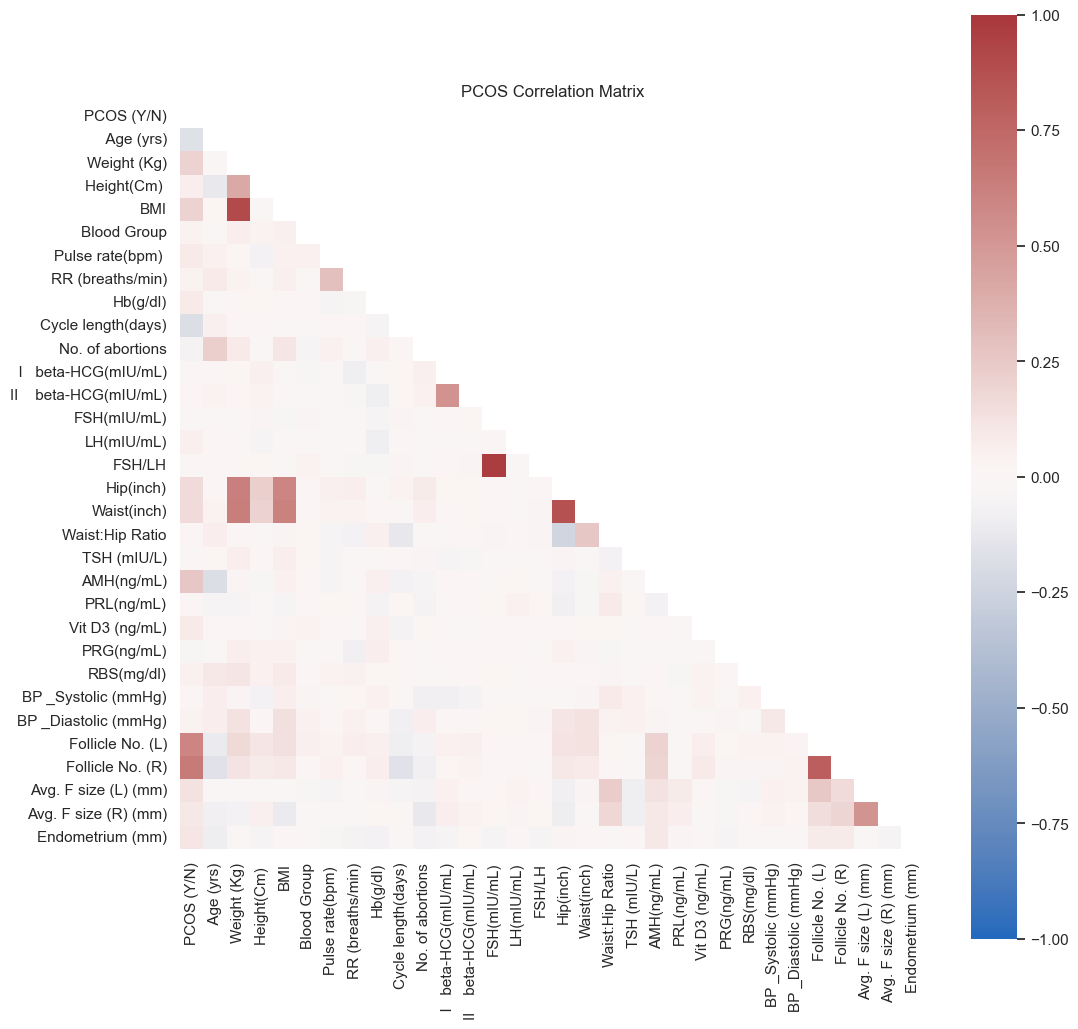

In [832]:
# Correlation Matrix
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix))
plt.subplots(figsize=(12, 12))
sns.heatmap(correlation_matrix, vmax=1, vmin=-1, cmap="vlag", square=True, mask=mask).set(title="PCOS Correlation Matrix")
plt.show()

**Observation:***


**Strong Correlations**:
   - BMI and Weight (Kg): There is a very strong positive correlation between BMI and weight, which is expected since BMI is derived from weight and height.
   - Waist (inch) and Waist:Hip Ratio: A strong positive correlation exists, as waist size directly contributes to the waist-to-hip ratio.
   - Follicle No. (L) and Follicle No. (R): These two variables are strongly correlated, likely because patients with higher follicle counts on one side tend to have higher counts on the other side.

**Weak or No Correlation**:
   - Variables like "Blood Group" and "Pulse rate(bpm)" show very weak or no correlation with other features, indicating they might not be significant in predicting PCOS.

**PCOS (Y/N)**:
   - Moderate correlations can be seen between `PCOS (Y/N)` and features like `AMH(ng/mL)` (positive correlation), `Follicle No. (L)` and `Follicle No. (R)` (positive correlations). This aligns with clinical findings that higher AMH levels and increased follicle counts are associated with PCOS.

**Outliers in Hormonal Data**:
   - Variables like `FSH(mIU/mL)`, `LH(mIU/mL)`, and `FSH/LH` show some unusual correlations, possibly due to outliers or extreme values in the dataset.

**Endometrium Thickness**:
   - Weak correlations are observed between endometrium thickness and other variables, suggesting it might not be a strong predictor of PCOS in this dataset.


In [834]:
# Filtered Correlation Matrix
correlation_matrix_filtered = correlation_matrix.unstack()
correlation_matrix_filtered = correlation_matrix_filtered[abs(correlation_matrix_filtered) >= 0.7]
print(correlation_matrix_filtered)

PCOS (Y/N)              PCOS (Y/N)                1.00
 Age (yrs)               Age (yrs)                1.00
Weight (Kg)             Weight (Kg)               1.00
                        BMI                       0.90
Height(Cm)              Height(Cm)                1.00
BMI                     Weight (Kg)               0.90
                        BMI                       1.00
Blood Group             Blood Group               1.00
Pulse rate(bpm)         Pulse rate(bpm)           1.00
RR (breaths/min)        RR (breaths/min)          1.00
Hb(g/dl)                Hb(g/dl)                  1.00
Cycle length(days)      Cycle length(days)        1.00
No. of abortions        No. of abortions          1.00
  I   beta-HCG(mIU/mL)    I   beta-HCG(mIU/mL)    1.00
II    beta-HCG(mIU/mL)  II    beta-HCG(mIU/mL)    1.00
FSH(mIU/mL)             FSH(mIU/mL)               1.00
                        FSH/LH                    0.97
LH(mIU/mL)              LH(mIU/mL)                1.00
FSH/LH    

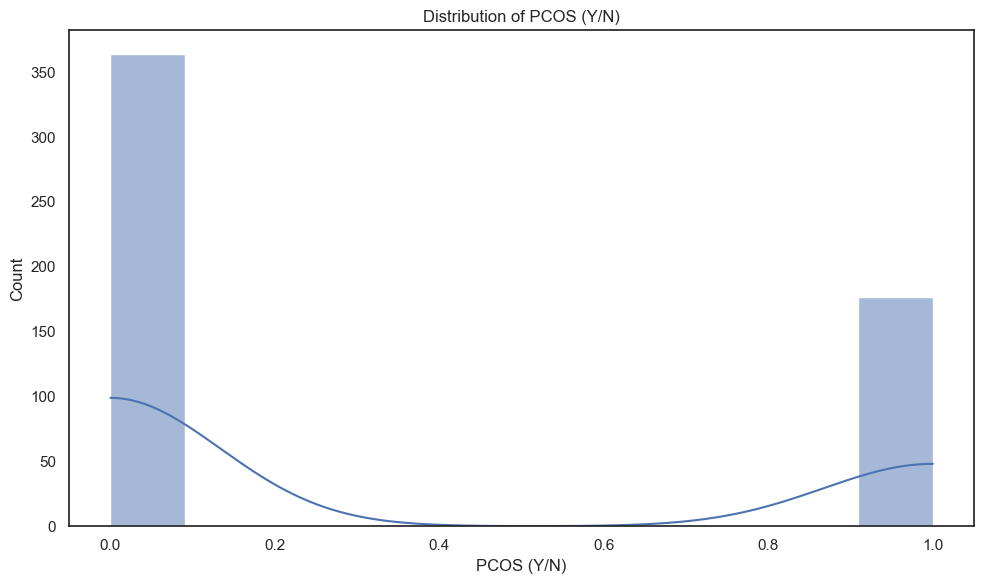


Summary Statistics for PCOS (Y/N):
count    541.000000
mean       0.327172
std        0.469615
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: PCOS (Y/N), dtype: float64


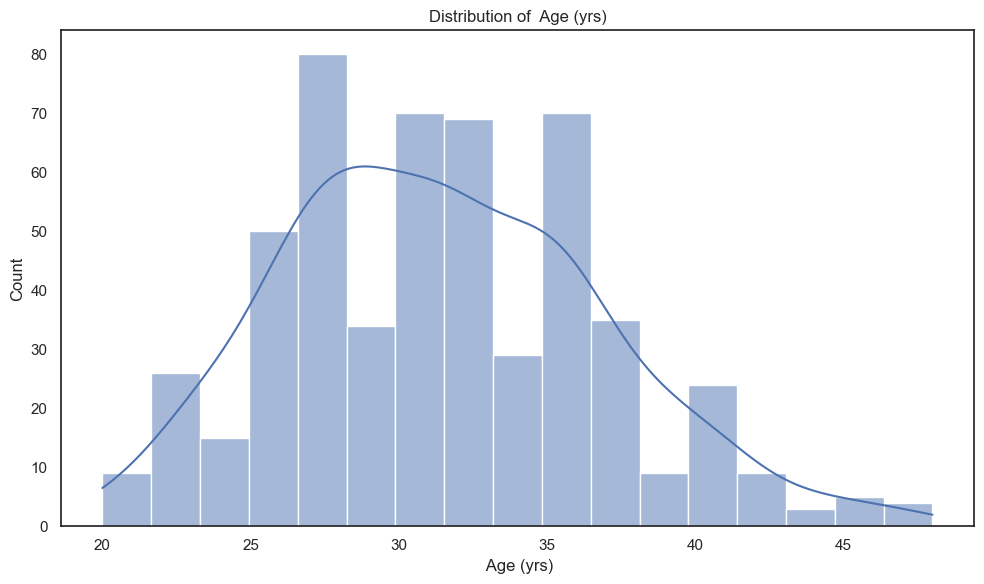


Summary Statistics for  Age (yrs):
count    541.000000
mean      31.430684
std        5.411006
min       20.000000
25%       28.000000
50%       31.000000
75%       35.000000
max       48.000000
Name:  Age (yrs), dtype: float64


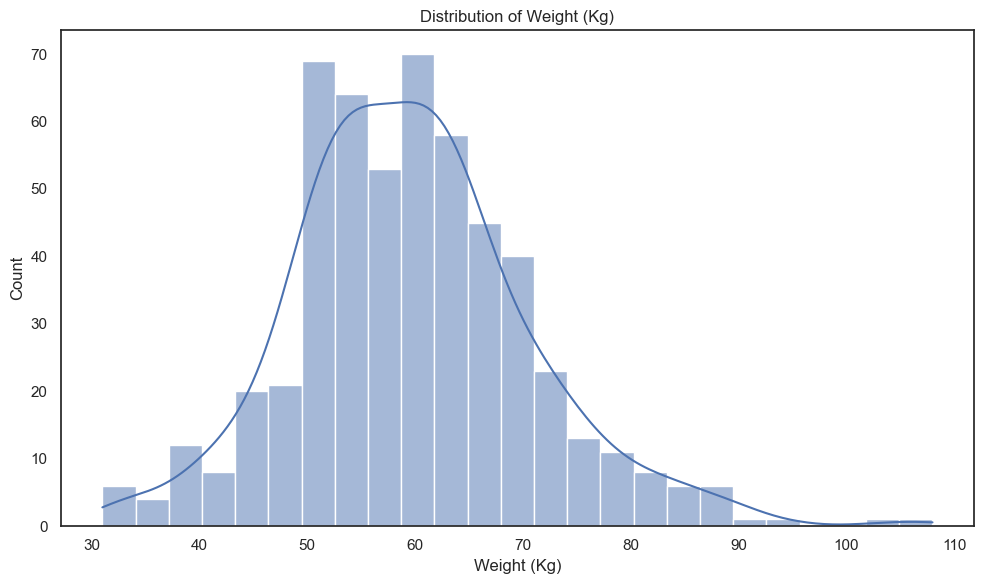


Summary Statistics for Weight (Kg):
count    541.000000
mean      59.637153
std       11.028287
min       31.000000
25%       52.000000
50%       59.000000
75%       65.000000
max      108.000000
Name: Weight (Kg), dtype: float64


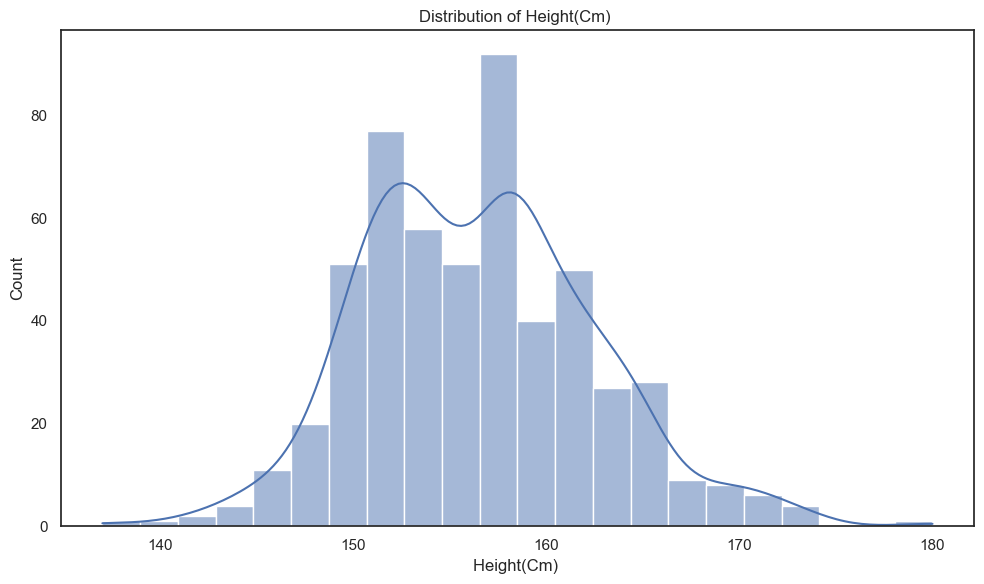


Summary Statistics for Height(Cm) :
count    541.000000
mean     156.484835
std        6.033545
min      137.000000
25%      152.000000
50%      156.000000
75%      160.000000
max      180.000000
Name: Height(Cm) , dtype: float64


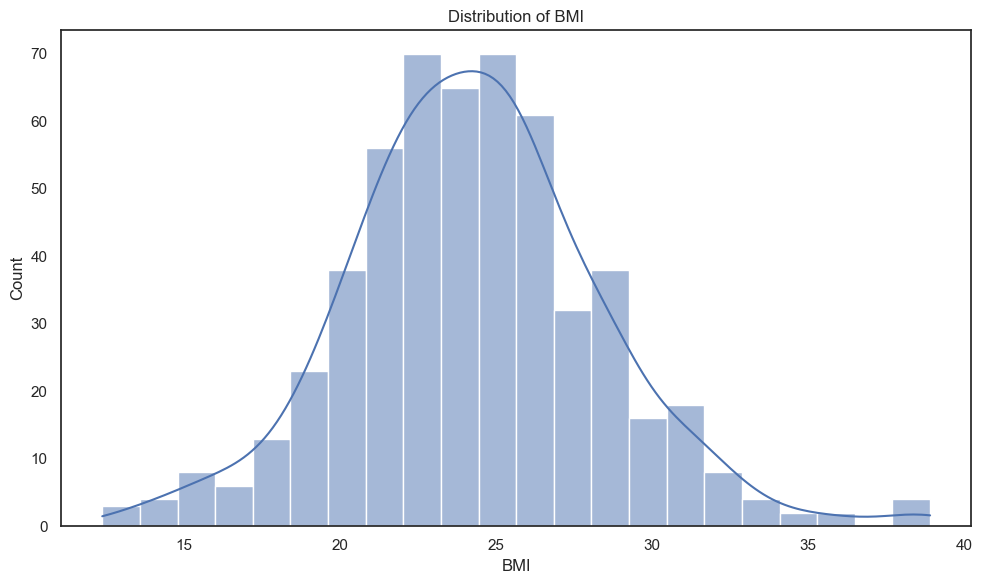


Summary Statistics for BMI:
count    541.000000
mean      24.307579
std        4.055129
min       12.400000
25%       21.600000
50%       24.200000
75%       26.600000
max       38.900000
Name: BMI, dtype: float64


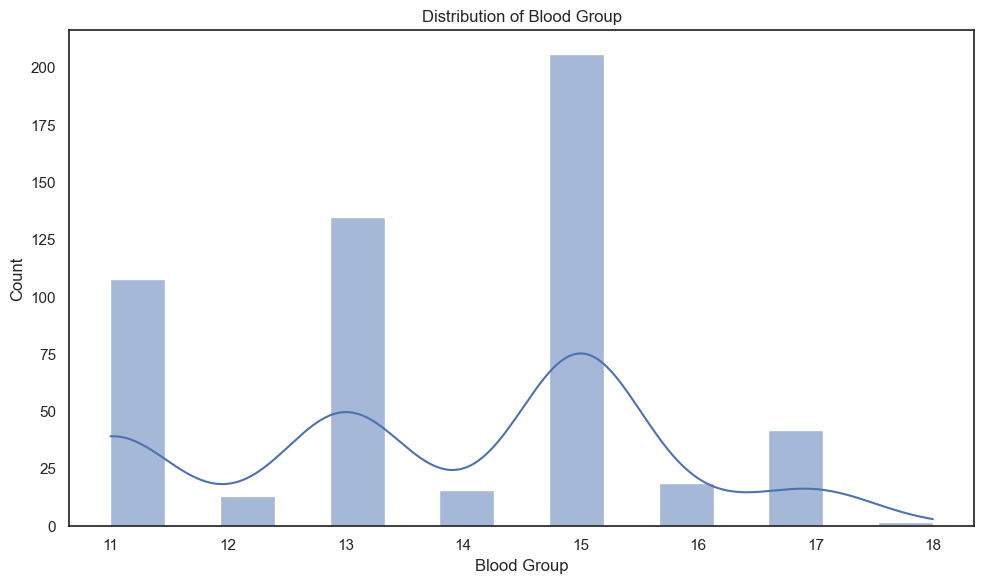


Summary Statistics for Blood Group:
count    541.000000
mean      13.802218
std        1.840812
min       11.000000
25%       13.000000
50%       14.000000
75%       15.000000
max       18.000000
Name: Blood Group, dtype: float64


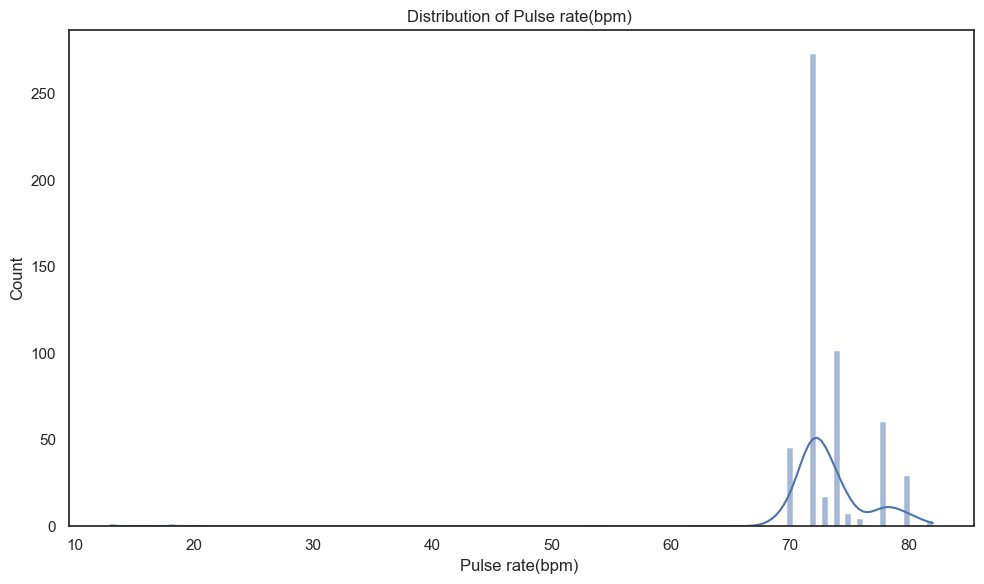


Summary Statistics for Pulse rate(bpm) :
count    541.000000
mean      73.247689
std        4.430285
min       13.000000
25%       72.000000
50%       72.000000
75%       74.000000
max       82.000000
Name: Pulse rate(bpm) , dtype: float64


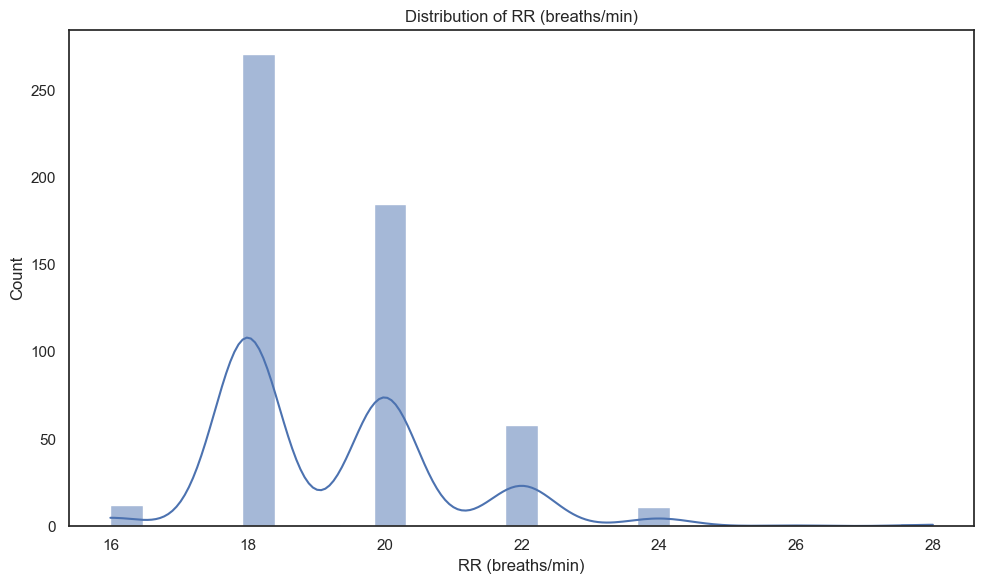


Summary Statistics for RR (breaths/min):
count    541.000000
mean      19.243993
std        1.688629
min       16.000000
25%       18.000000
50%       18.000000
75%       20.000000
max       28.000000
Name: RR (breaths/min), dtype: float64


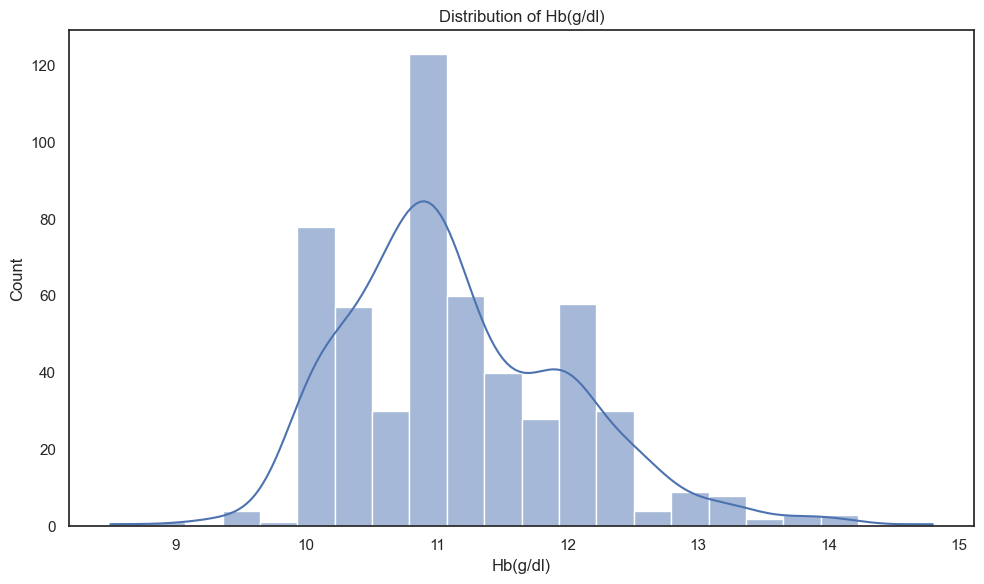


Summary Statistics for Hb(g/dl):
count    541.000000
mean      11.160037
std        0.866904
min        8.500000
25%       10.500000
50%       11.000000
75%       11.700000
max       14.800000
Name: Hb(g/dl), dtype: float64


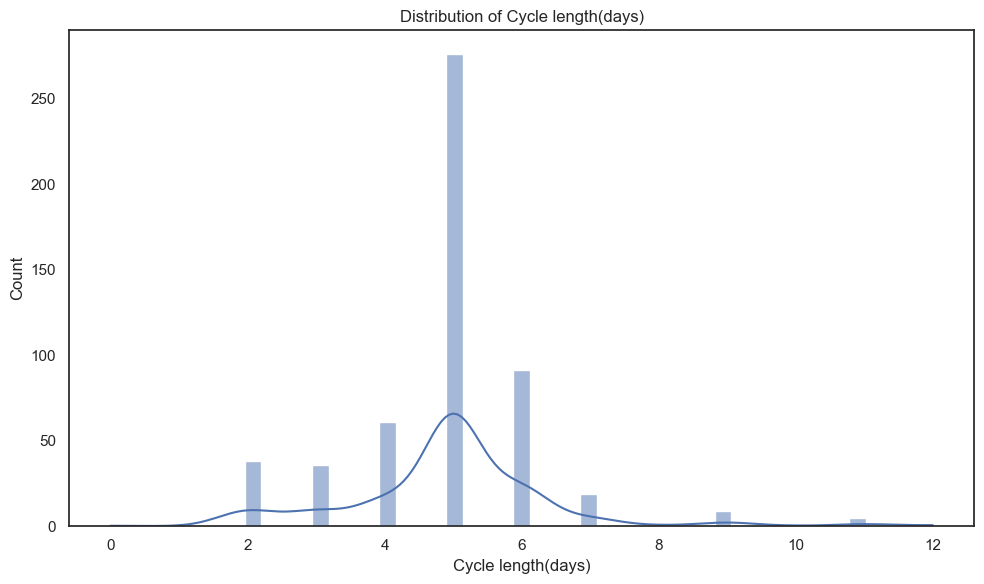


Summary Statistics for Cycle length(days):
count    541.00000
mean       4.94085
std        1.49202
min        0.00000
25%        4.00000
50%        5.00000
75%        5.00000
max       12.00000
Name: Cycle length(days), dtype: float64


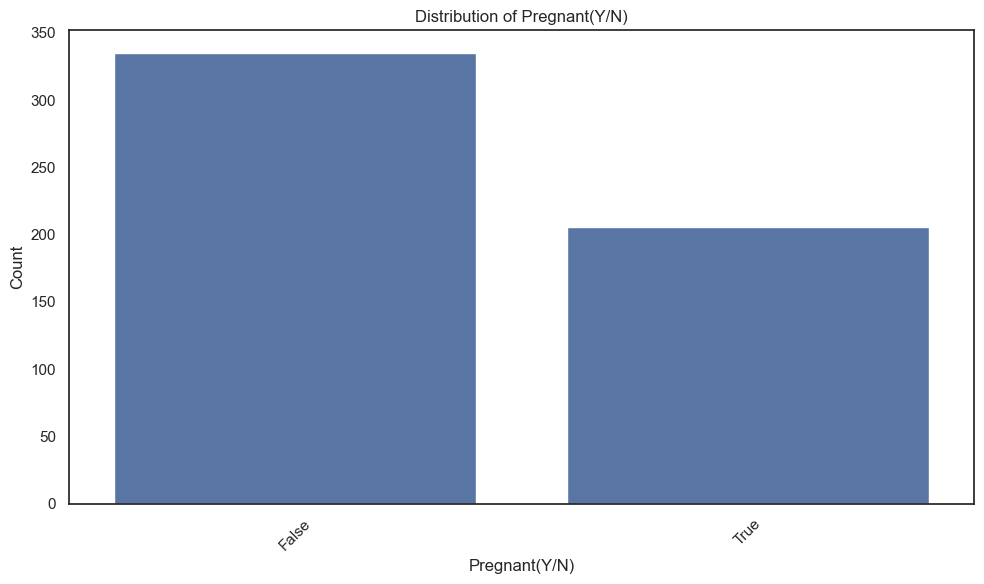


Summary Statistics for Pregnant(Y/N):
count       541
unique        2
top       False
freq        335
Name: Pregnant(Y/N), dtype: object


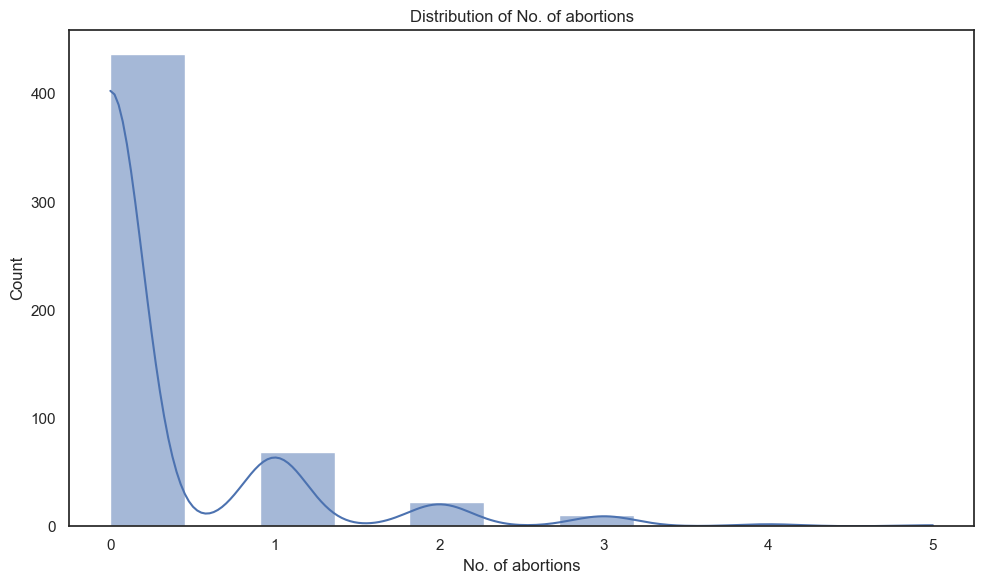


Summary Statistics for No. of abortions:
count    541.000000
mean       0.288355
std        0.692575
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: No. of abortions, dtype: float64


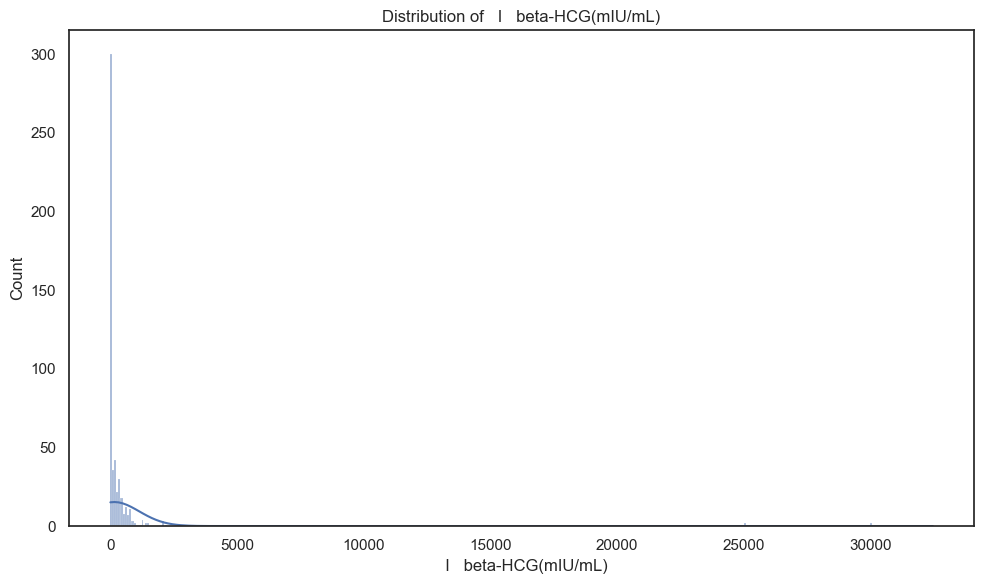


Summary Statistics for   I   beta-HCG(mIU/mL):
count      541.000000
mean       664.549235
std       3348.920576
min          1.300000
25%          1.990000
50%         20.000000
75%        297.210000
max      32460.970000
Name:   I   beta-HCG(mIU/mL), dtype: float64


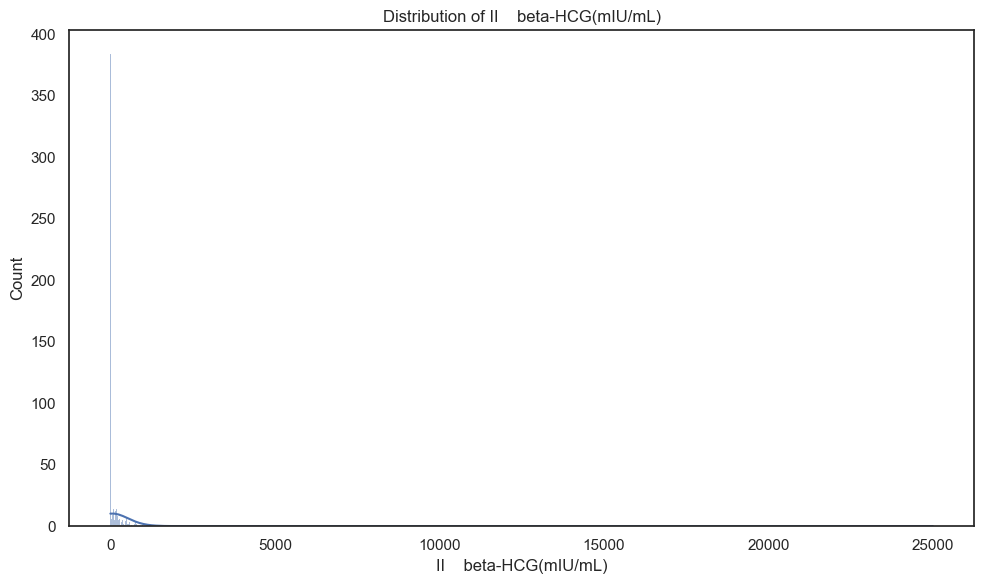


Summary Statistics for II    beta-HCG(mIU/mL):
count      541.000000
mean       238.232993
std       1603.825706
min          0.990000
25%          1.990000
50%          1.990000
75%         97.630000
max      25000.000000
Name: II    beta-HCG(mIU/mL), dtype: float64


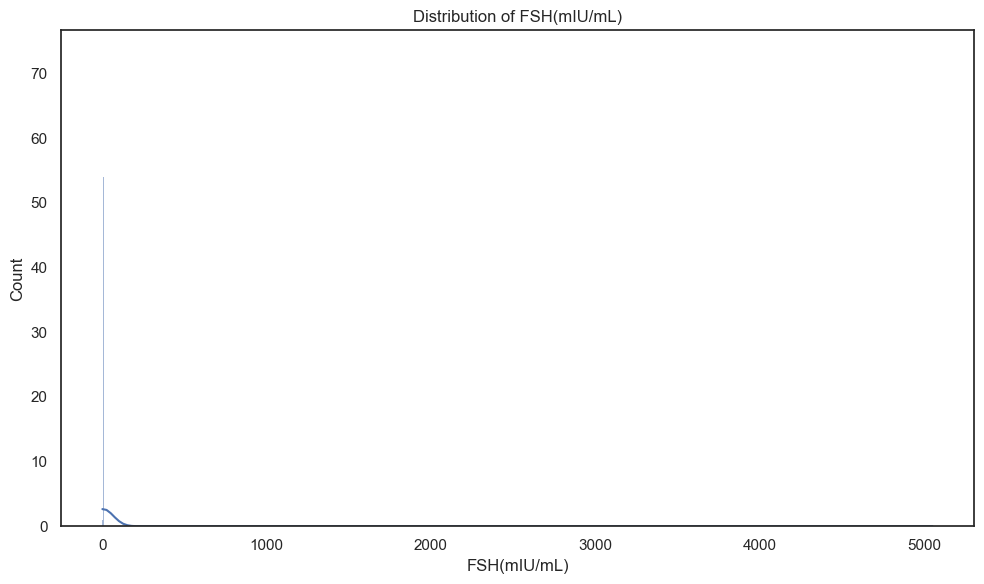


Summary Statistics for FSH(mIU/mL):
count     541.000000
mean       14.601832
std       217.022081
min         0.210000
25%         3.300000
50%         4.850000
75%         6.410000
max      5052.000000
Name: FSH(mIU/mL), dtype: float64


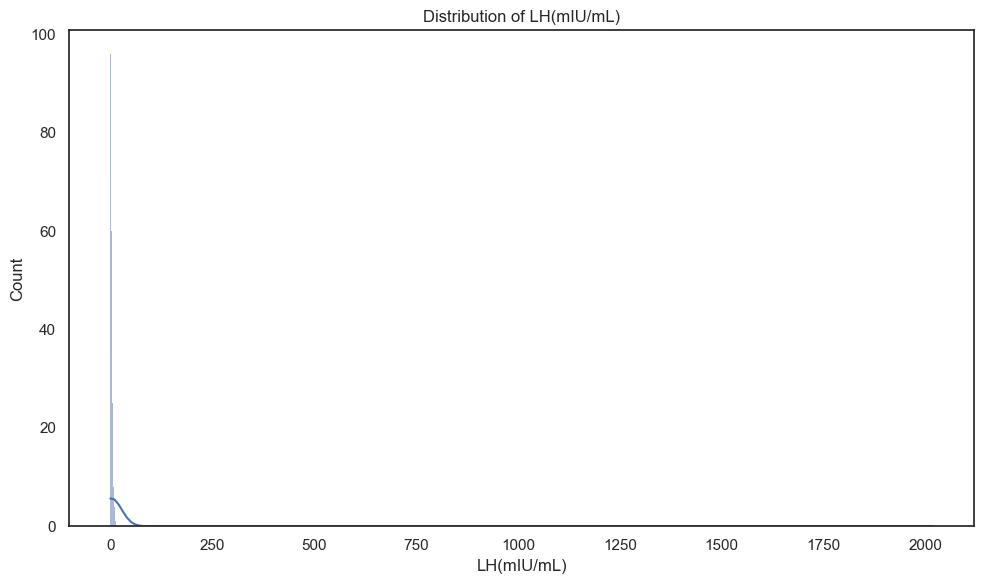


Summary Statistics for LH(mIU/mL):
count     541.000000
mean        6.469919
std        86.673255
min         0.020000
25%         1.020000
50%         2.300000
75%         3.680000
max      2018.000000
Name: LH(mIU/mL), dtype: float64


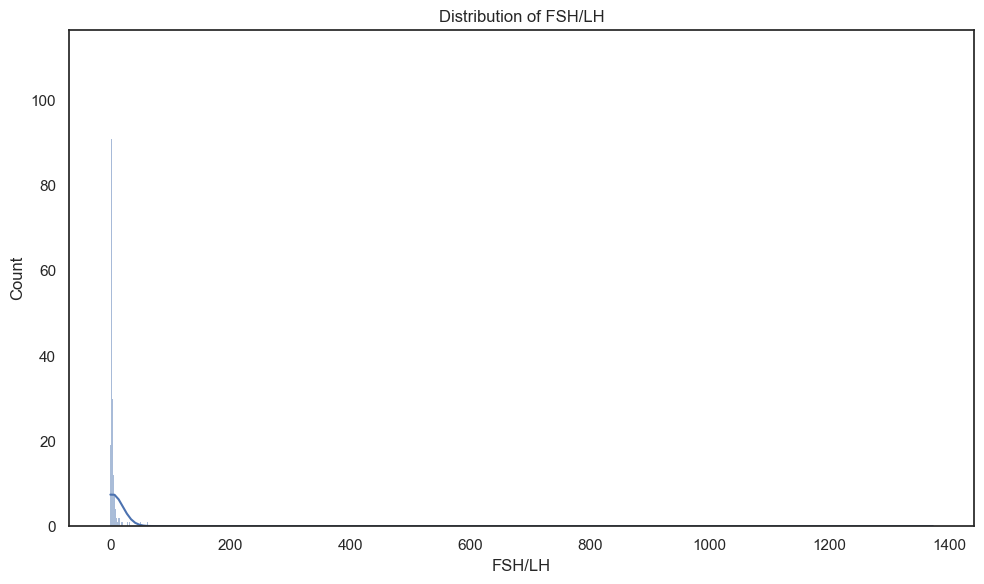


Summary Statistics for FSH/LH:
count     541.000000
mean        6.904917
std        60.691982
min         0.000000
25%         1.420000
50%         2.170000
75%         3.960000
max      1372.830000
Name: FSH/LH, dtype: float64


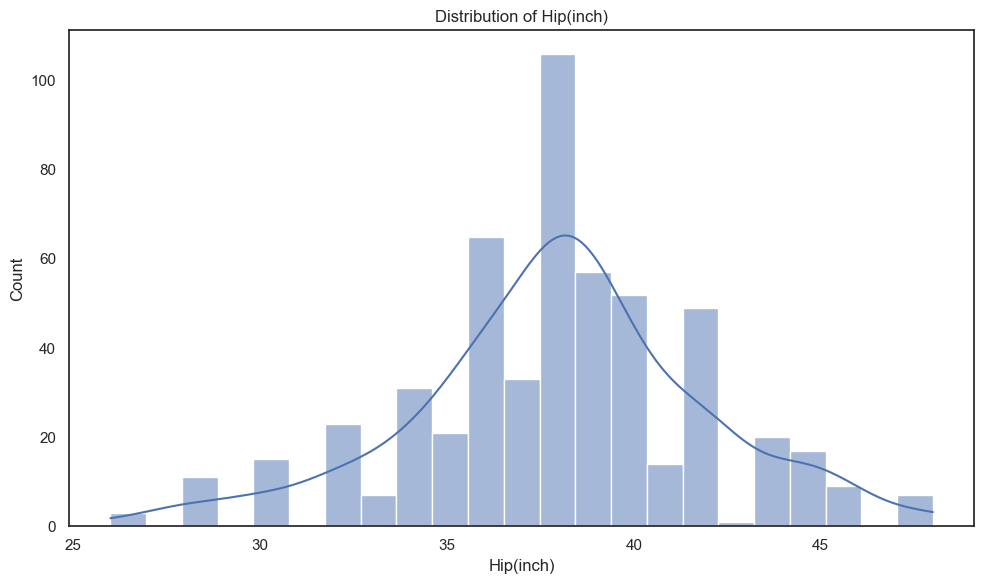


Summary Statistics for Hip(inch):
count    541.000000
mean      37.992606
std        3.967920
min       26.000000
25%       36.000000
50%       38.000000
75%       40.000000
max       48.000000
Name: Hip(inch), dtype: float64


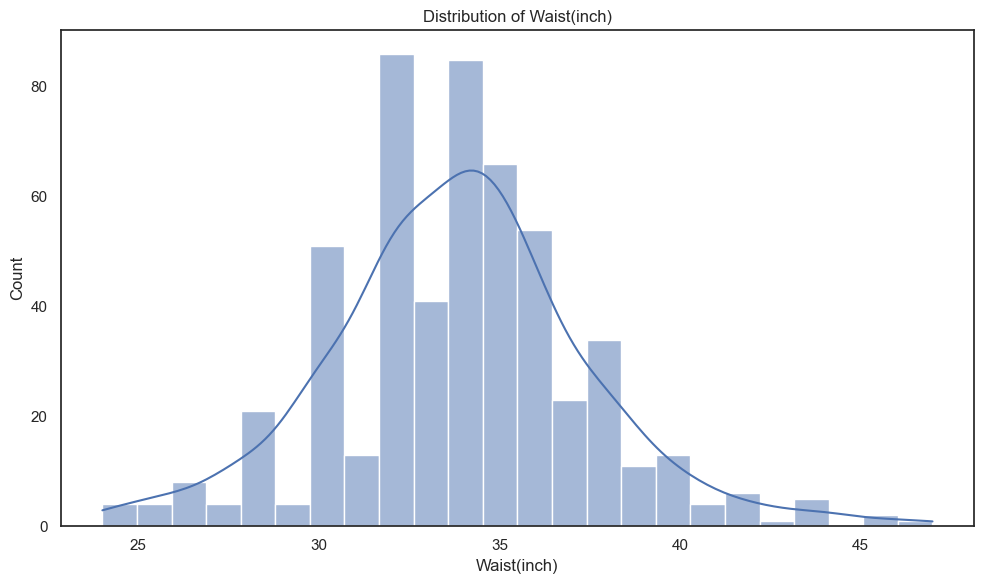


Summary Statistics for Waist(inch):
count    541.000000
mean      33.841035
std        3.596894
min       24.000000
25%       32.000000
50%       34.000000
75%       36.000000
max       47.000000
Name: Waist(inch), dtype: float64


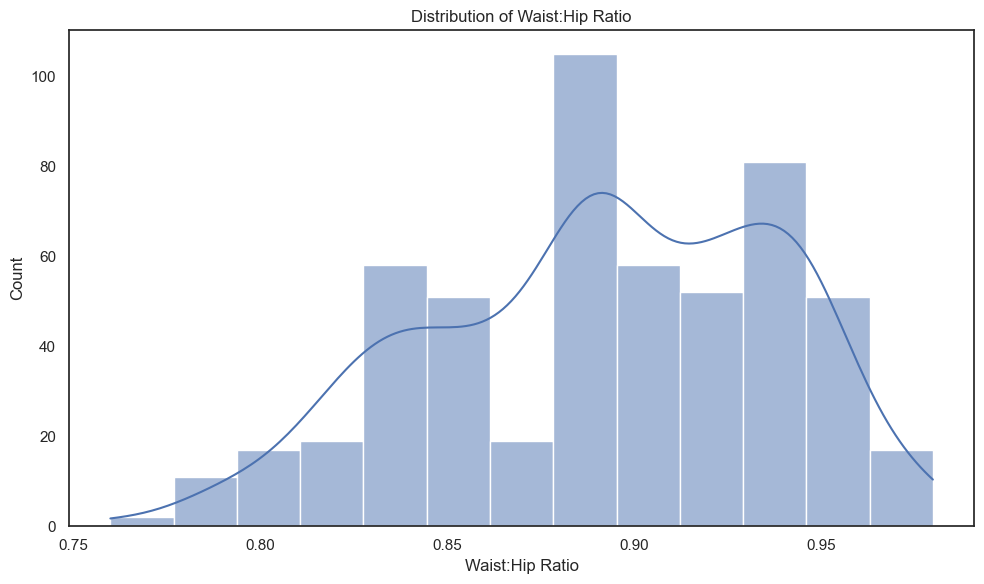


Summary Statistics for Waist:Hip Ratio:
count    541.000000
mean       0.891627
std        0.046135
min        0.760000
25%        0.860000
50%        0.890000
75%        0.930000
max        0.980000
Name: Waist:Hip Ratio, dtype: float64


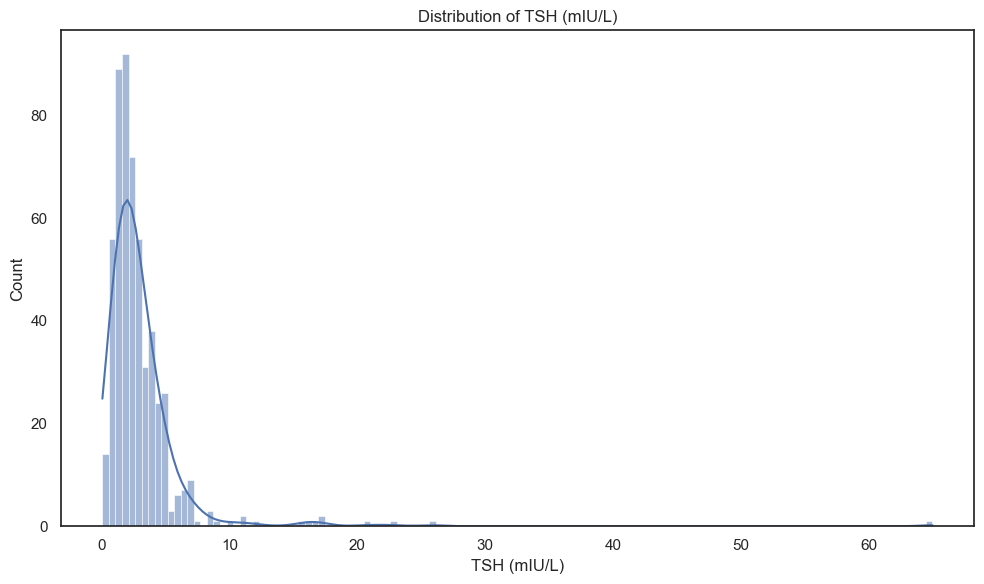


Summary Statistics for TSH (mIU/L):
count    541.000000
mean       2.981281
std        3.755532
min        0.040000
25%        1.480000
50%        2.260000
75%        3.570000
max       65.000000
Name: TSH (mIU/L), dtype: float64


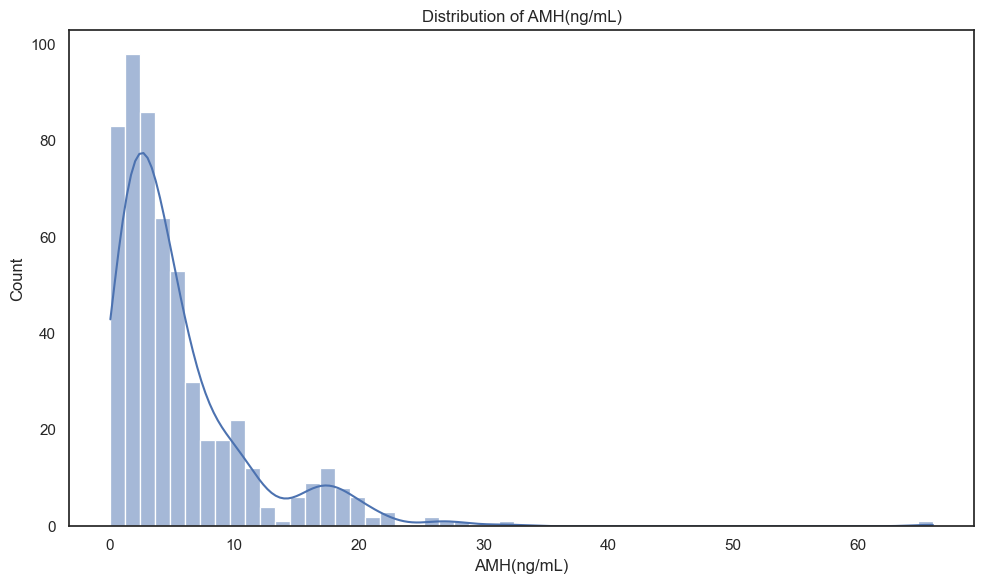


Summary Statistics for AMH(ng/mL):
count    541.000000
mean       5.620634
std        5.876742
min        0.100000
25%        2.010000
50%        3.700000
75%        6.900000
max       66.000000
Name: AMH(ng/mL), dtype: float64


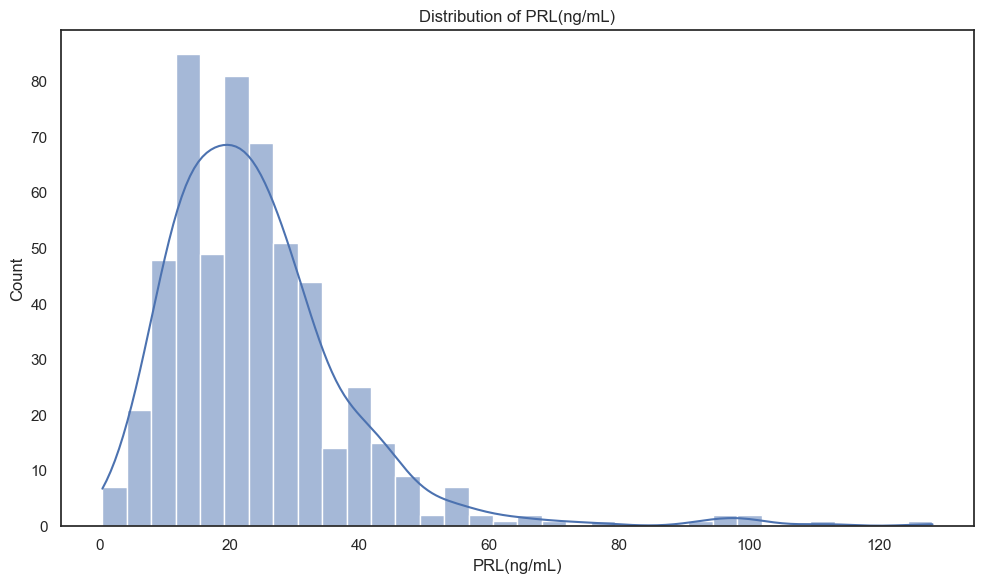


Summary Statistics for PRL(ng/mL):
count    541.000000
mean      24.321497
std       14.970391
min        0.400000
25%       14.520000
50%       21.920000
75%       29.890000
max      128.240000
Name: PRL(ng/mL), dtype: float64


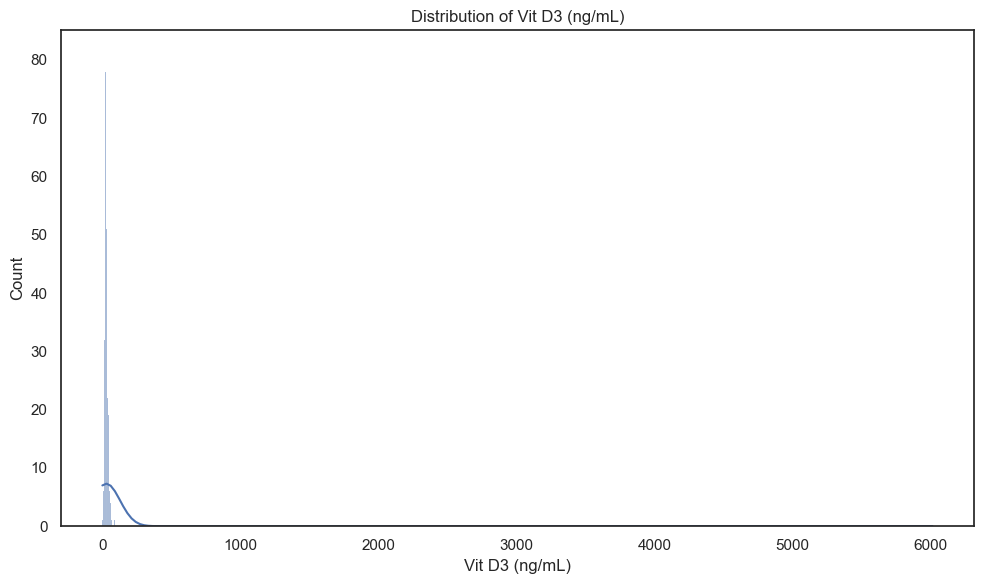


Summary Statistics for Vit D3 (ng/mL):
count     541.000000
mean       49.915874
std       346.206599
min         0.000000
25%        20.800000
50%        25.900000
75%        34.500000
max      6014.660000
Name: Vit D3 (ng/mL), dtype: float64


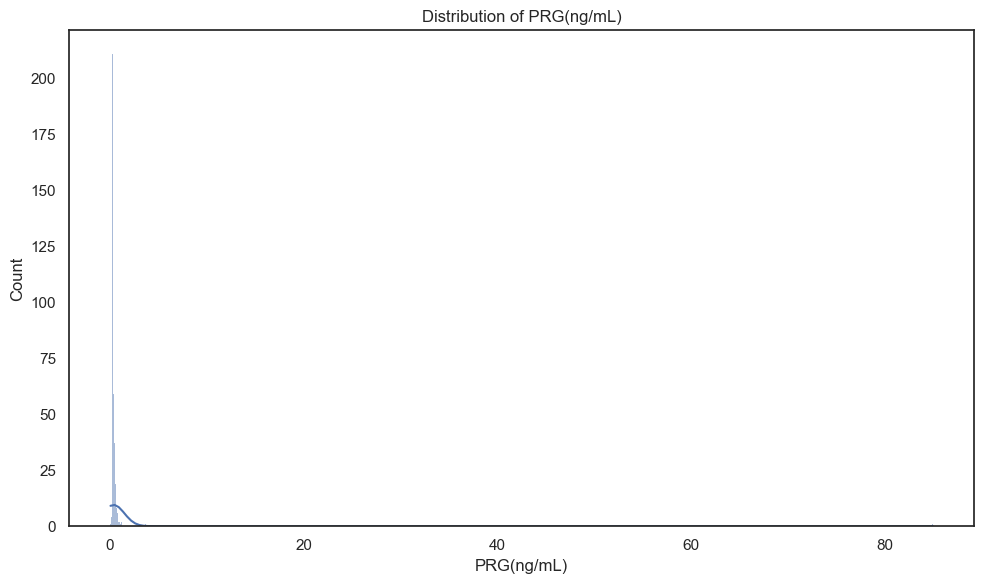


Summary Statistics for PRG(ng/mL):
count    541.000000
mean       0.610945
std        3.808853
min        0.047000
25%        0.250000
50%        0.320000
75%        0.450000
max       85.000000
Name: PRG(ng/mL), dtype: float64


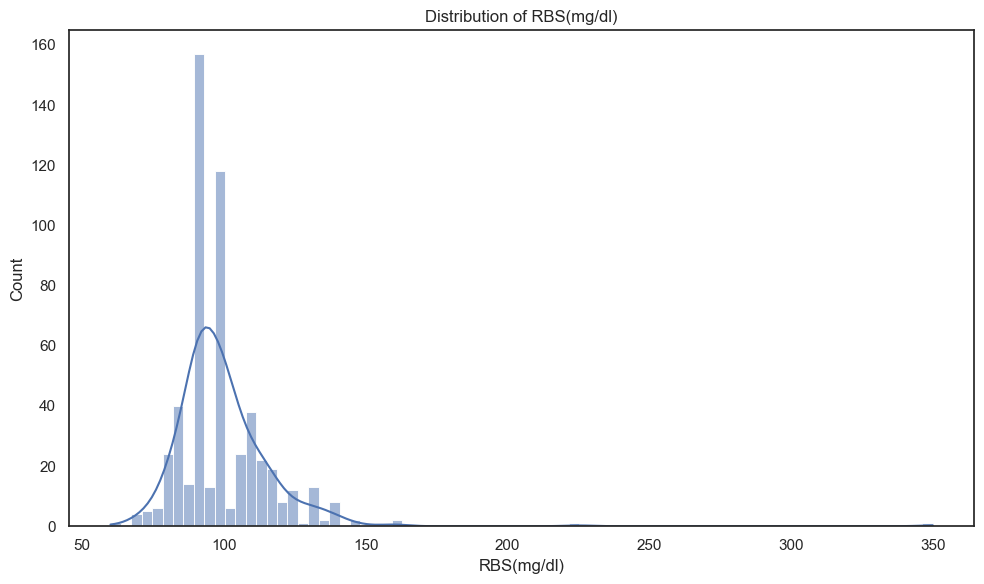


Summary Statistics for RBS(mg/dl):
count    541.000000
mean      99.835860
std       18.559298
min       60.000000
25%       92.000000
50%      100.000000
75%      107.000000
max      350.000000
Name: RBS(mg/dl), dtype: float64


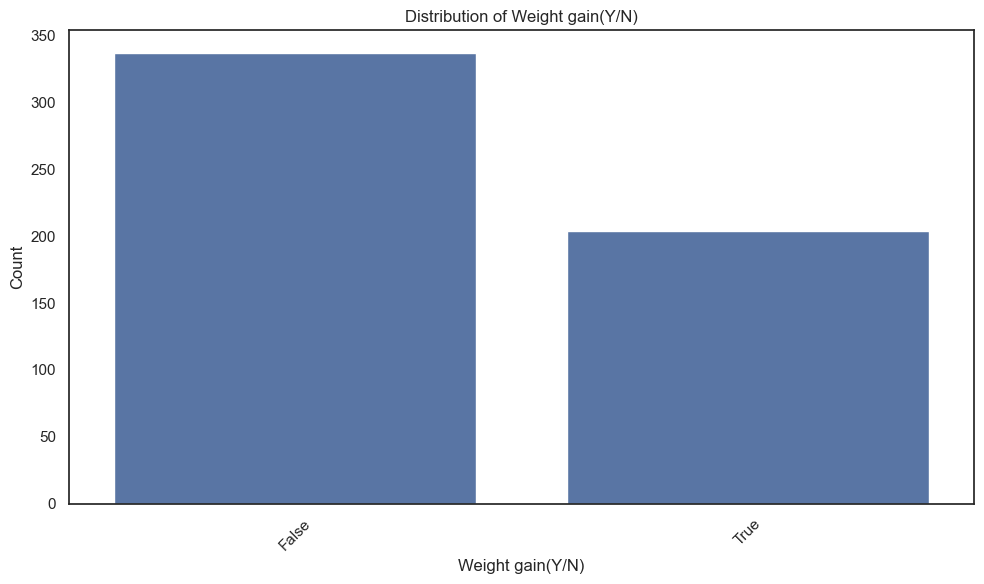


Summary Statistics for Weight gain(Y/N):
count       541
unique        2
top       False
freq        337
Name: Weight gain(Y/N), dtype: object


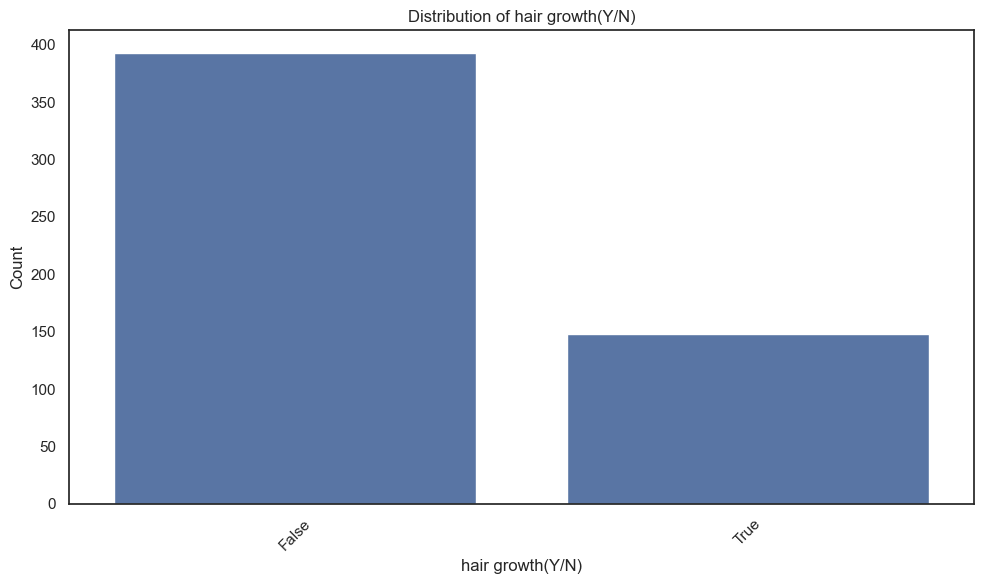


Summary Statistics for hair growth(Y/N):
count       541
unique        2
top       False
freq        393
Name: hair growth(Y/N), dtype: object


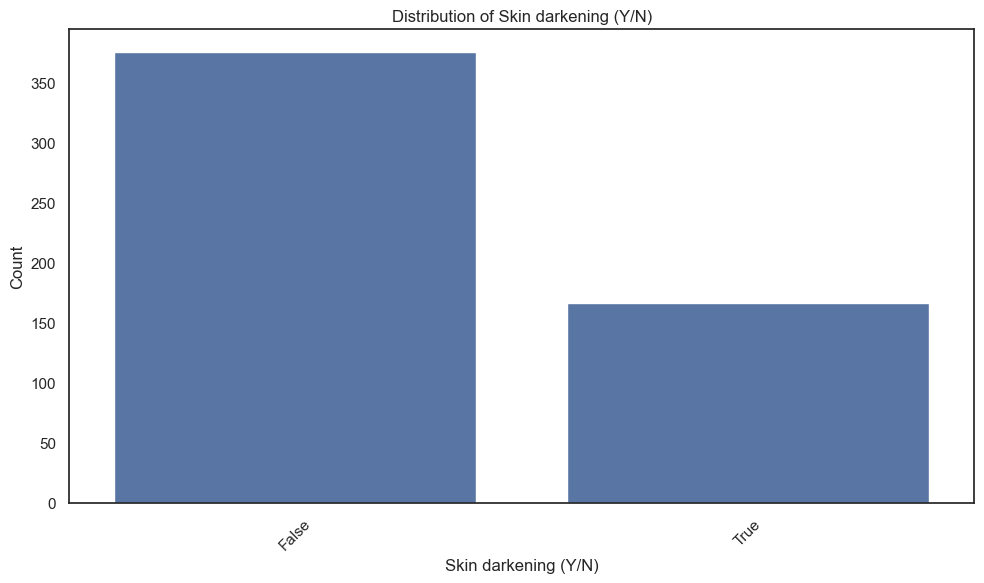


Summary Statistics for Skin darkening (Y/N):
count       541
unique        2
top       False
freq        375
Name: Skin darkening (Y/N), dtype: object


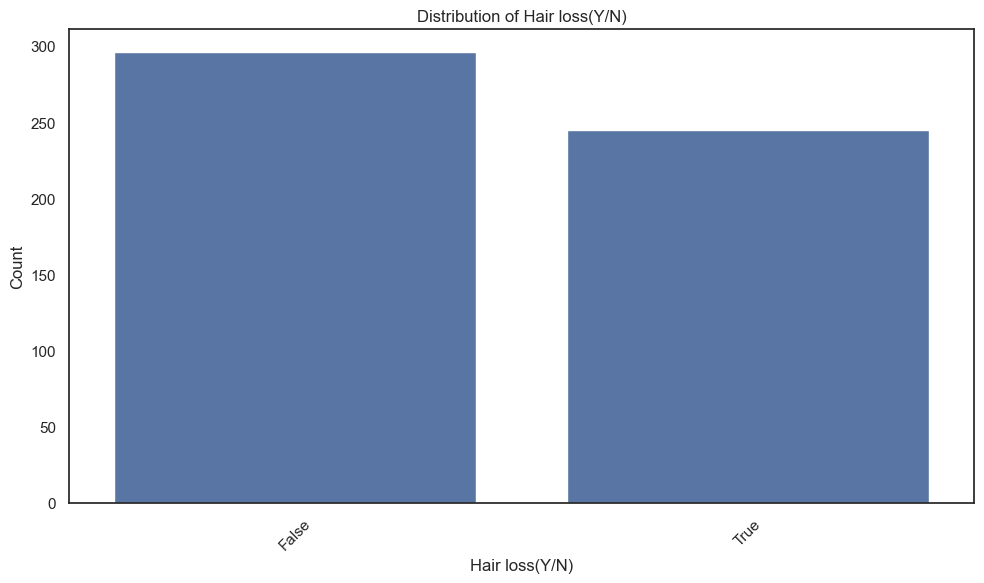


Summary Statistics for Hair loss(Y/N):
count       541
unique        2
top       False
freq        296
Name: Hair loss(Y/N), dtype: object


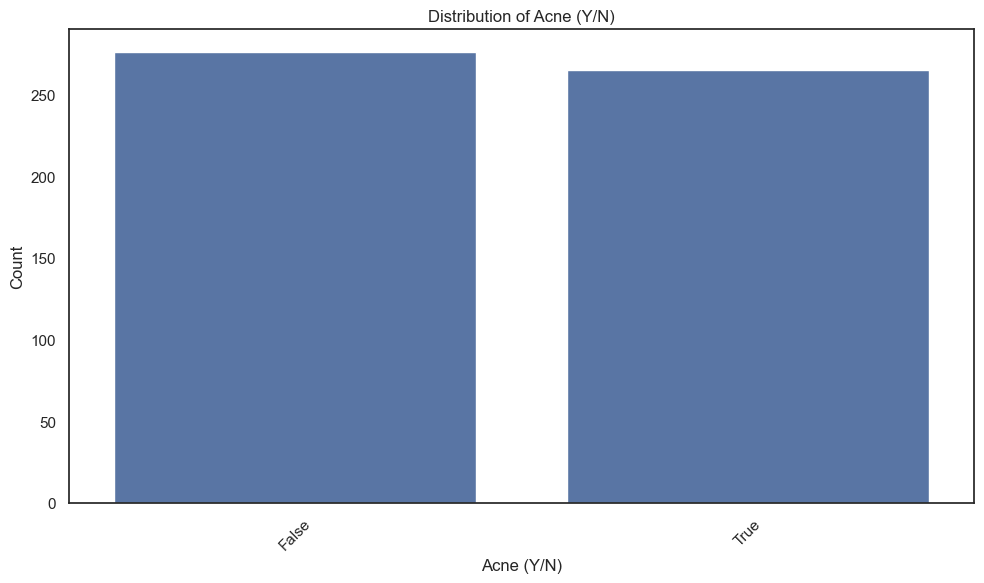


Summary Statistics for Acne (Y/N):
count       541
unique        2
top       False
freq        276
Name: Acne (Y/N), dtype: object


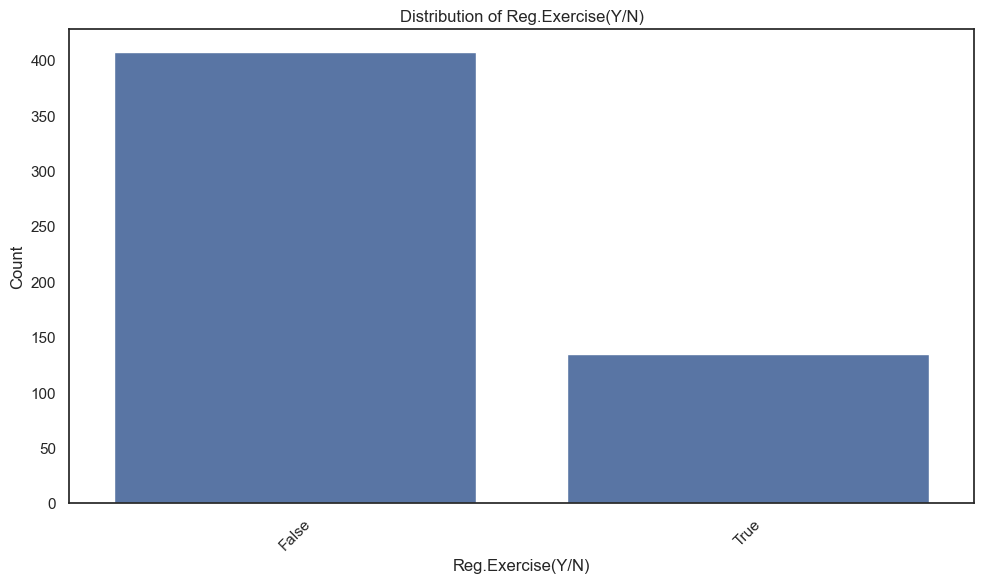


Summary Statistics for Reg.Exercise(Y/N):
count       541
unique        2
top       False
freq        407
Name: Reg.Exercise(Y/N), dtype: object


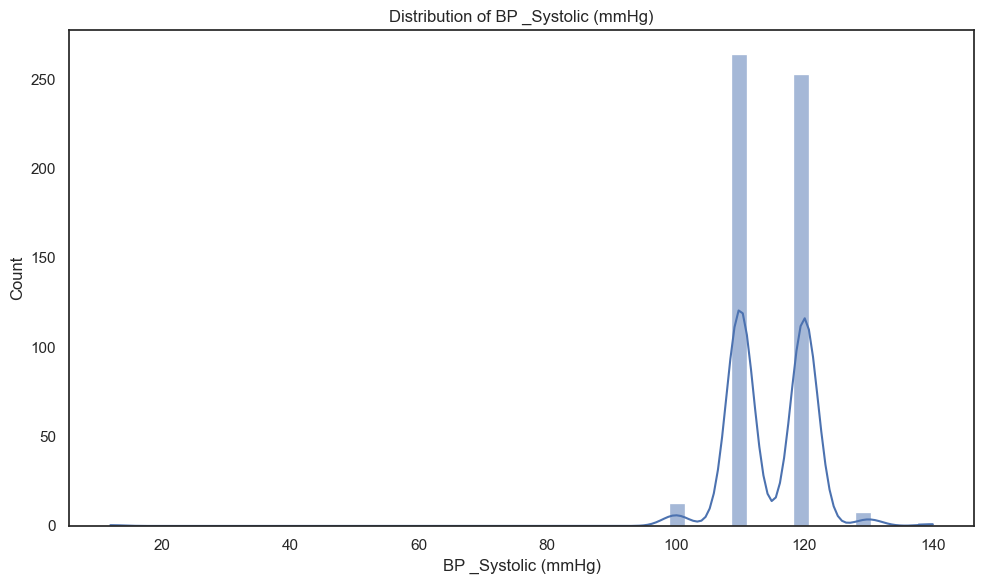


Summary Statistics for BP _Systolic (mmHg):
count    541.000000
mean     114.661738
std        7.384556
min       12.000000
25%      110.000000
50%      110.000000
75%      120.000000
max      140.000000
Name: BP _Systolic (mmHg), dtype: float64


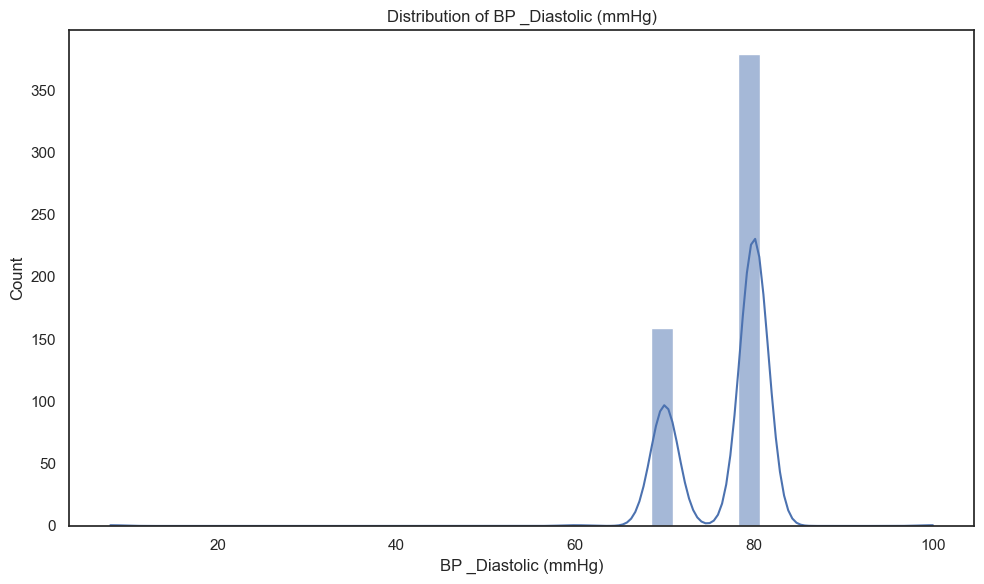


Summary Statistics for BP _Diastolic (mmHg):
count    541.000000
mean      76.927911
std        5.574112
min        8.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      100.000000
Name: BP _Diastolic (mmHg), dtype: float64


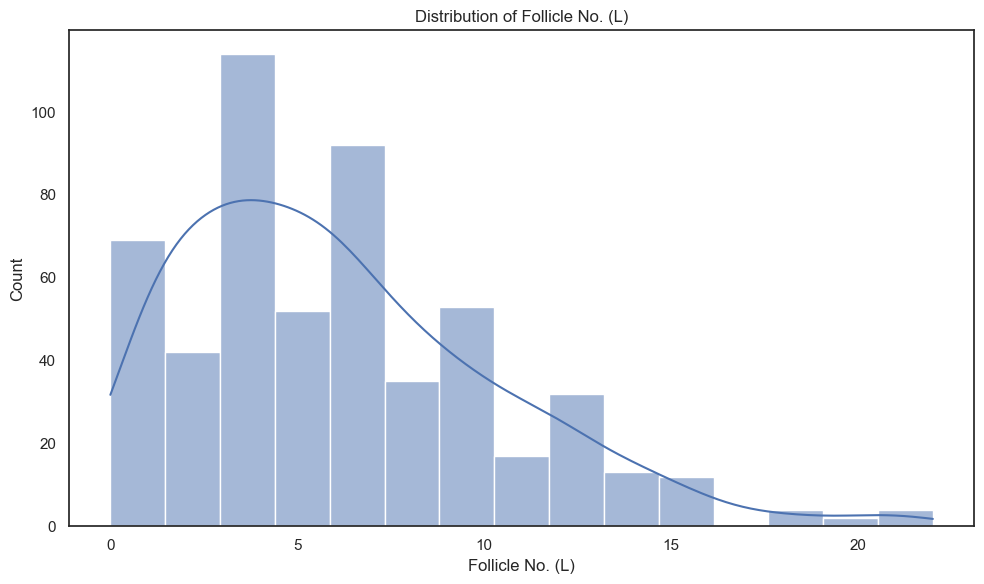


Summary Statistics for Follicle No. (L):
count    541.000000
mean       6.129390
std        4.229294
min        0.000000
25%        3.000000
50%        5.000000
75%        9.000000
max       22.000000
Name: Follicle No. (L), dtype: float64


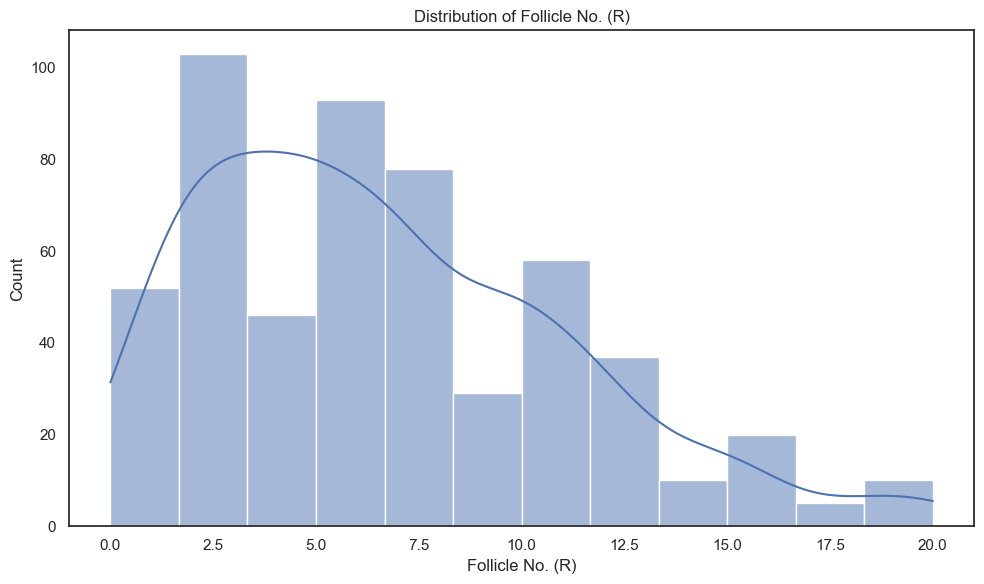


Summary Statistics for Follicle No. (R):
count    541.000000
mean       6.641405
std        4.436889
min        0.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       20.000000
Name: Follicle No. (R), dtype: float64


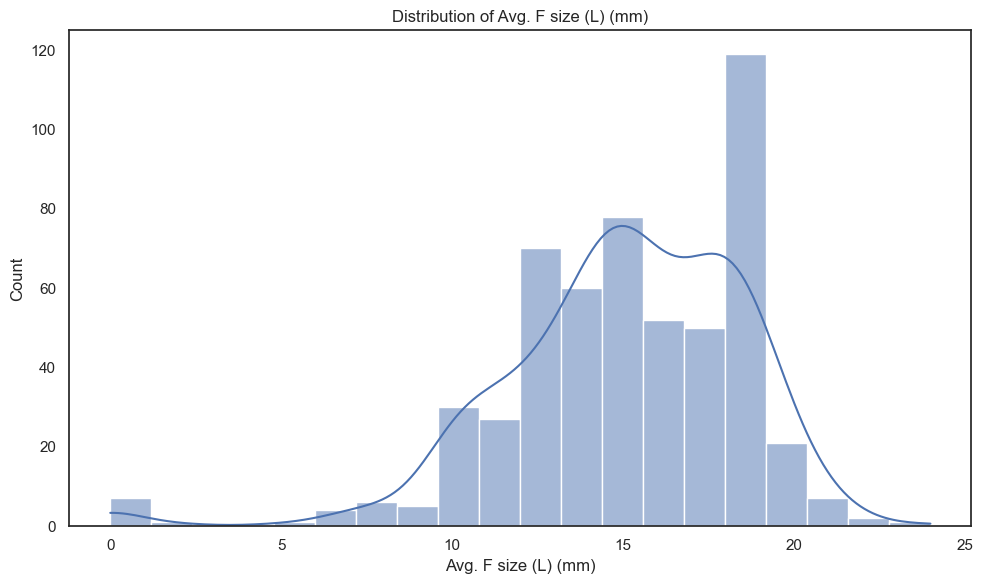


Summary Statistics for Avg. F size (L) (mm):
count    541.000000
mean      15.018115
std        3.566839
min        0.000000
25%       13.000000
50%       15.000000
75%       18.000000
max       24.000000
Name: Avg. F size (L) (mm), dtype: float64


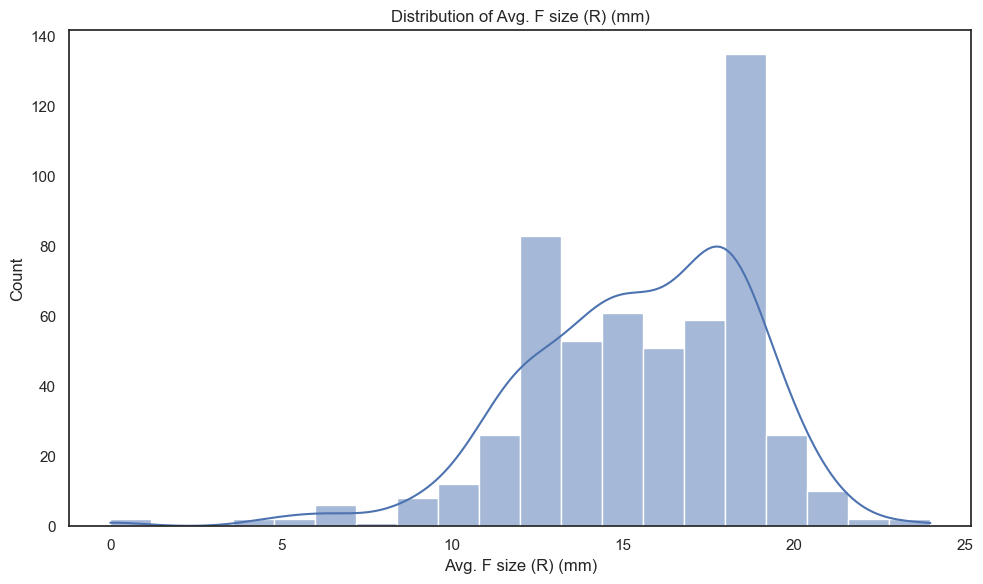


Summary Statistics for Avg. F size (R) (mm):
count    541.000000
mean      15.451701
std        3.318848
min        0.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       24.000000
Name: Avg. F size (R) (mm), dtype: float64


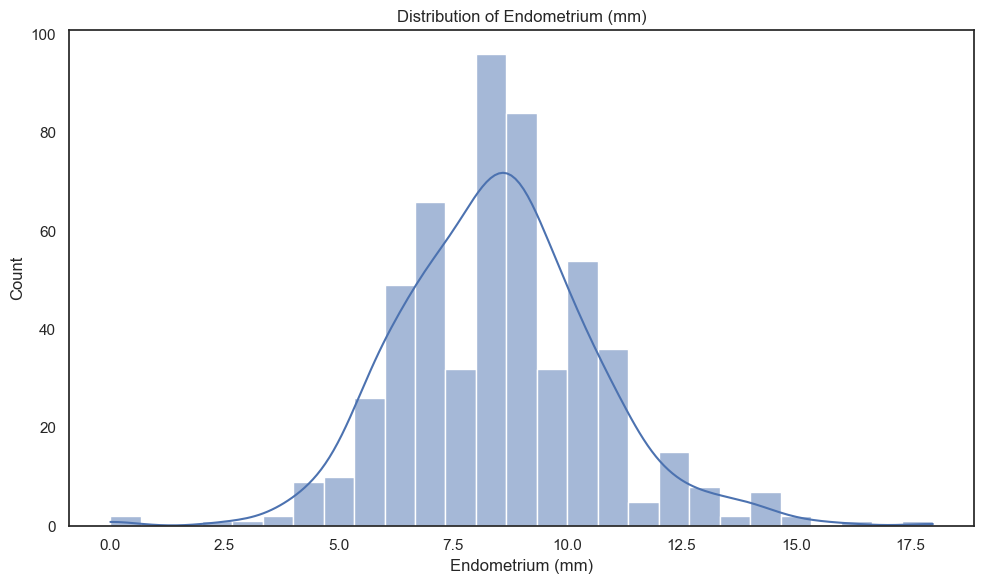


Summary Statistics for Endometrium (mm):
count    541.000000
mean       8.475915
std        2.165381
min        0.000000
25%        7.000000
50%        8.500000
75%        9.800000
max       18.000000
Name: Endometrium (mm), dtype: float64


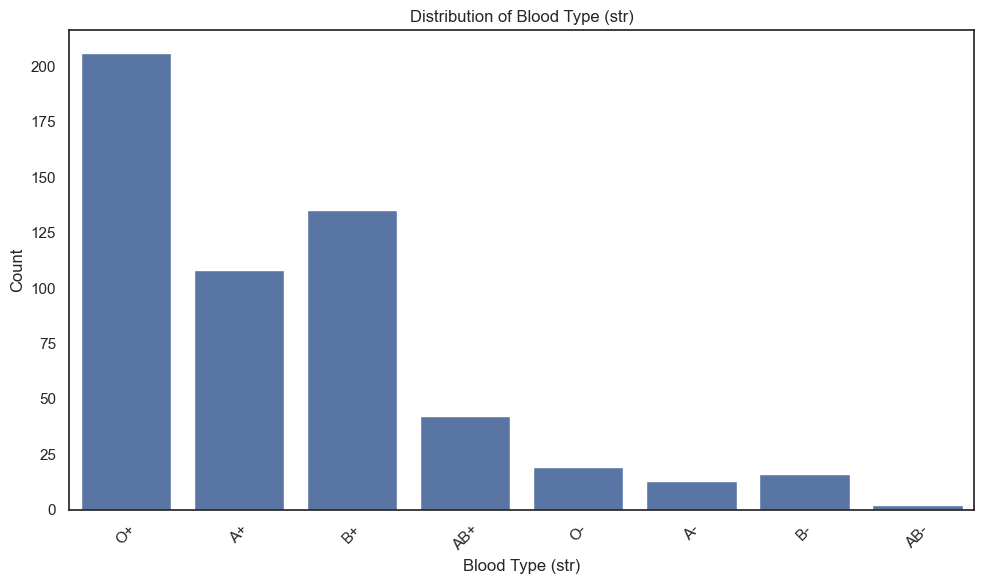


Summary Statistics for Blood Type (str):
count     541
unique      8
top        O+
freq      206
Name: Blood Type (str), dtype: object


In [835]:
def univariate_analysis(df, column):
    plt.figure(figsize=(10, 6))
    
    if df[column].dtype == 'object' or df[column].dtype == 'bool':
        # Categorical variable
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
        plt.xticks(rotation=45)
    else:
        # Numerical variable
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
    
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics for {column}:")
    print(df[column].describe())

# Example usage:
# univariate_analysis(df, 'BMI')
for column in df.columns:
    univariate_analysis(df, column)

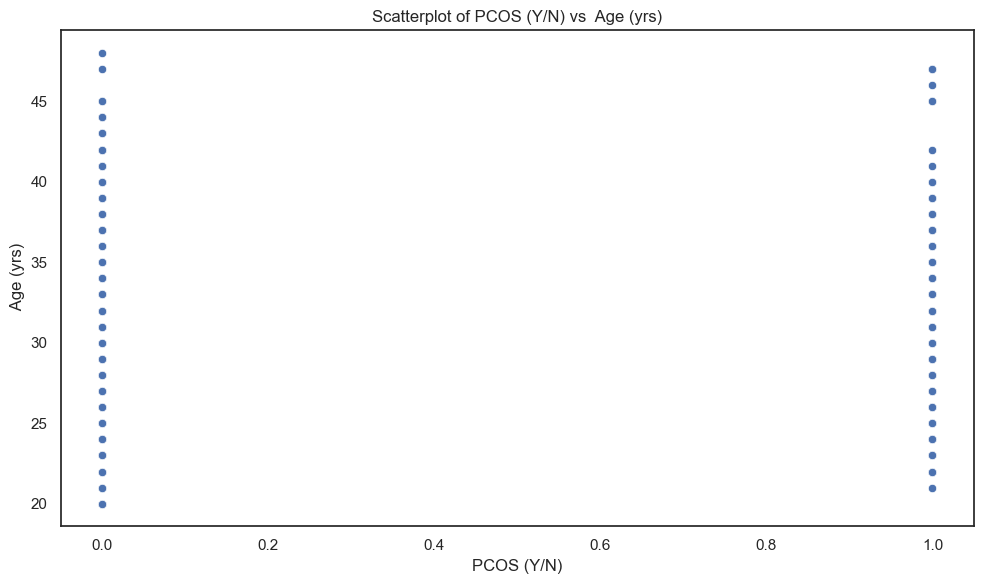


Correlation coefficient between PCOS (Y/N) and  Age (yrs): -0.17


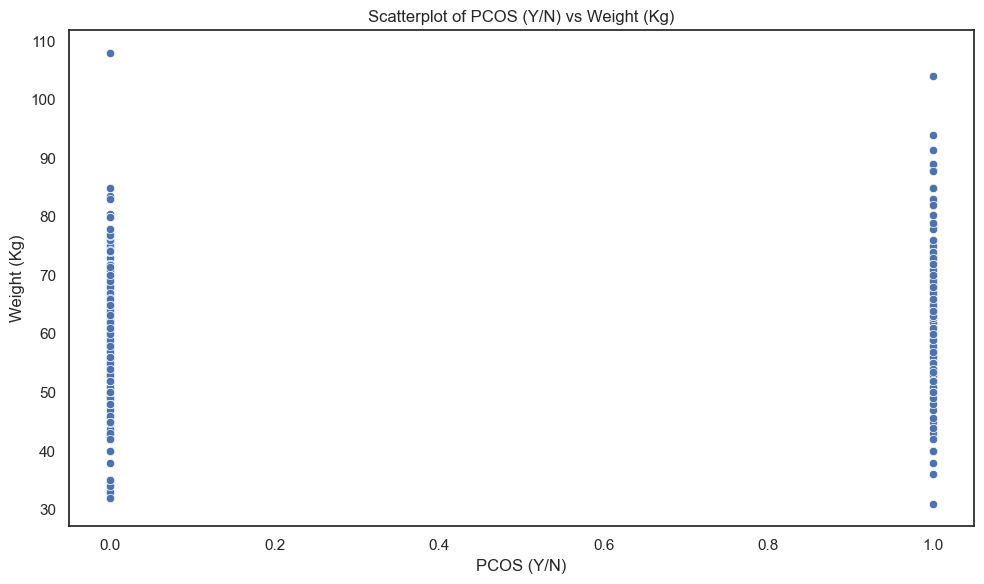


Correlation coefficient between PCOS (Y/N) and Weight (Kg): 0.21


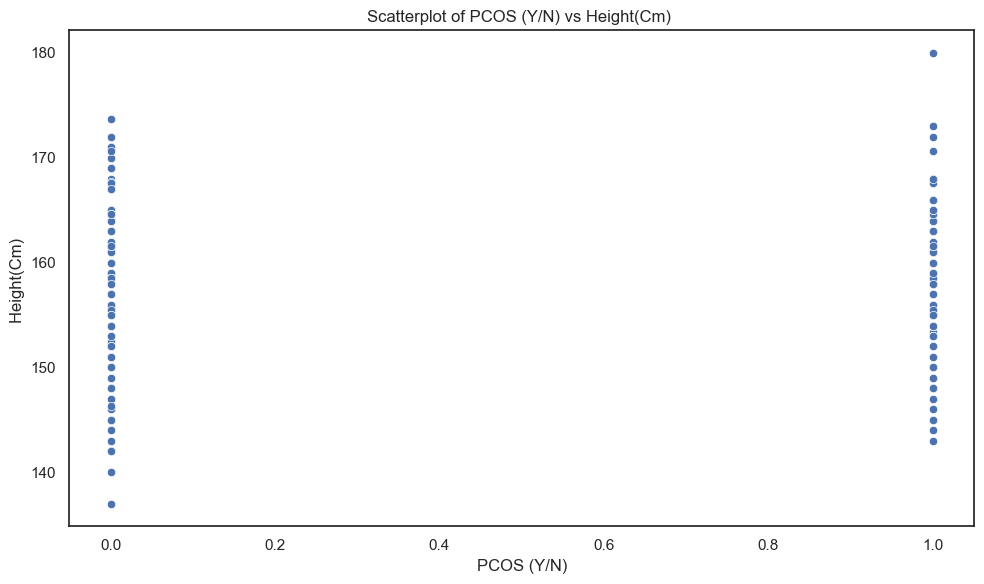


Correlation coefficient between PCOS (Y/N) and Height(Cm) : 0.07


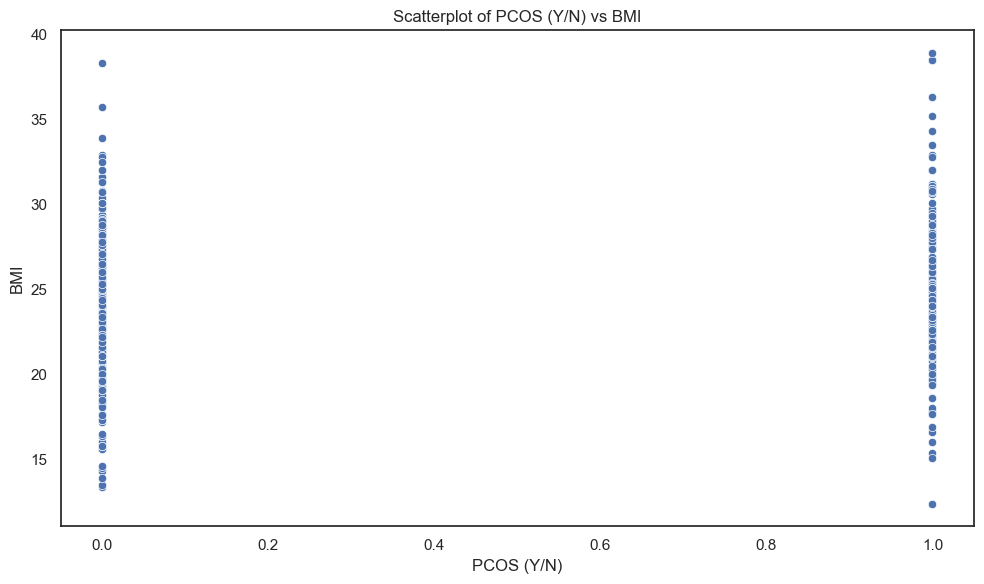


Correlation coefficient between PCOS (Y/N) and BMI: 0.20


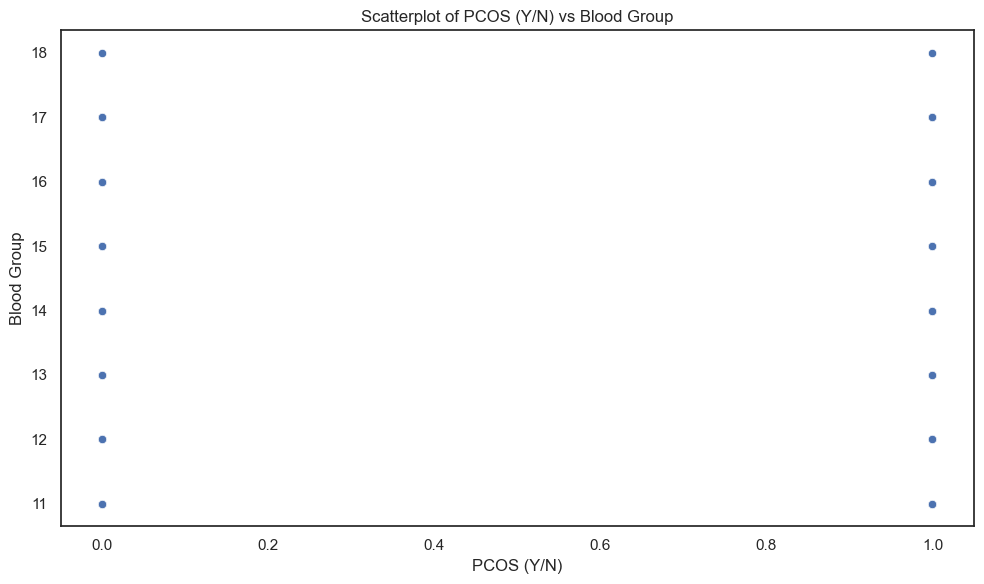


Correlation coefficient between PCOS (Y/N) and Blood Group: 0.04


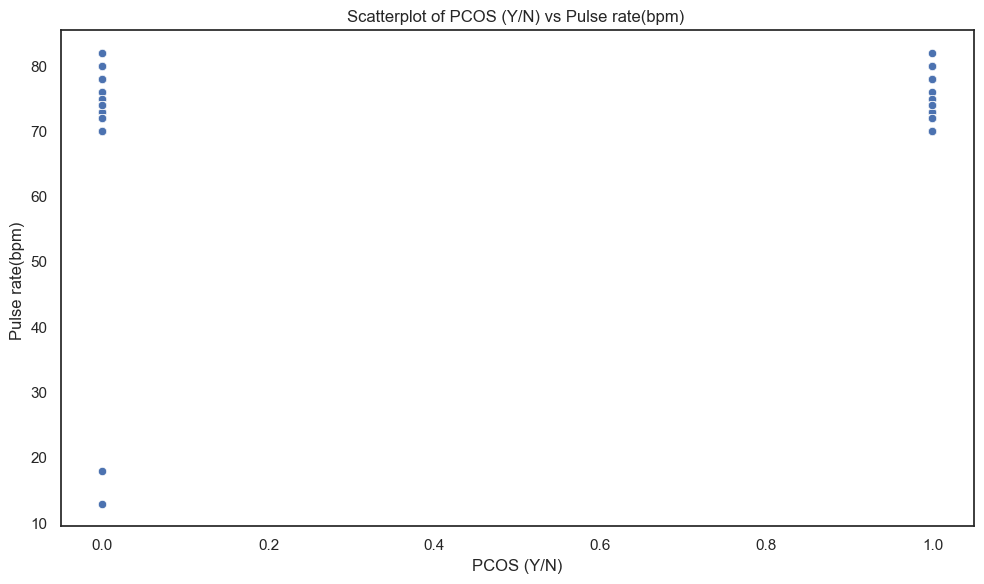


Correlation coefficient between PCOS (Y/N) and Pulse rate(bpm) : 0.09


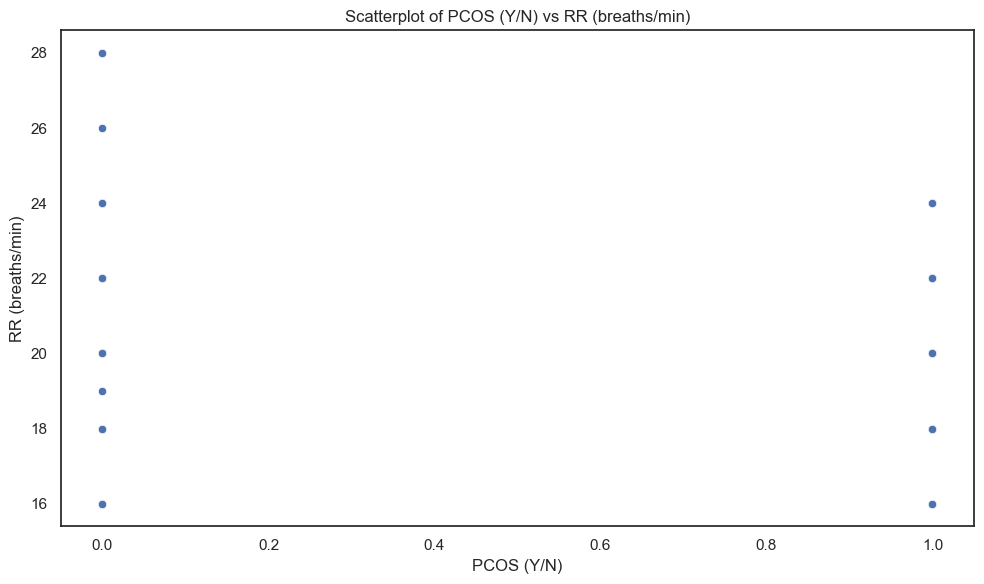


Correlation coefficient between PCOS (Y/N) and RR (breaths/min): 0.04


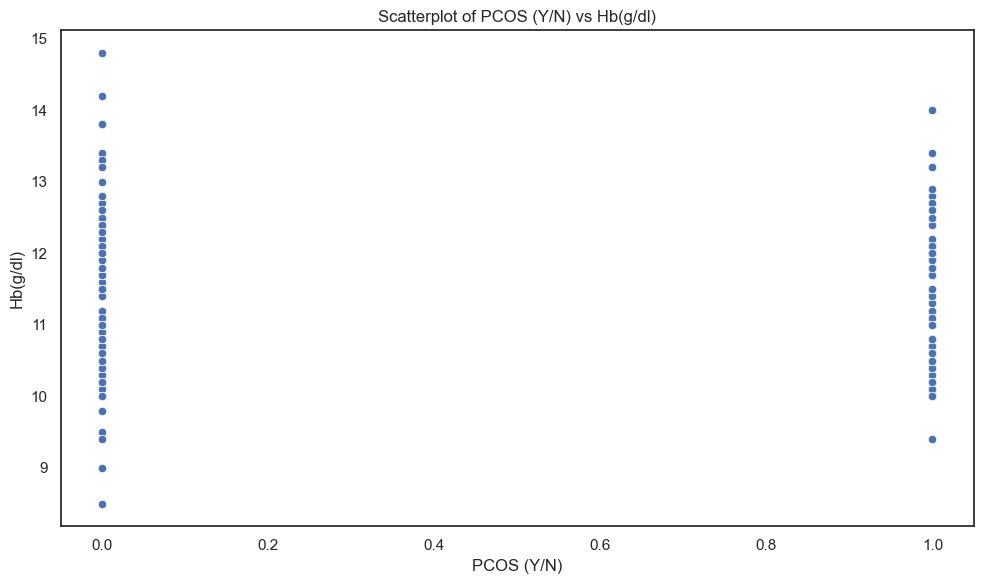


Correlation coefficient between PCOS (Y/N) and Hb(g/dl): 0.09


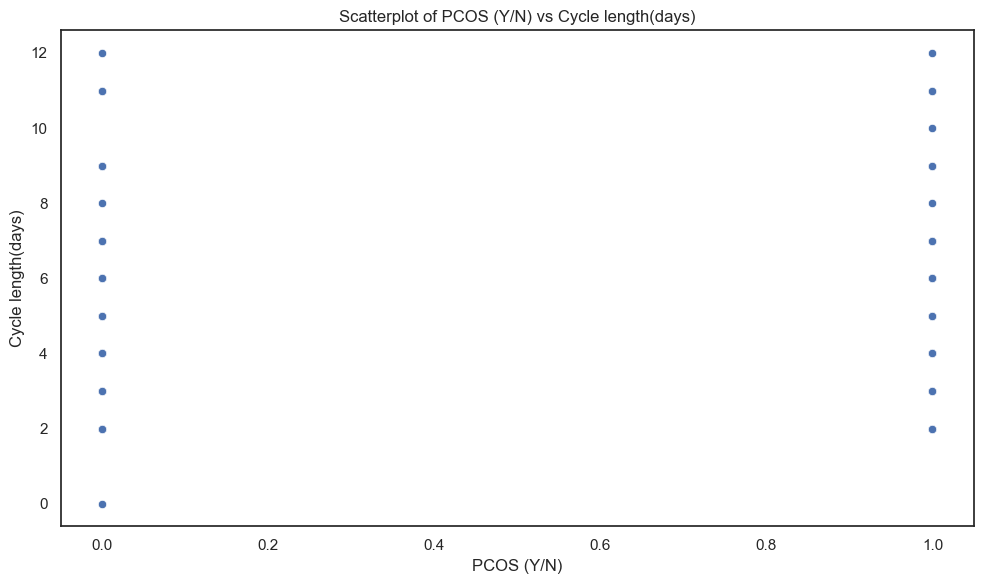


Correlation coefficient between PCOS (Y/N) and Cycle length(days): -0.18


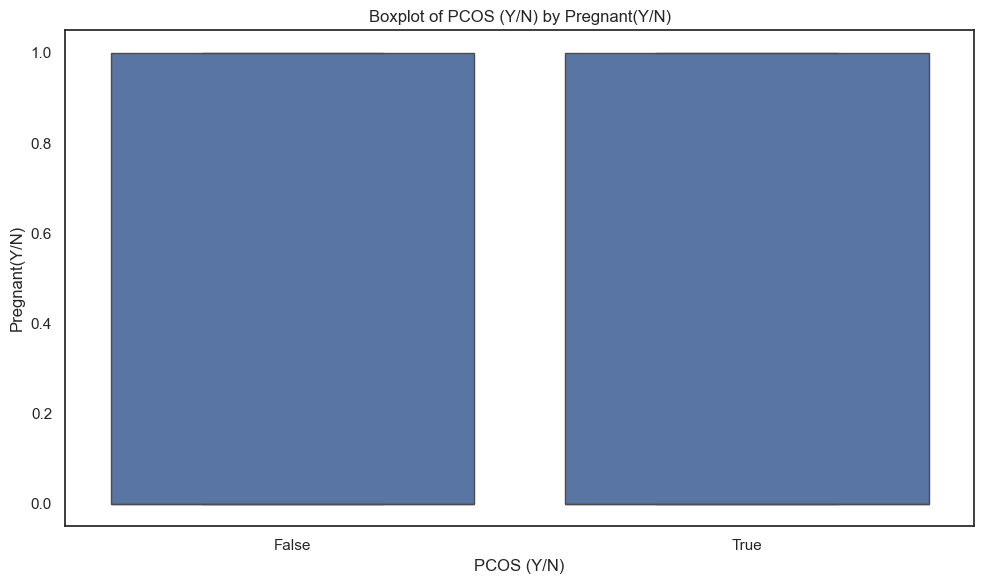

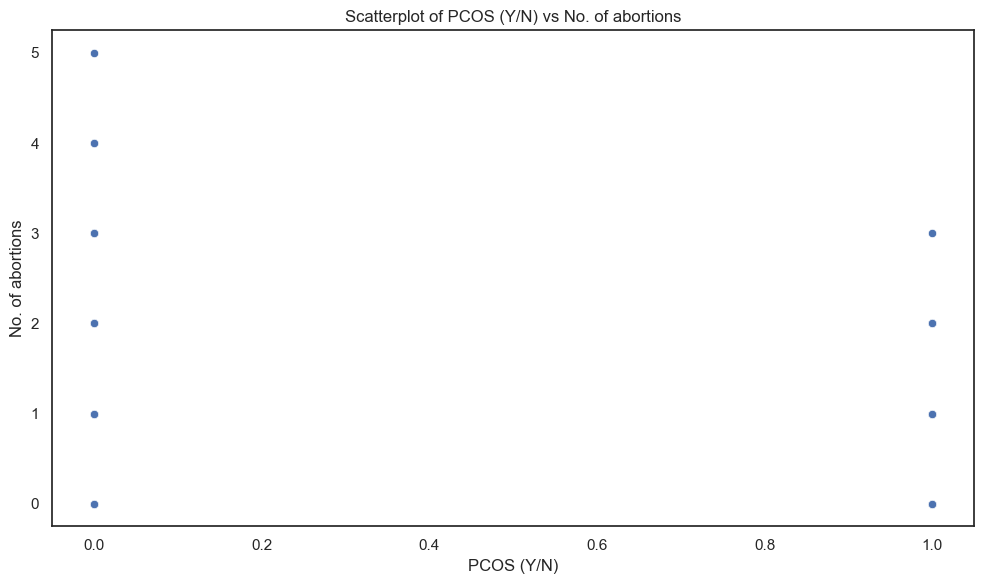


Correlation coefficient between PCOS (Y/N) and No. of abortions: -0.06


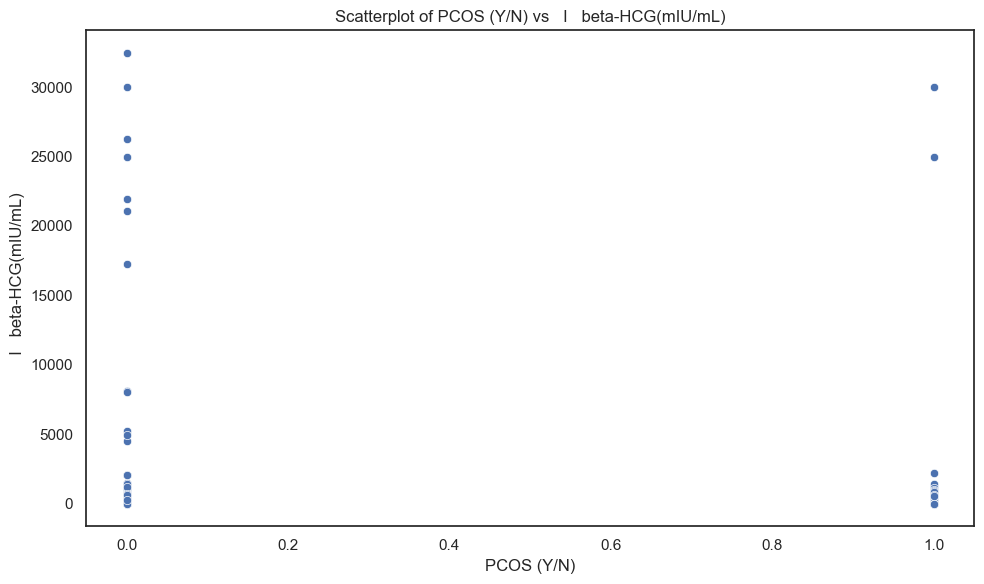


Correlation coefficient between PCOS (Y/N) and   I   beta-HCG(mIU/mL): -0.03


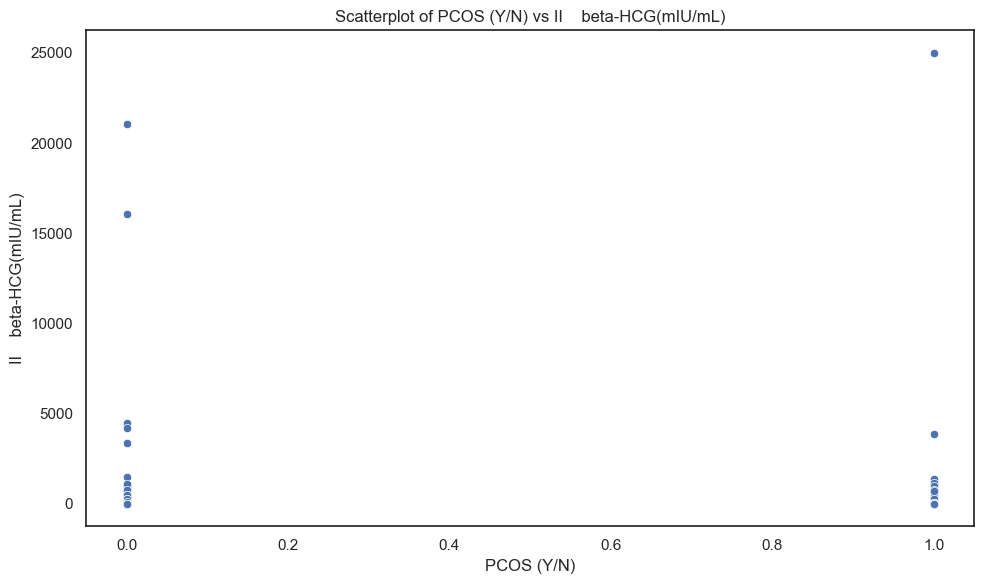


Correlation coefficient between PCOS (Y/N) and II    beta-HCG(mIU/mL): 0.01


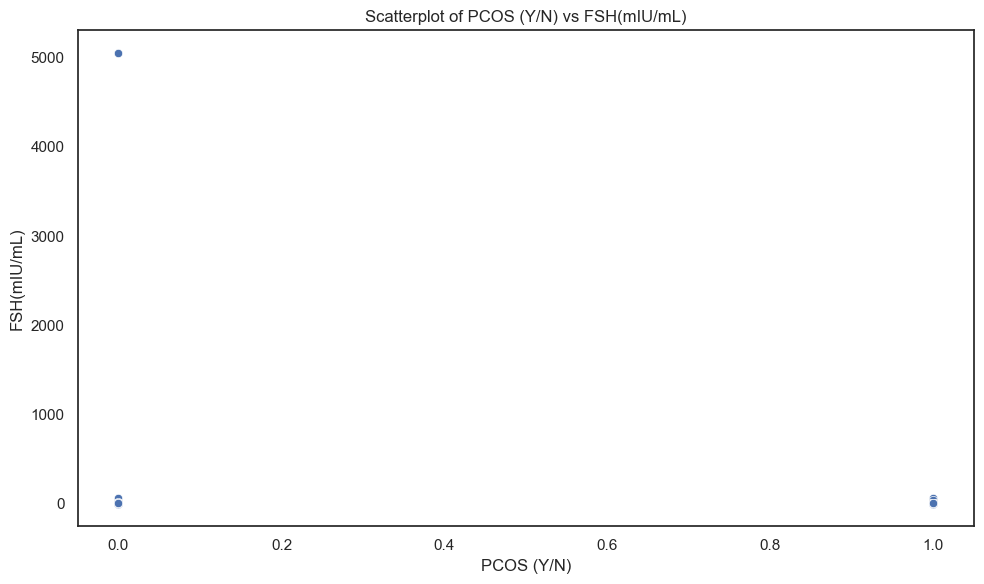


Correlation coefficient between PCOS (Y/N) and FSH(mIU/mL): -0.03


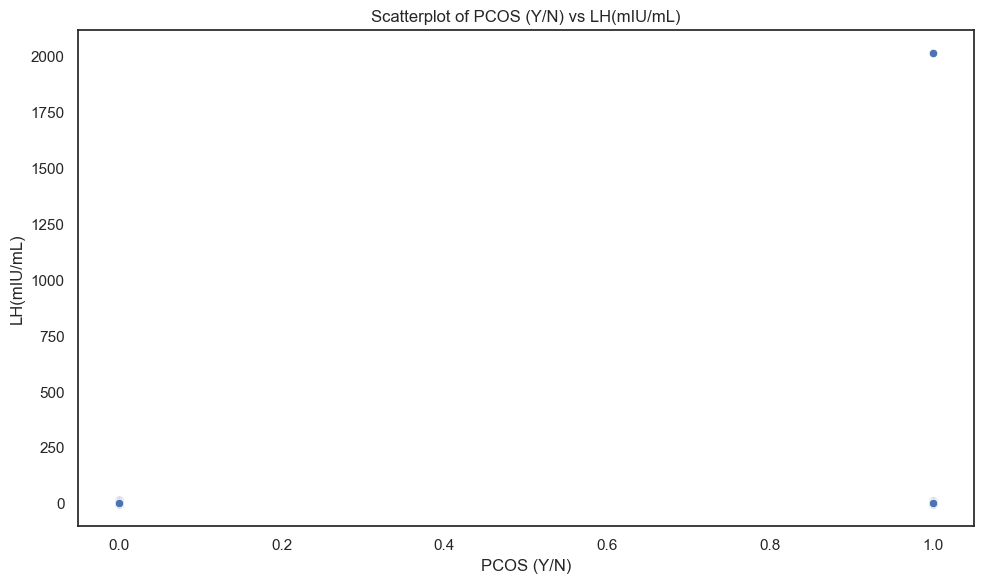


Correlation coefficient between PCOS (Y/N) and LH(mIU/mL): 0.06


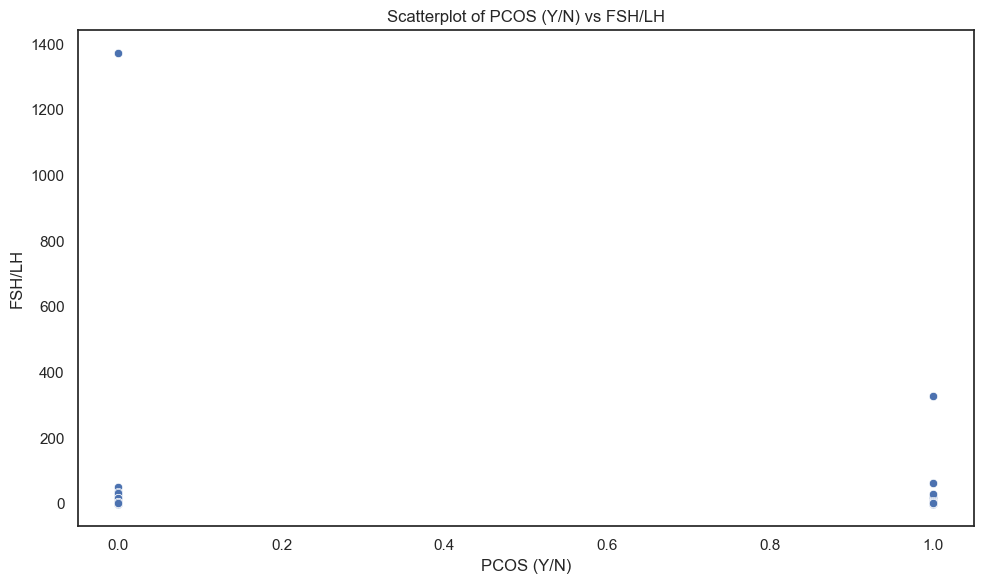


Correlation coefficient between PCOS (Y/N) and FSH/LH: -0.02


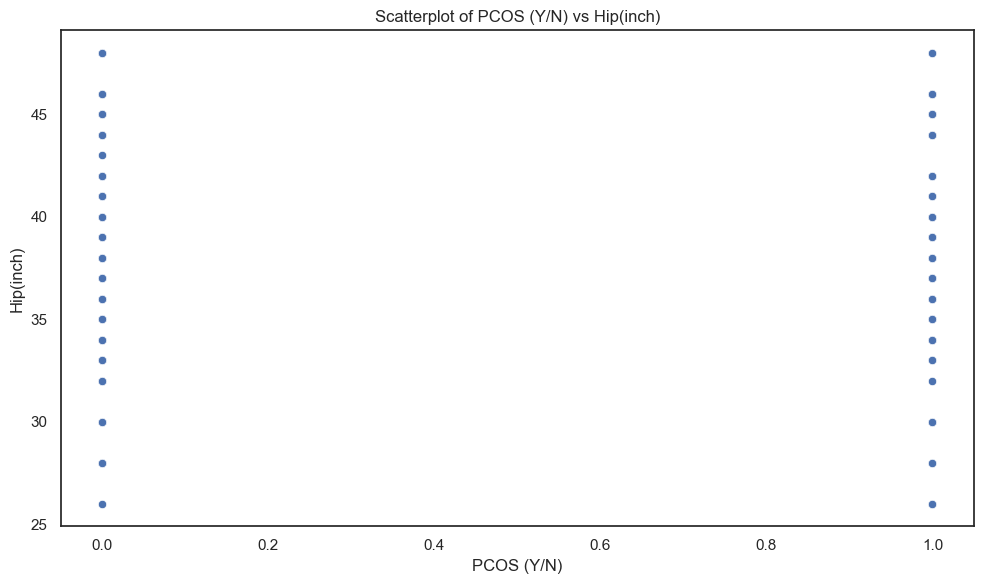


Correlation coefficient between PCOS (Y/N) and Hip(inch): 0.16


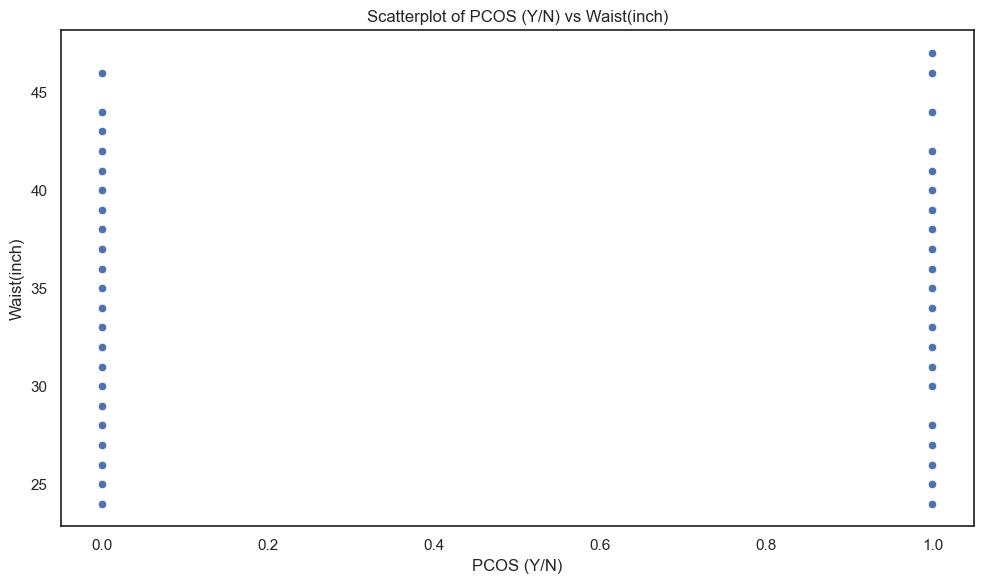


Correlation coefficient between PCOS (Y/N) and Waist(inch): 0.16


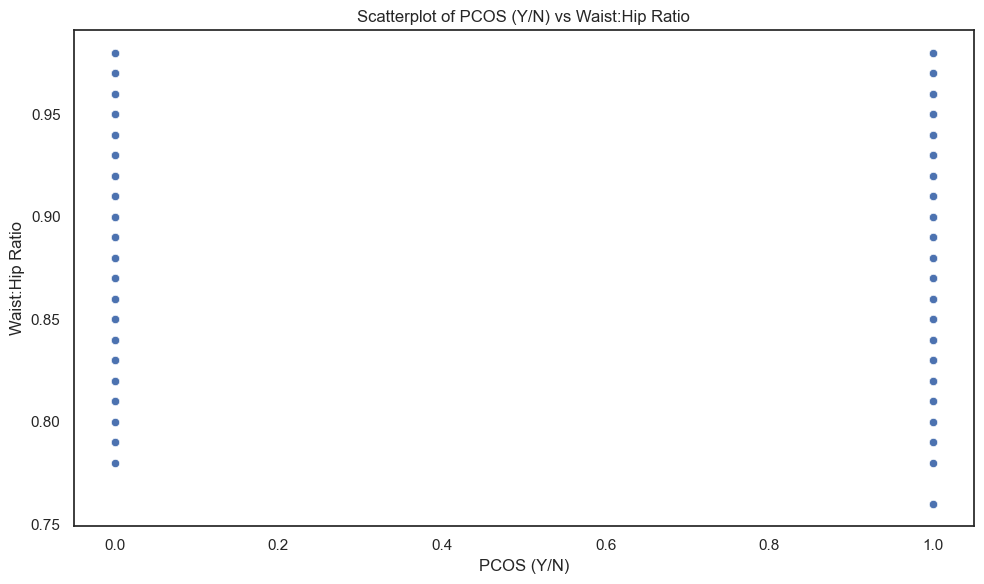


Correlation coefficient between PCOS (Y/N) and Waist:Hip Ratio: 0.01


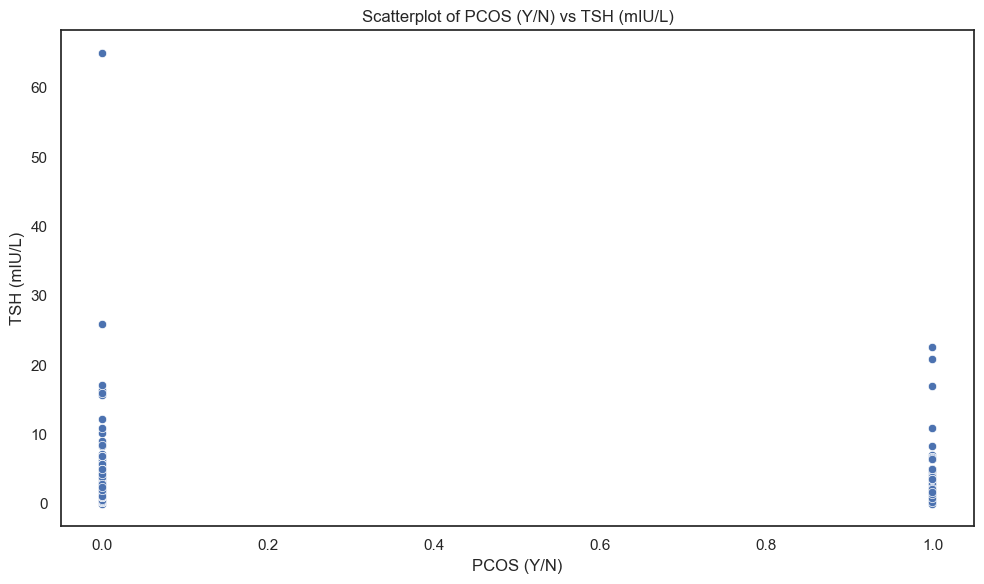


Correlation coefficient between PCOS (Y/N) and TSH (mIU/L): -0.01


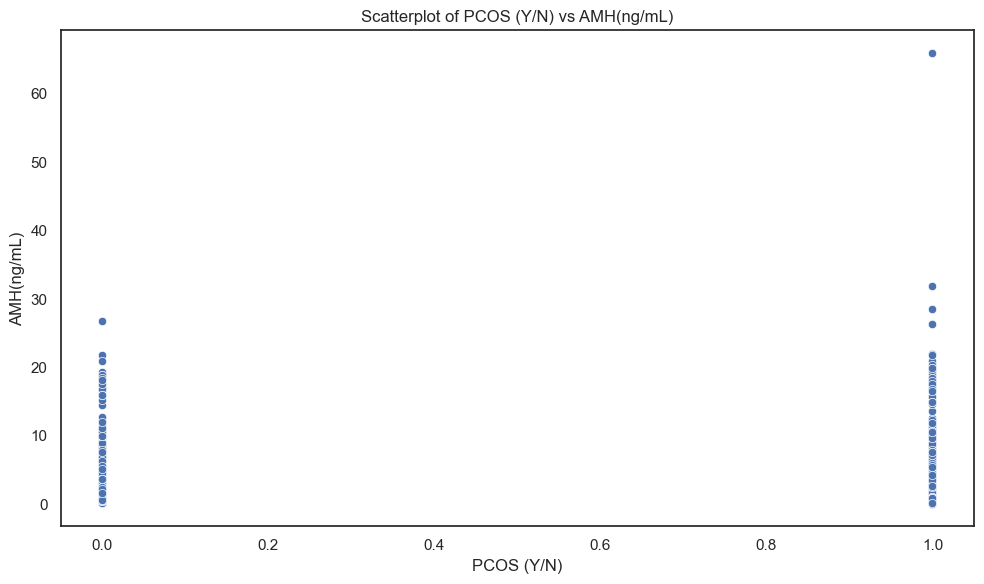


Correlation coefficient between PCOS (Y/N) and AMH(ng/mL): 0.26


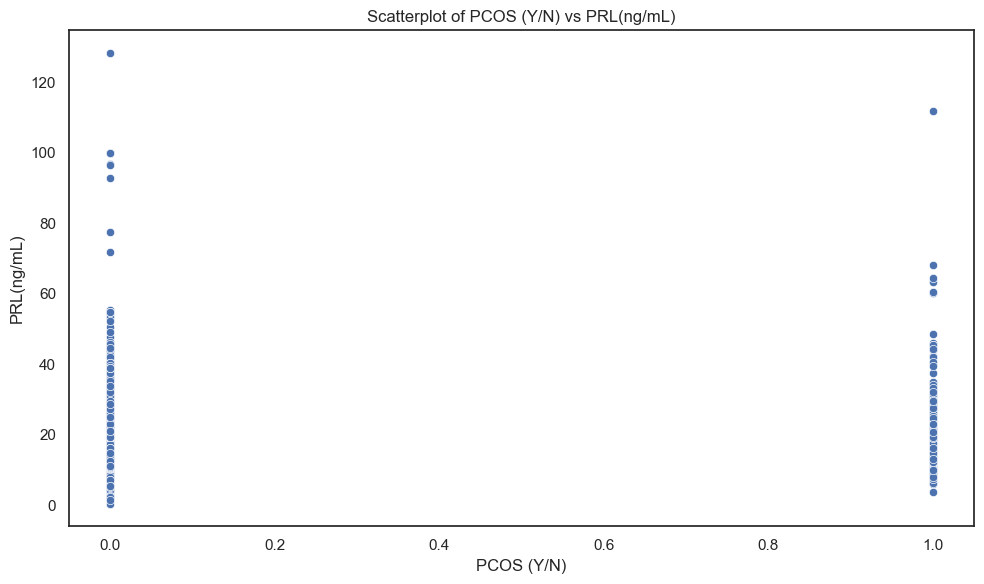


Correlation coefficient between PCOS (Y/N) and PRL(ng/mL): 0.01


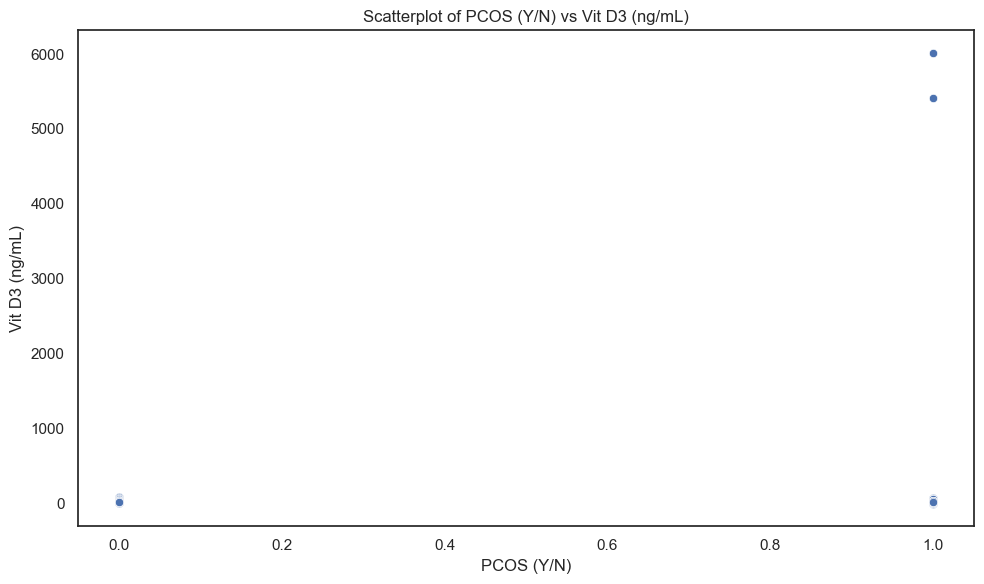


Correlation coefficient between PCOS (Y/N) and Vit D3 (ng/mL): 0.09


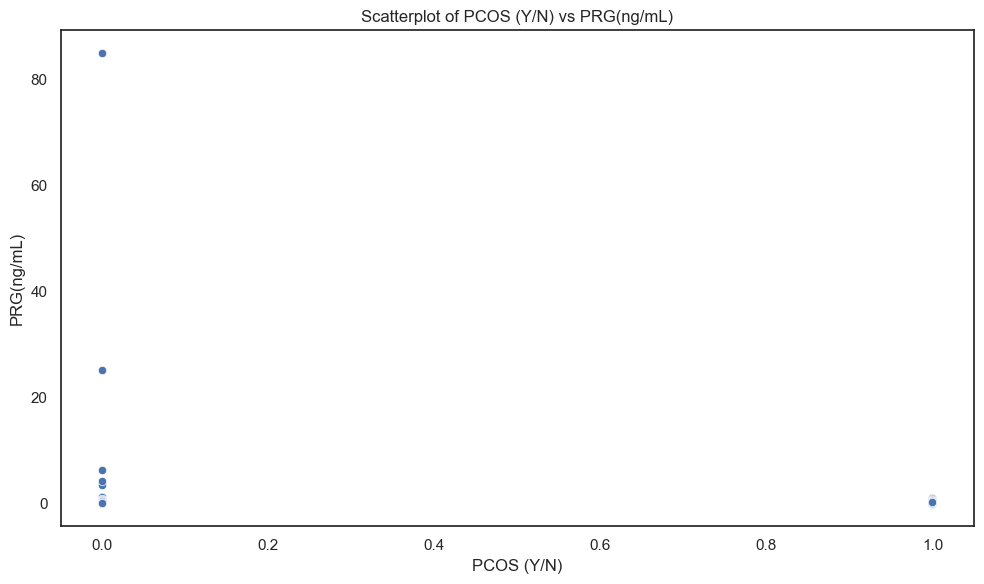


Correlation coefficient between PCOS (Y/N) and PRG(ng/mL): -0.04


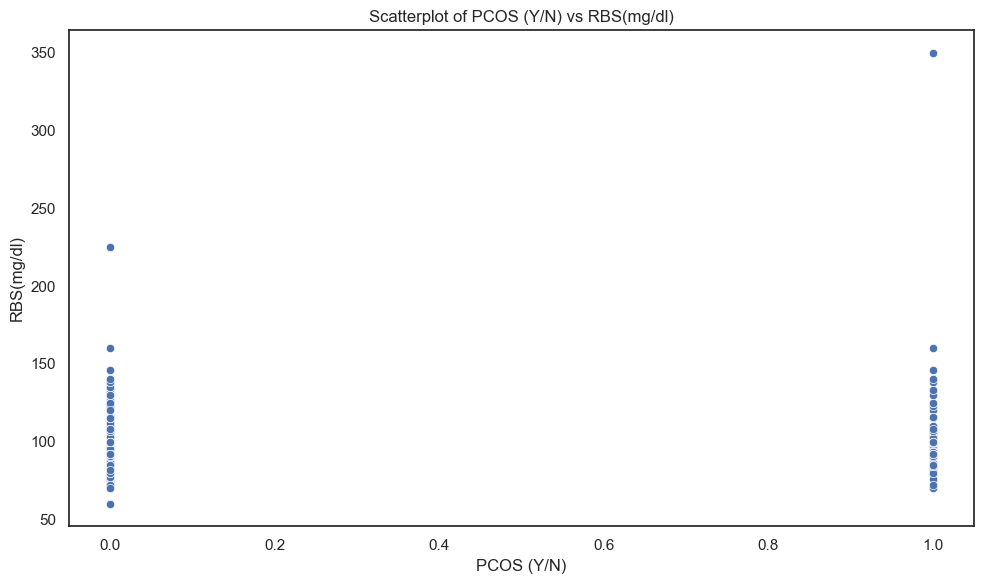


Correlation coefficient between PCOS (Y/N) and RBS(mg/dl): 0.05


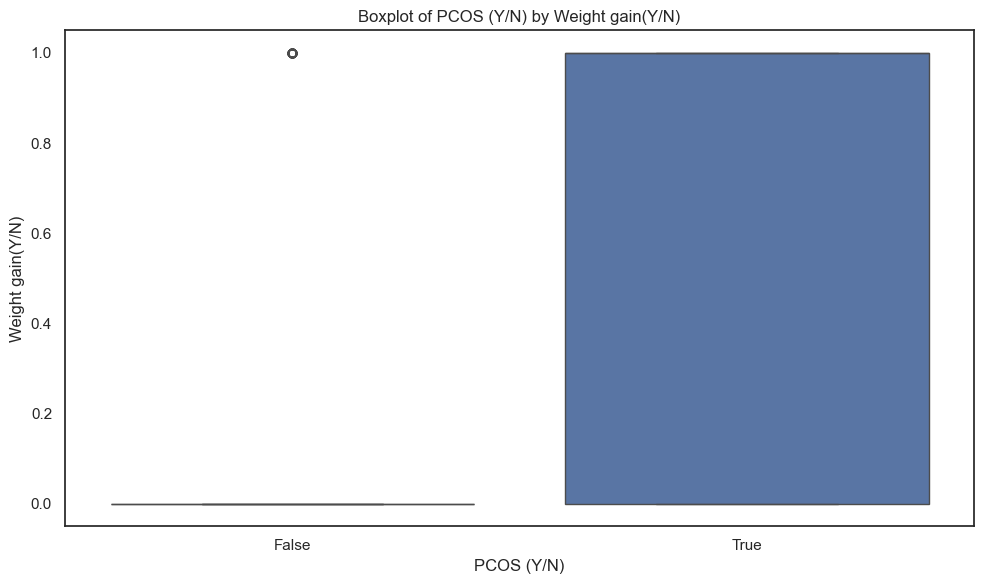

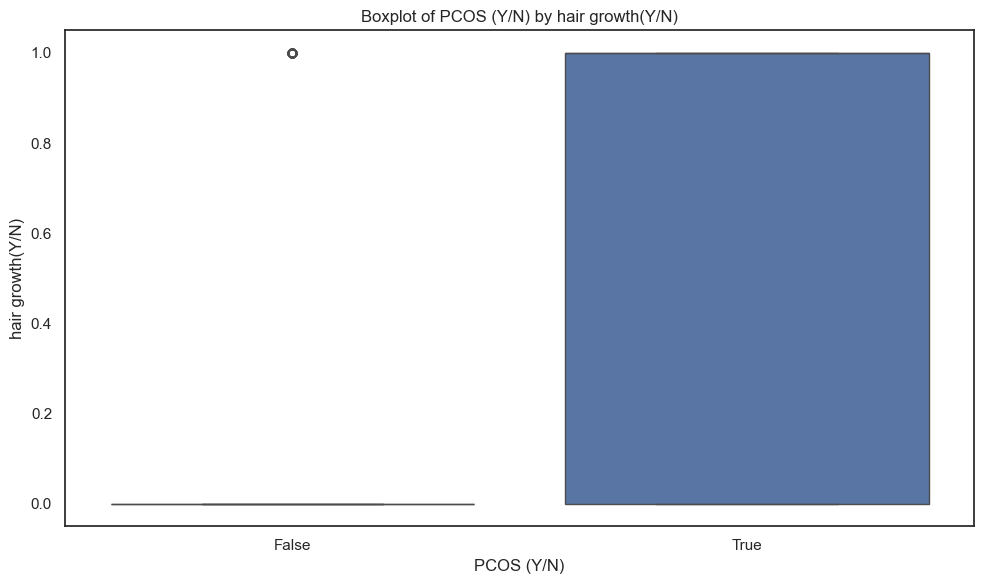

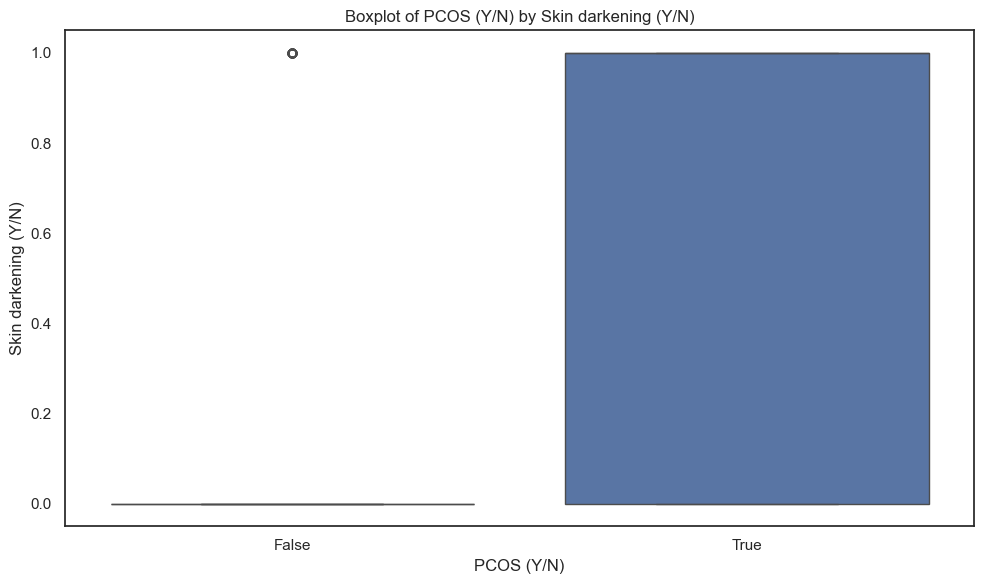

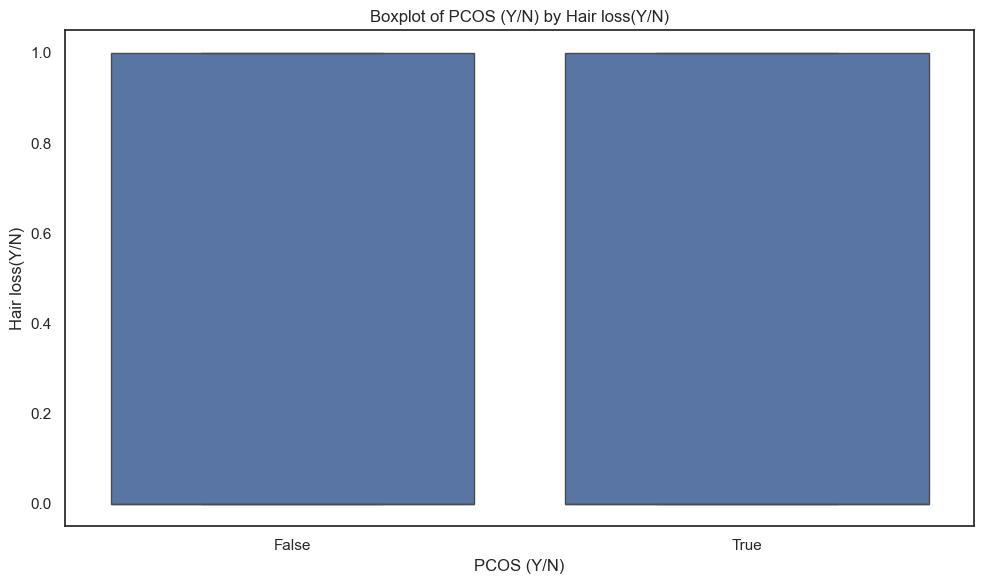

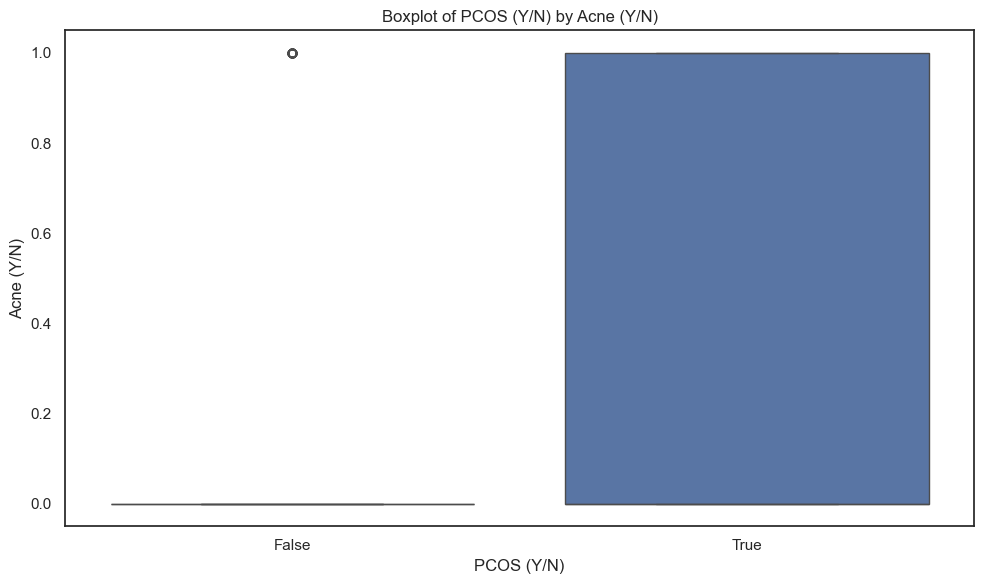

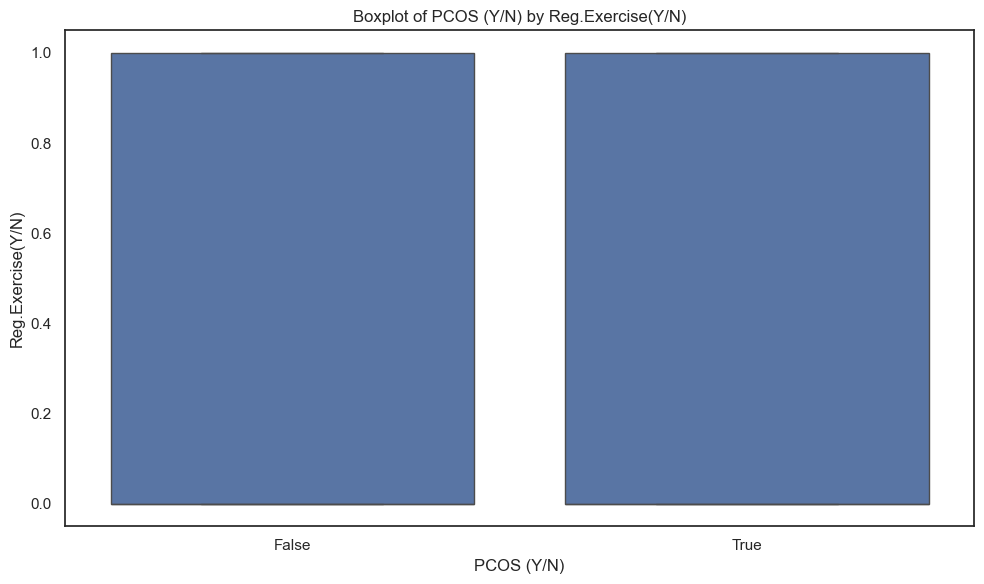

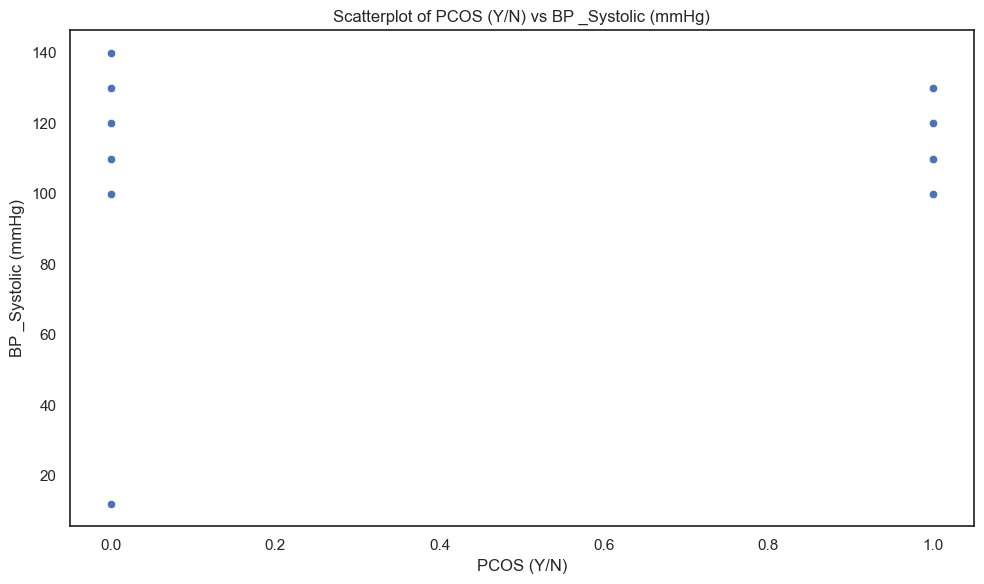


Correlation coefficient between PCOS (Y/N) and BP _Systolic (mmHg): 0.01


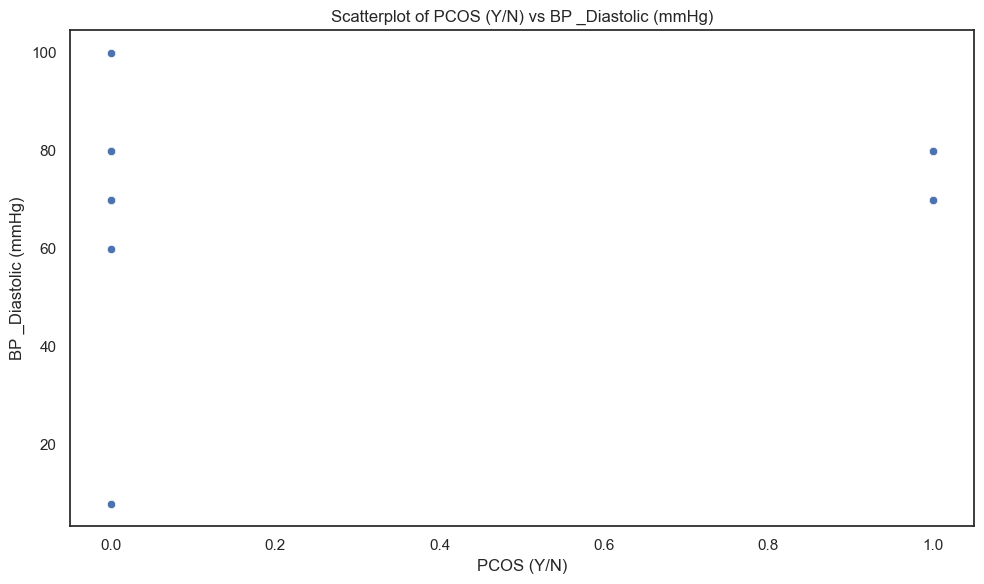


Correlation coefficient between PCOS (Y/N) and BP _Diastolic (mmHg): 0.04


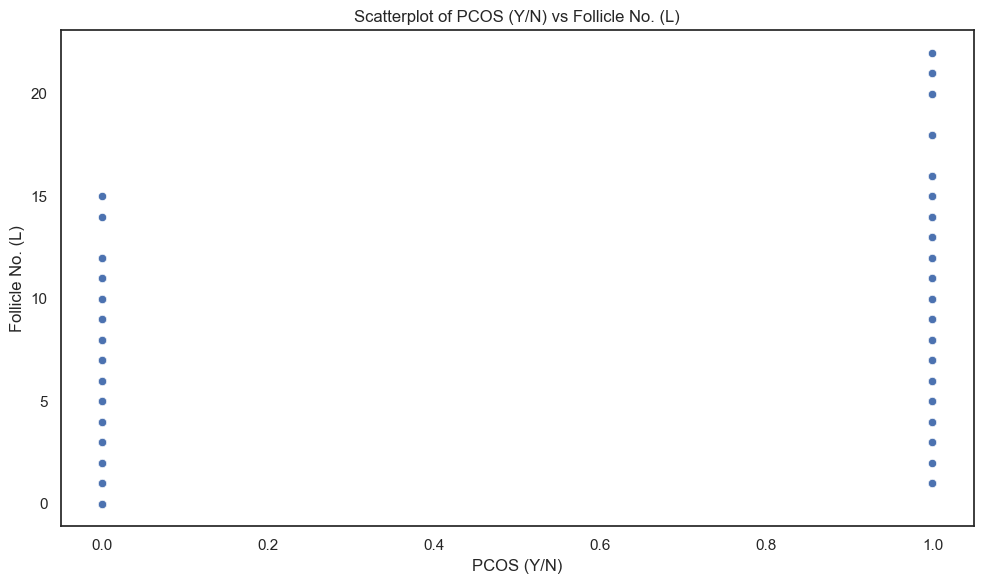


Correlation coefficient between PCOS (Y/N) and Follicle No. (L): 0.60


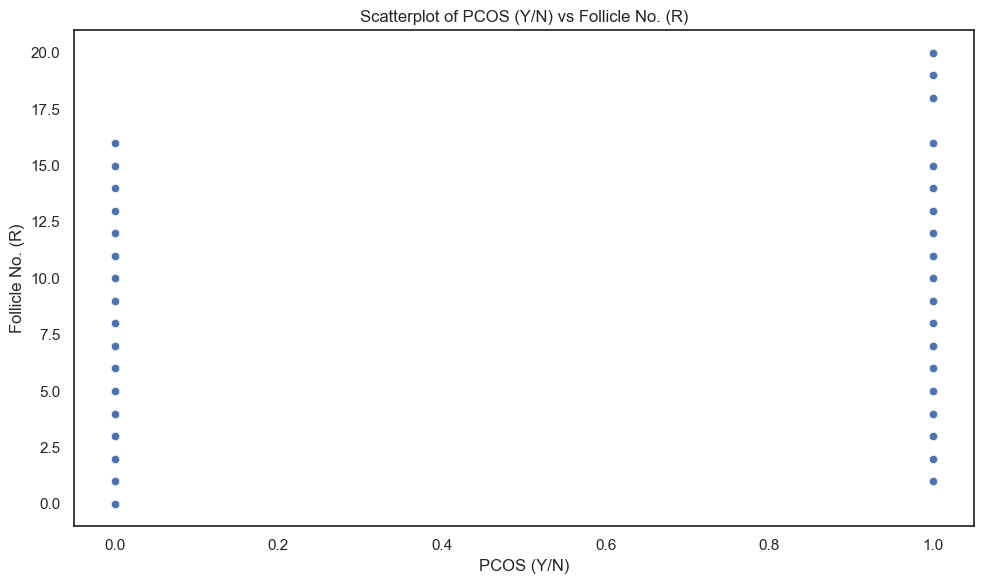


Correlation coefficient between PCOS (Y/N) and Follicle No. (R): 0.65


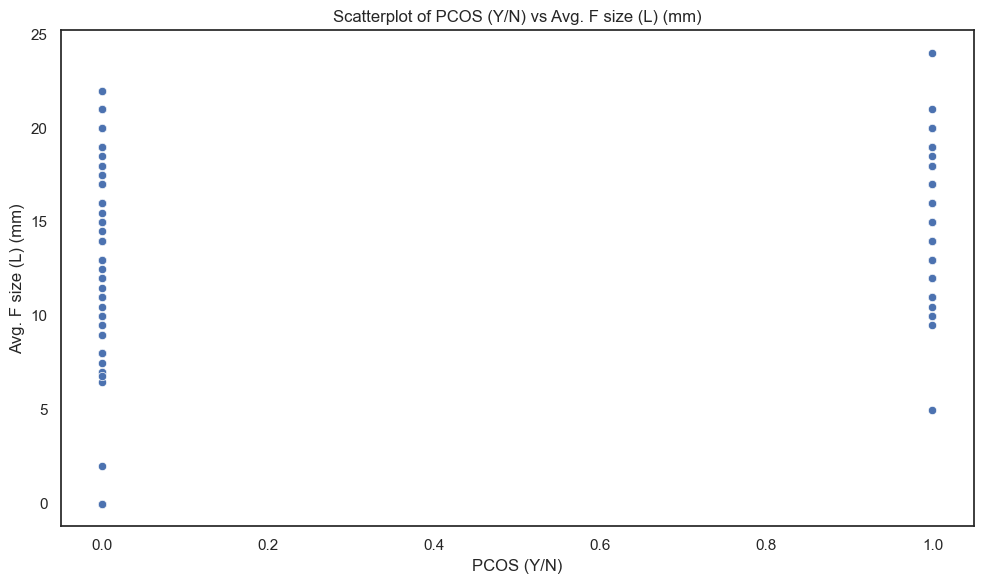


Correlation coefficient between PCOS (Y/N) and Avg. F size (L) (mm): 0.13


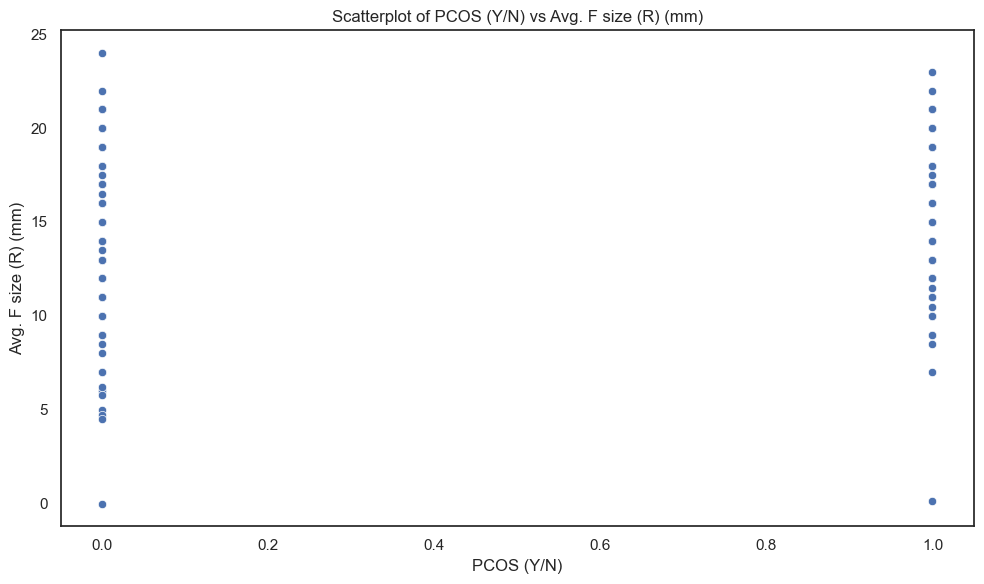


Correlation coefficient between PCOS (Y/N) and Avg. F size (R) (mm): 0.10


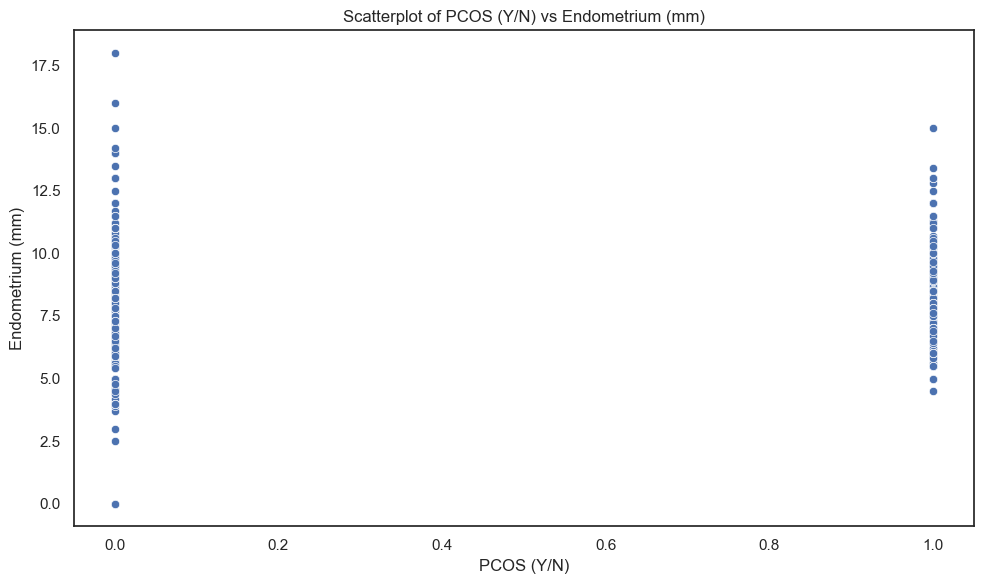


Correlation coefficient between PCOS (Y/N) and Endometrium (mm): 0.11


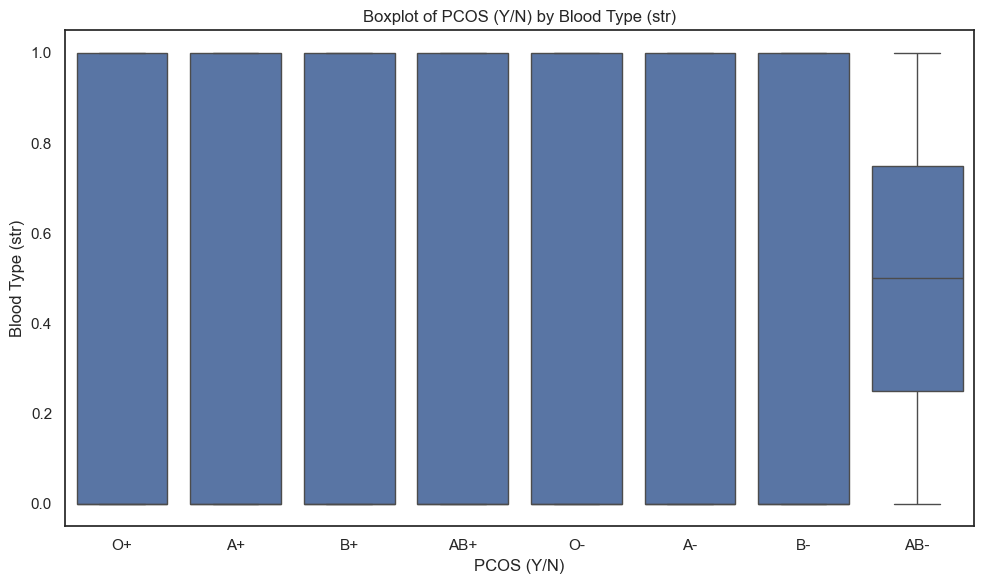

In [836]:
def bivariate_analysis(df, x_column, y_column):
    plt.figure(figsize=(10, 6))
    
    if df[x_column].dtype == 'object' or df[x_column].dtype == 'bool':
        if df[y_column].dtype == 'object' or df[y_column].dtype == 'bool':
            # Both variables are categorical
            sns.heatmap(pd.crosstab(df[x_column], df[y_column], normalize='index'), annot=True, cmap='YlGnBu')
            plt.title(f'Heatmap of {x_column} vs {y_column}')
        else:
            # x is categorical, y is numerical
            sns.boxplot(x=x_column, y=y_column, data=df)
            plt.title(f'Boxplot of {y_column} by {x_column}')
    else:
        if df[y_column].dtype == 'object' or df[y_column].dtype == 'bool':
            # x is numerical, y is categorical
            sns.boxplot(x=y_column, y=x_column, data=df)
            plt.title(f'Boxplot of {x_column} by {y_column}')
        else:
            # Both variables are numerical
            sns.scatterplot(x=x_column, y=y_column, data=df)
            plt.title(f'Scatterplot of {x_column} vs {y_column}')
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.tight_layout()
    plt.show()
    
    # Print correlation coefficient for numerical variables
    if df[x_column].dtype != 'object' and df[x_column].dtype != 'bool' and df[y_column].dtype != 'object' and df[y_column].dtype != 'bool':
        correlation = df[x_column].corr(df[y_column])
        print(f"\nCorrelation coefficient between {x_column} and {y_column}: {correlation:.2f}")

# Example usage:
# bivariate_analysis(df, 'BMI', 'PCOS (Y/N)')

# Perform bivariate analysis for PCOS (Y/N) with other columns
for column in df.columns:
    if column != 'PCOS (Y/N)':
        bivariate_analysis(df, 'PCOS (Y/N)', column)


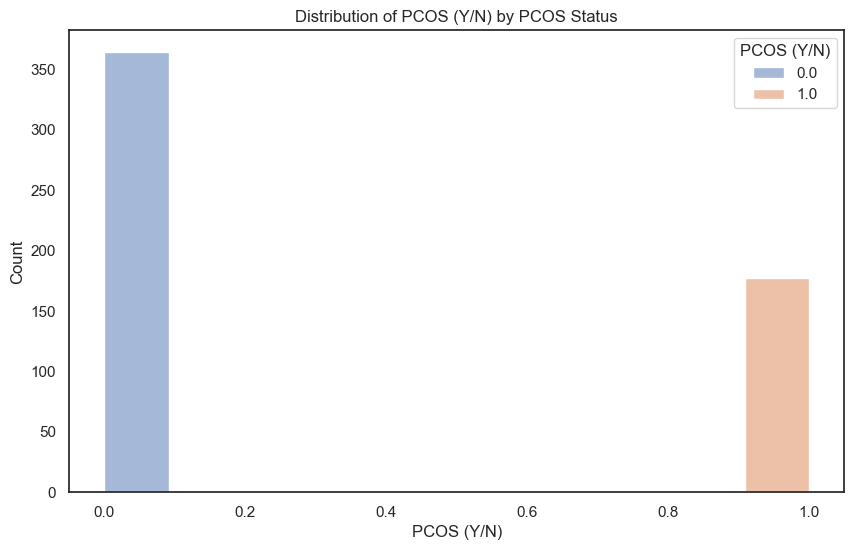

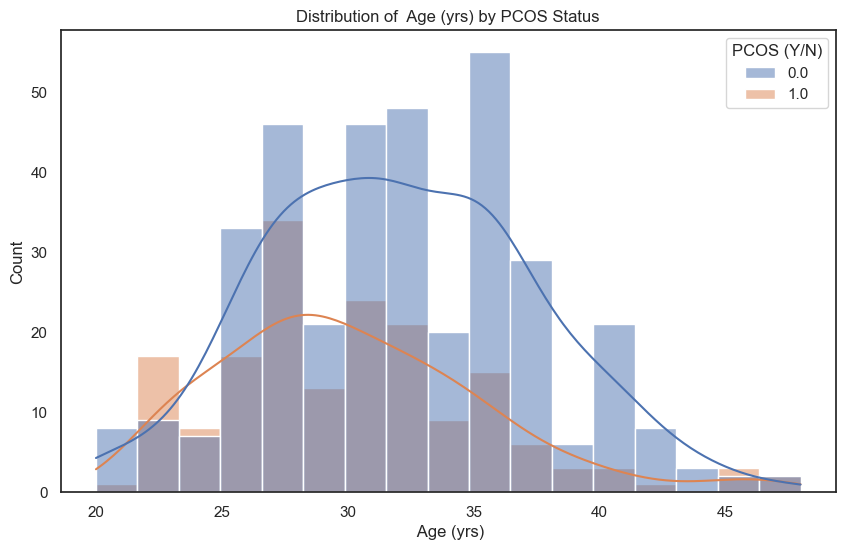

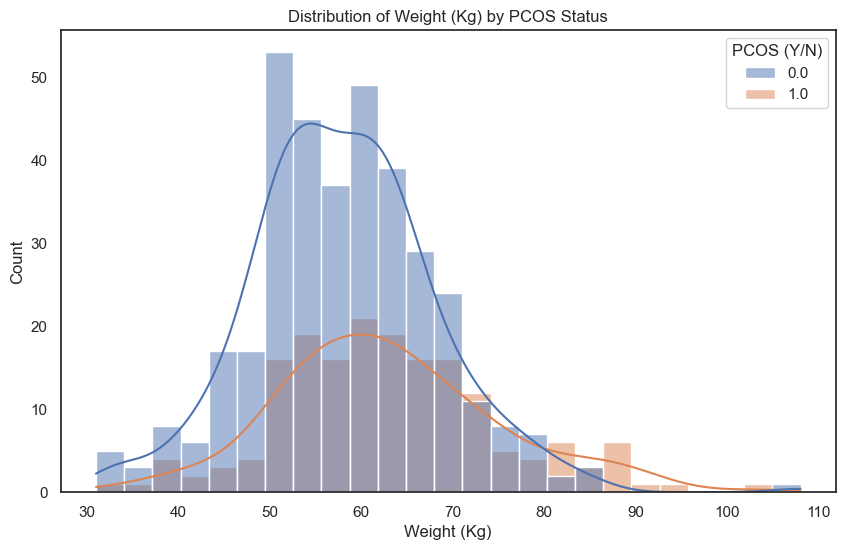

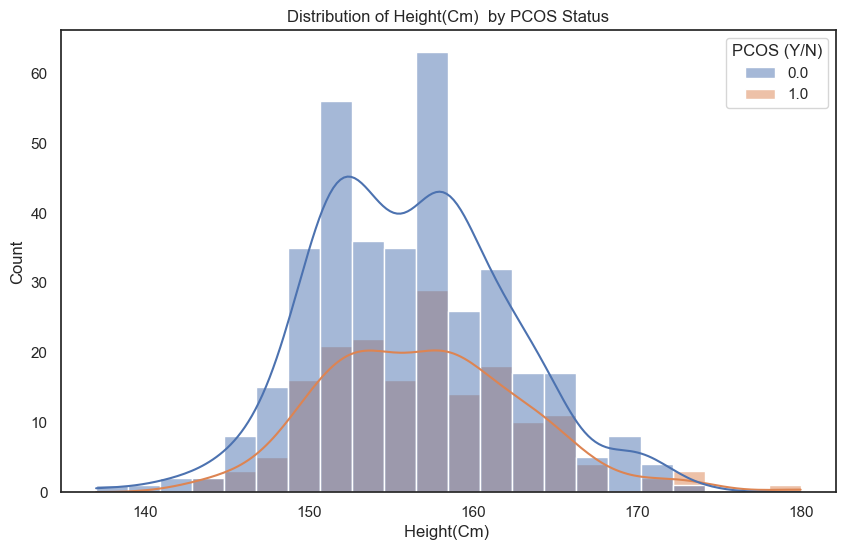

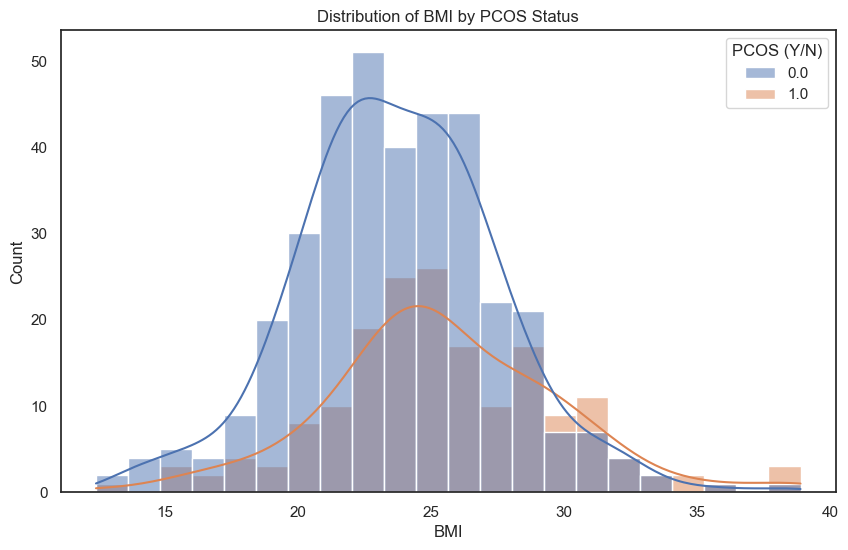

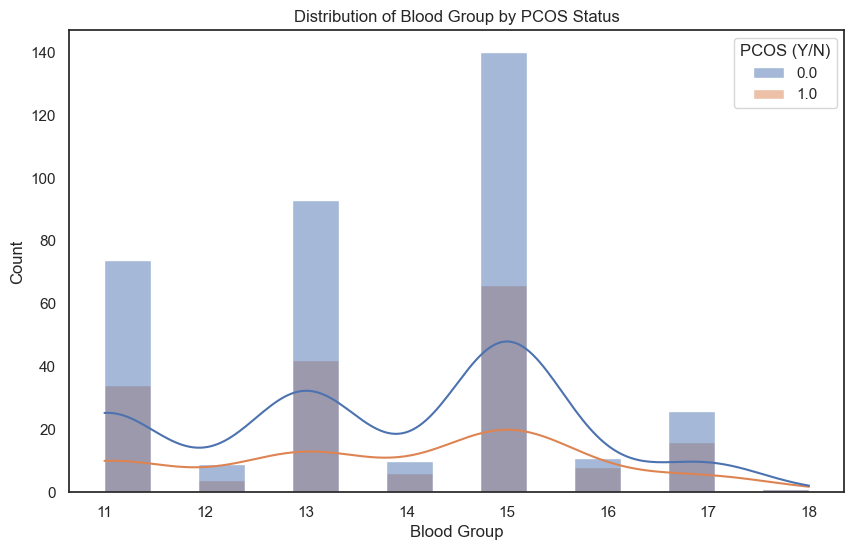

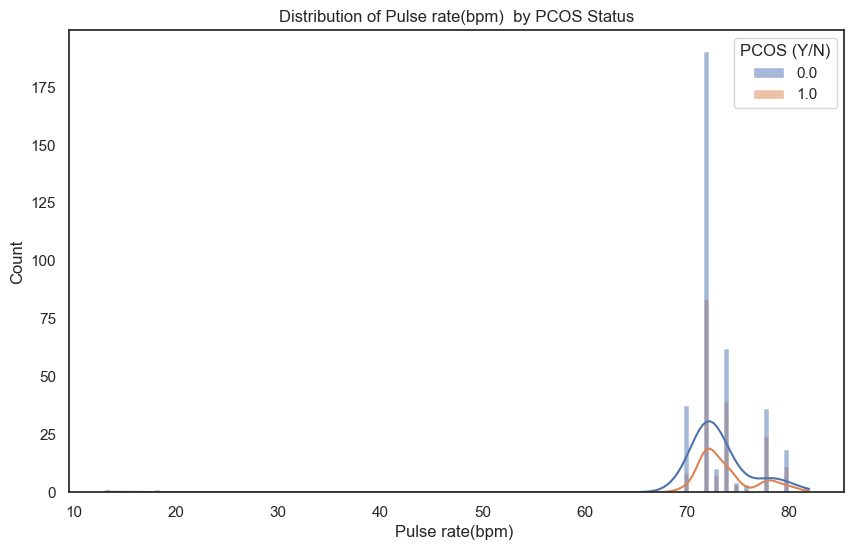

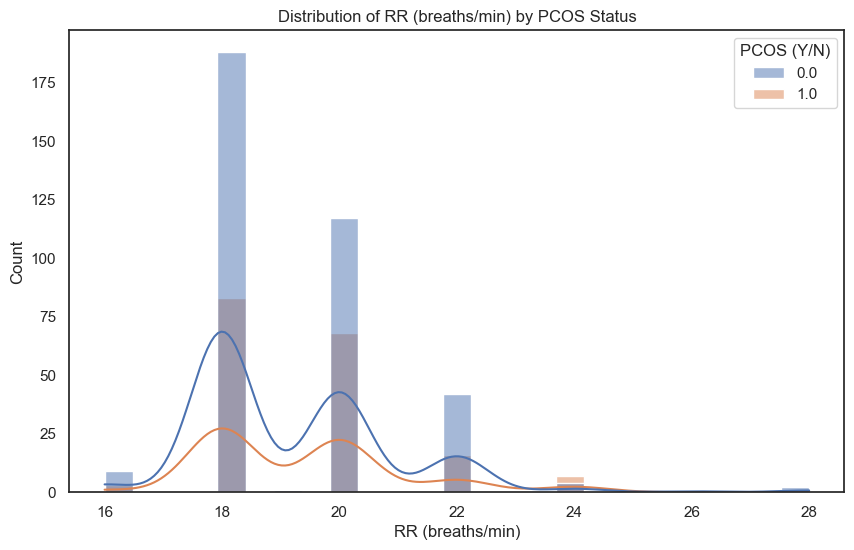

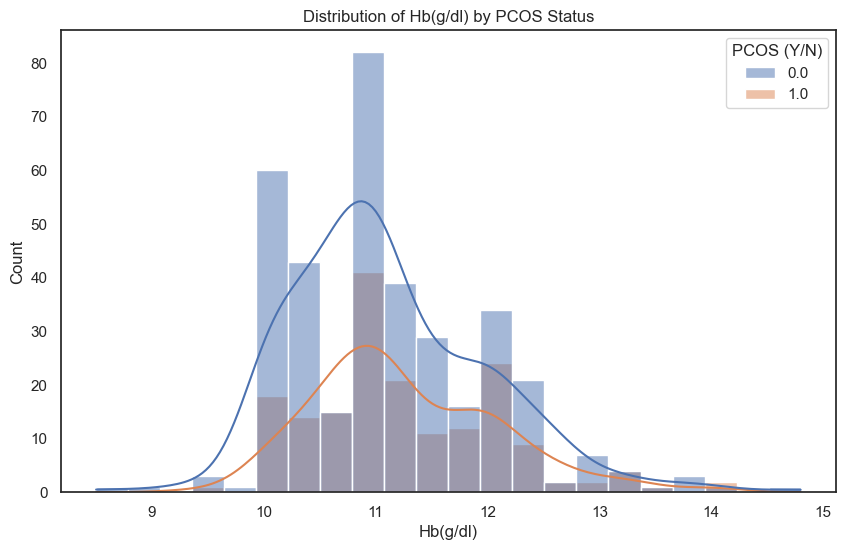

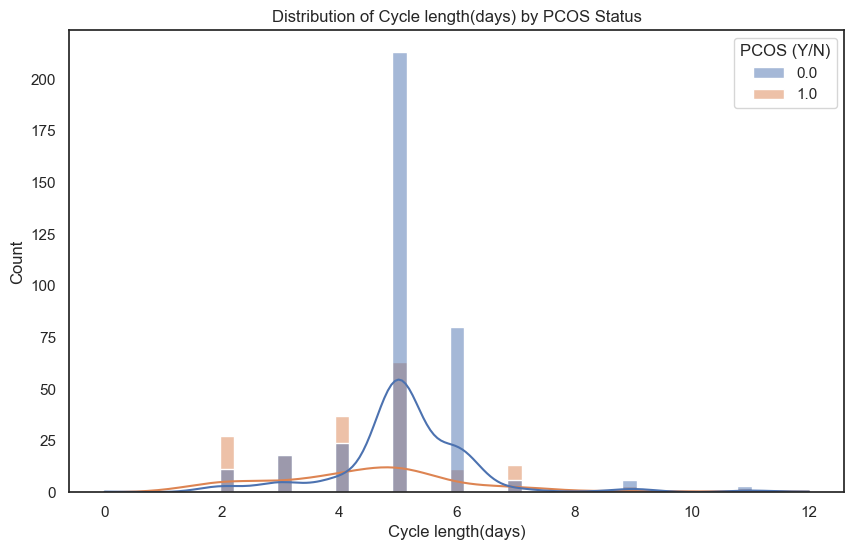

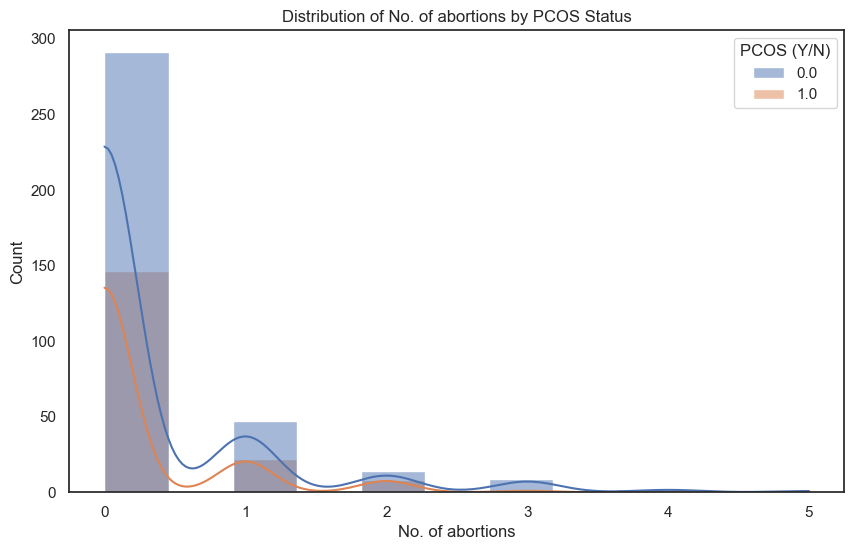

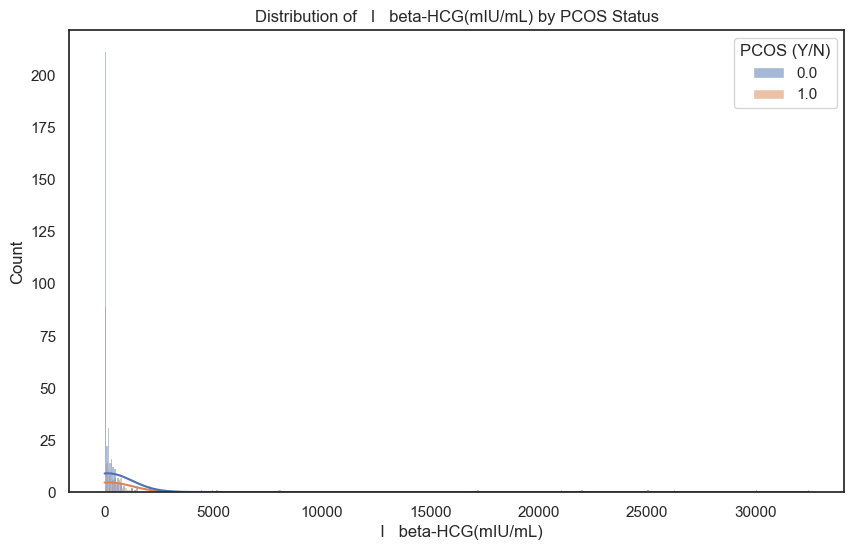

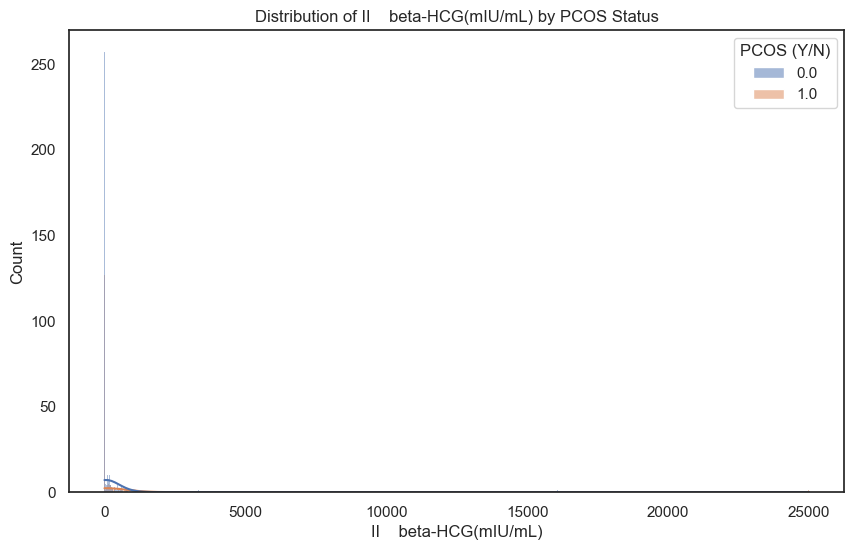

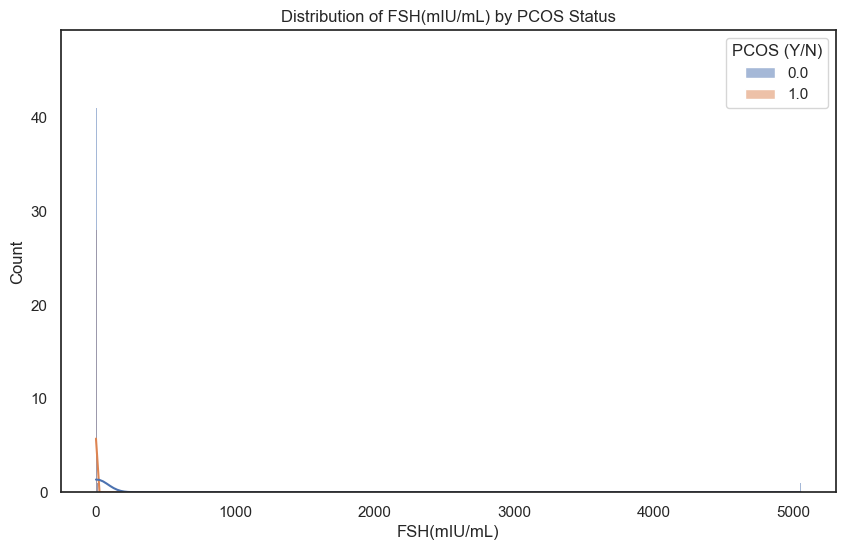

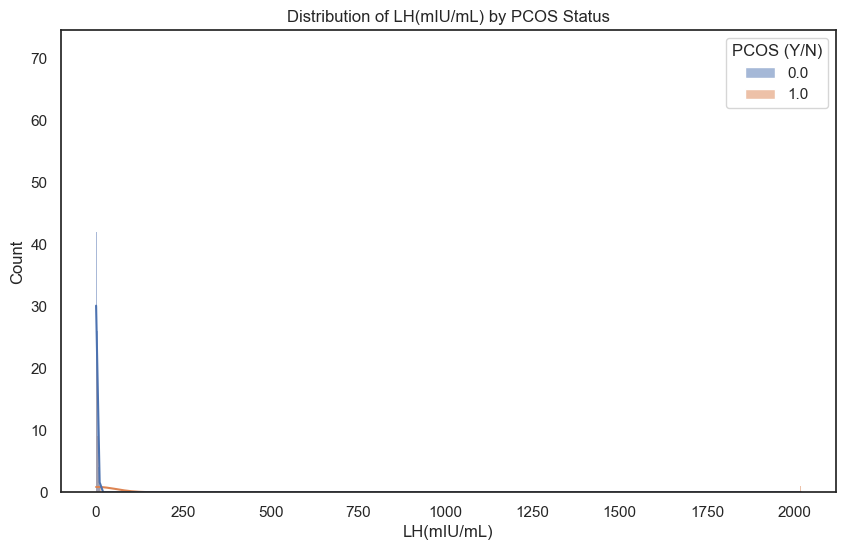

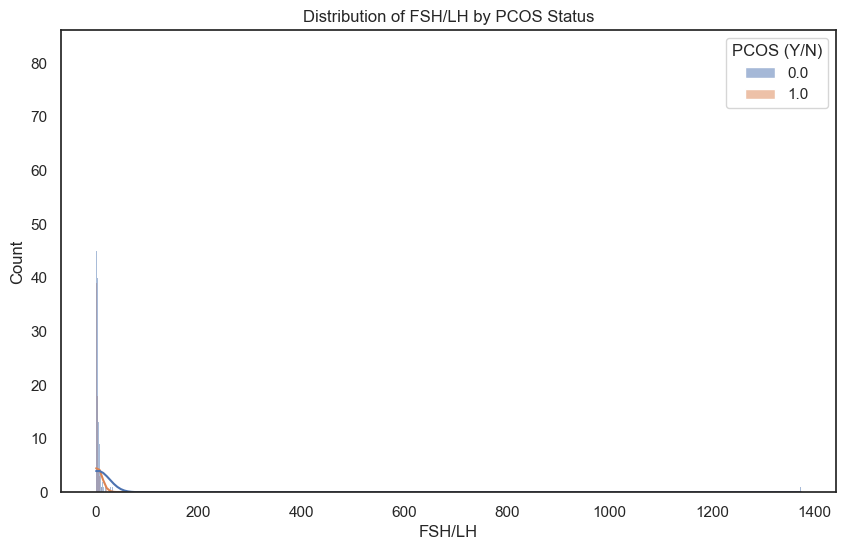

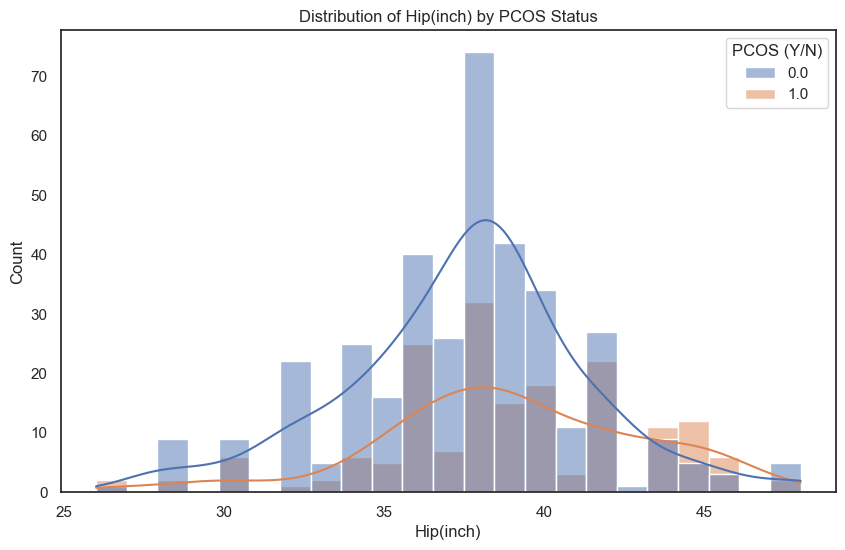

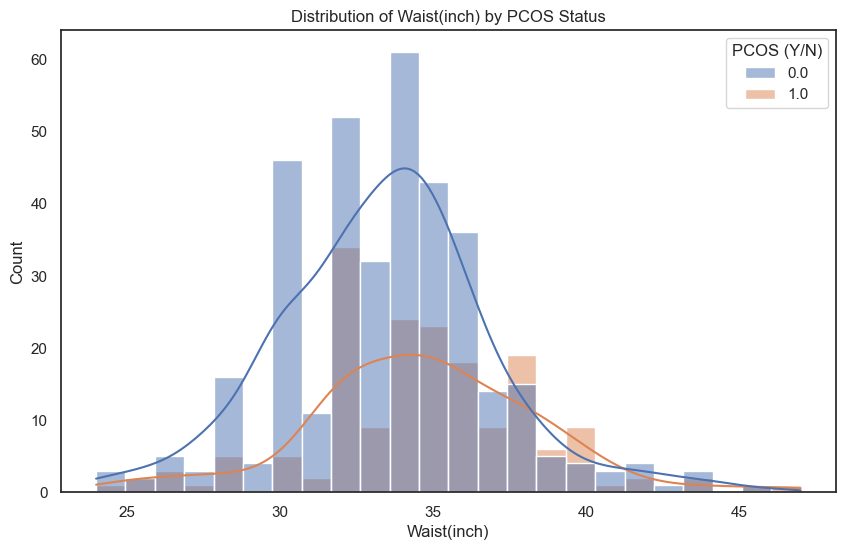

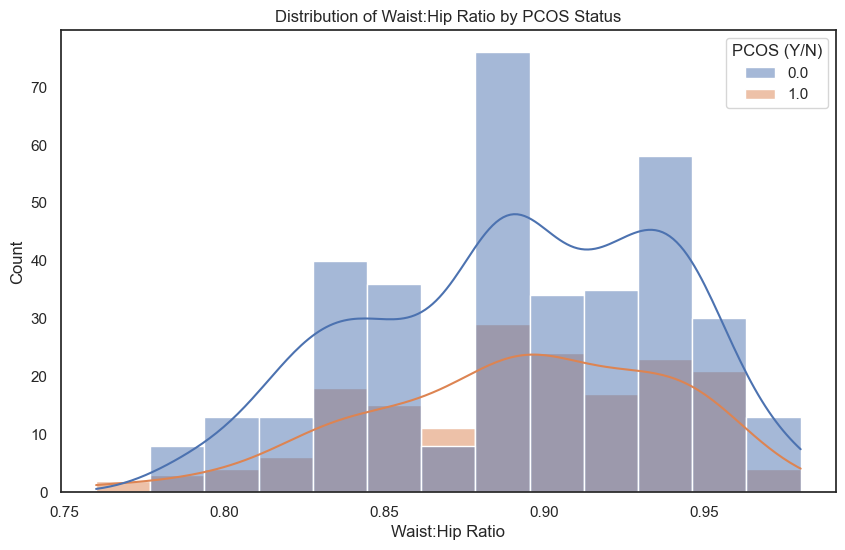

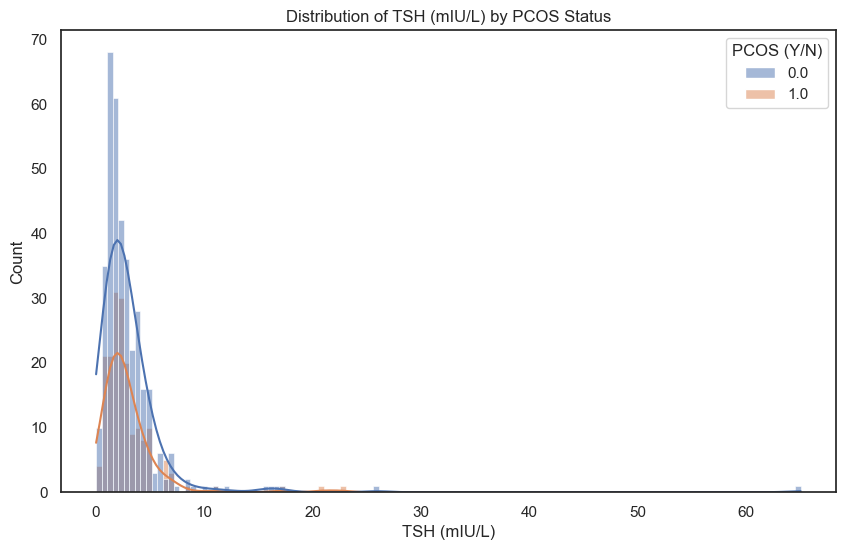

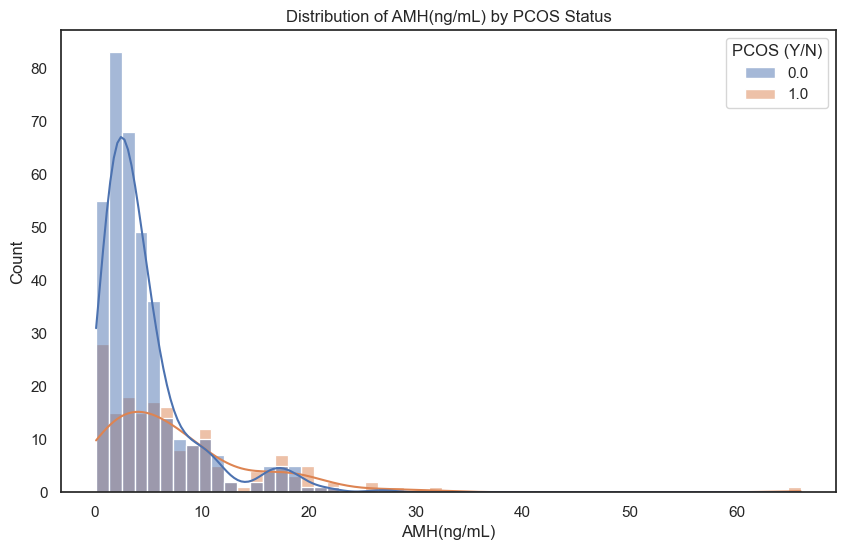

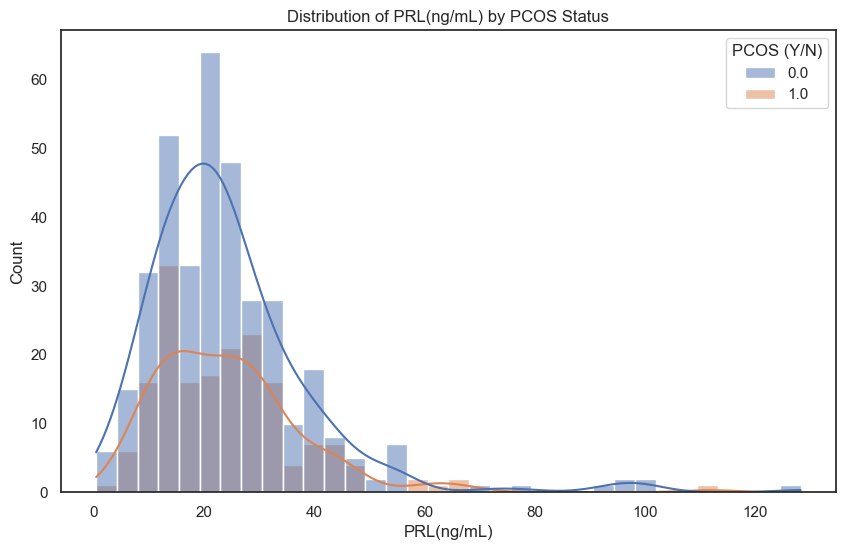

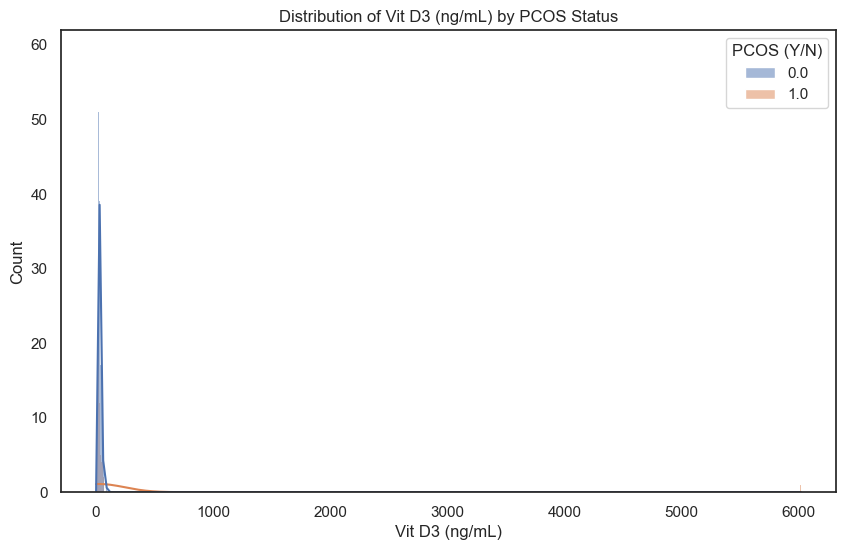

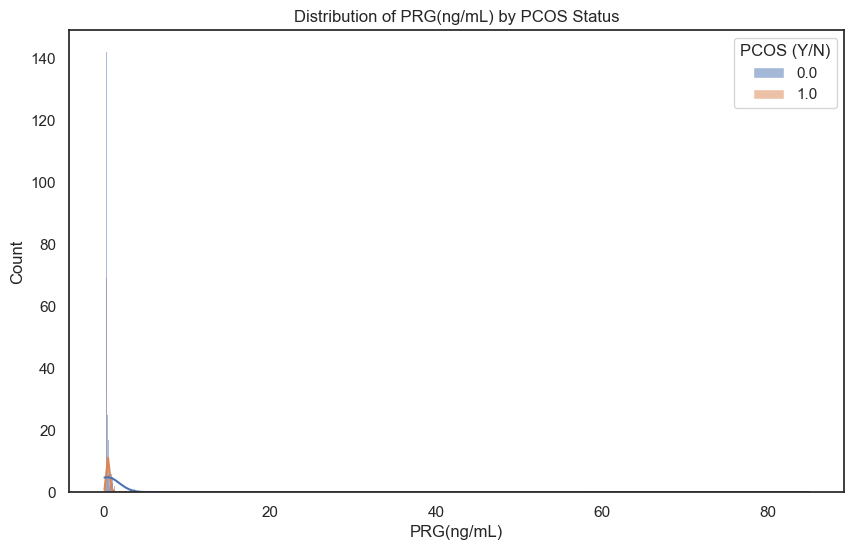

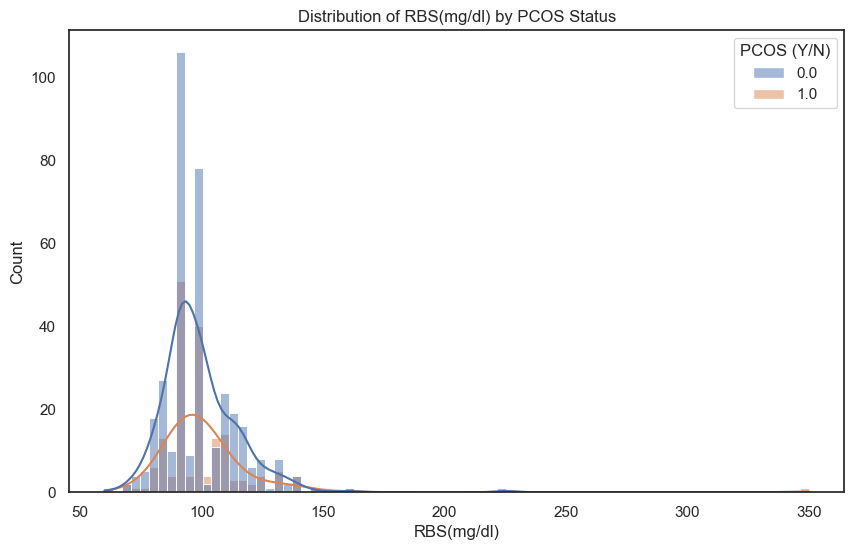

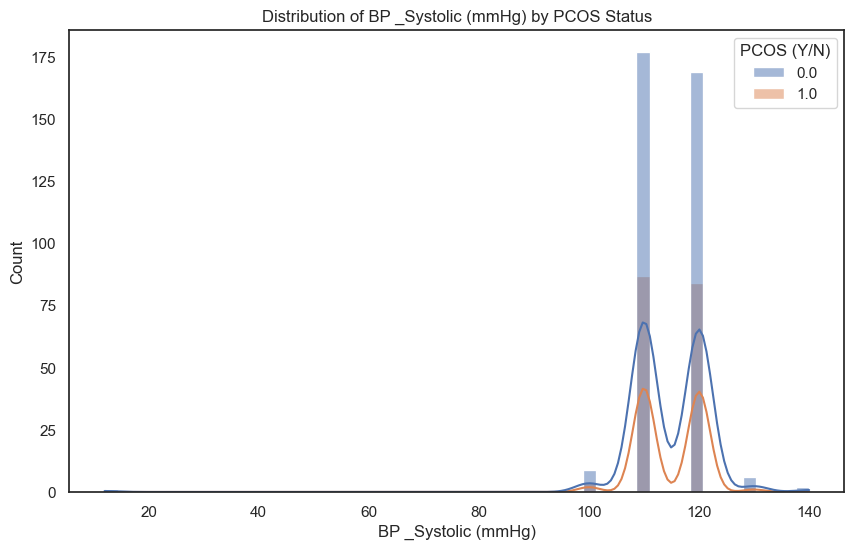

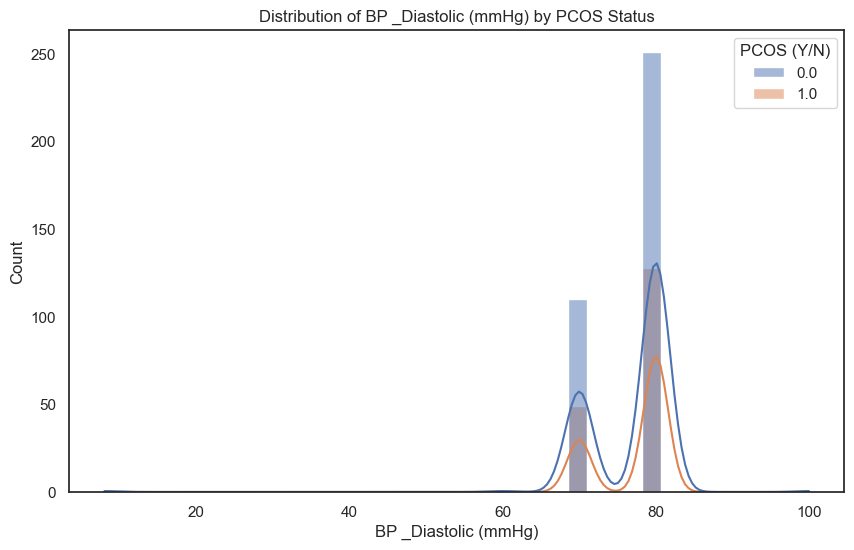

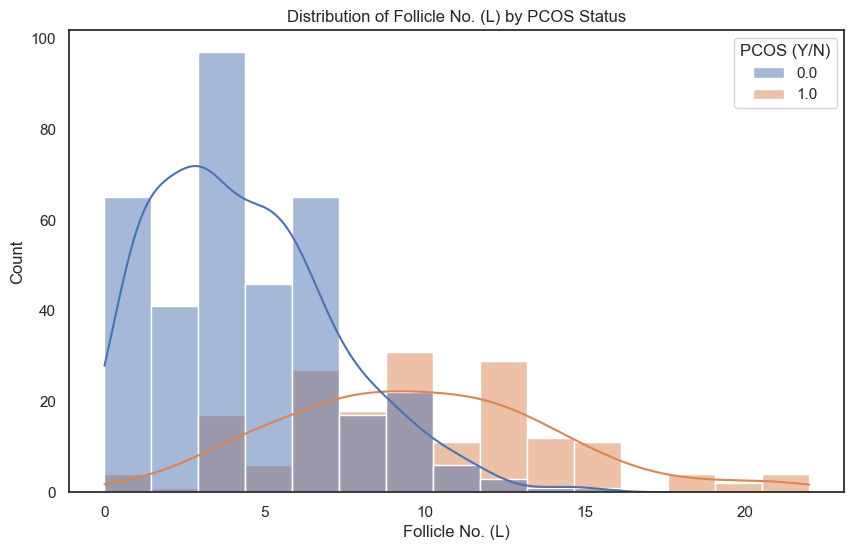

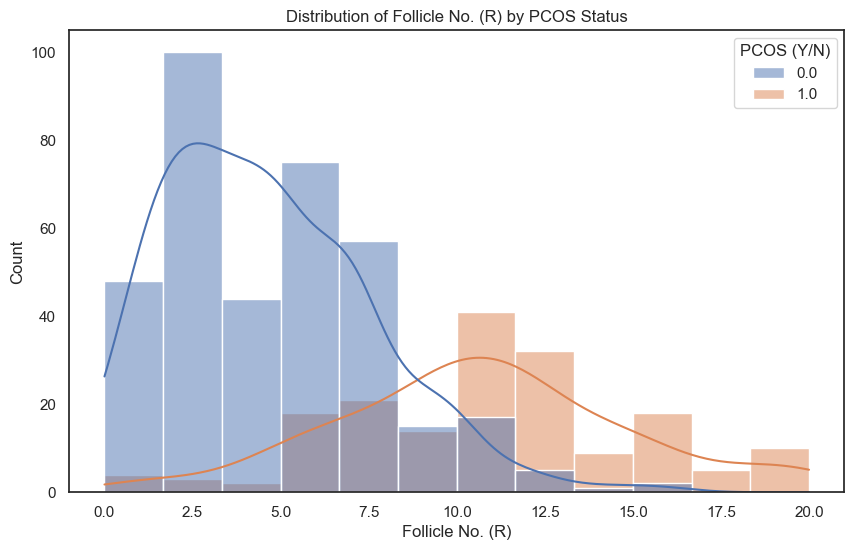

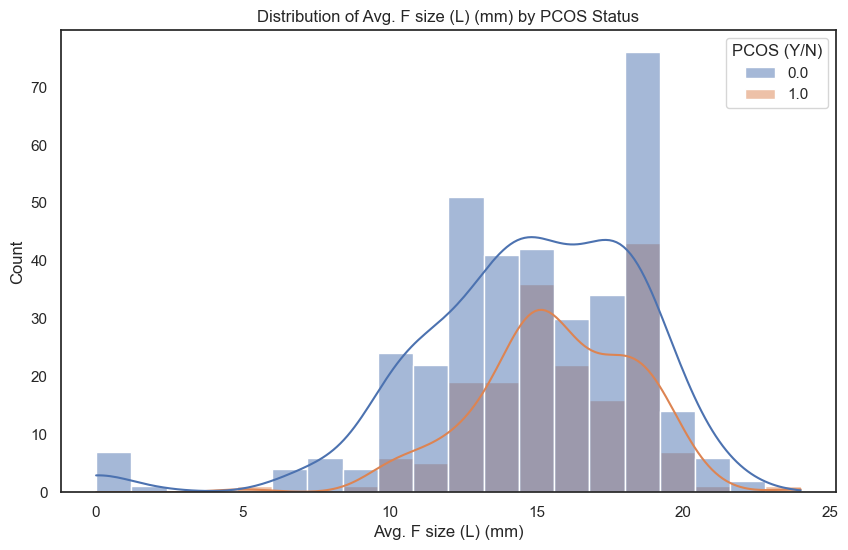

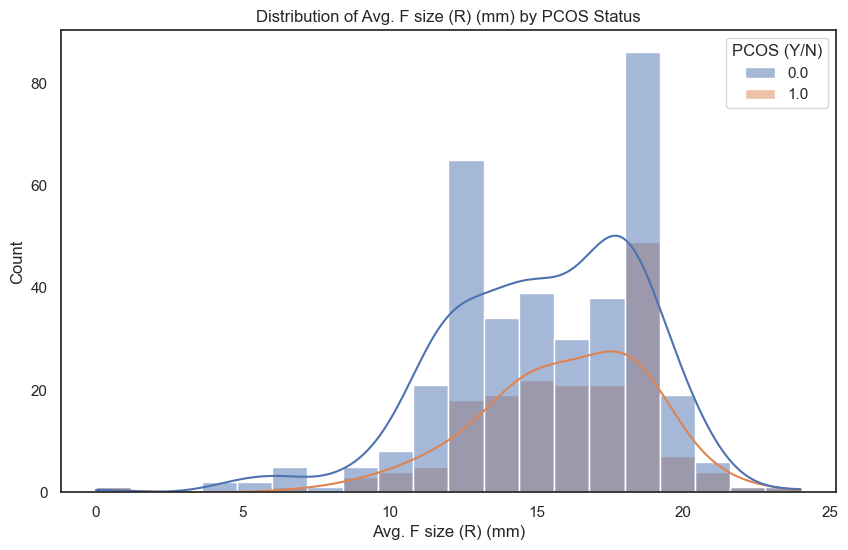

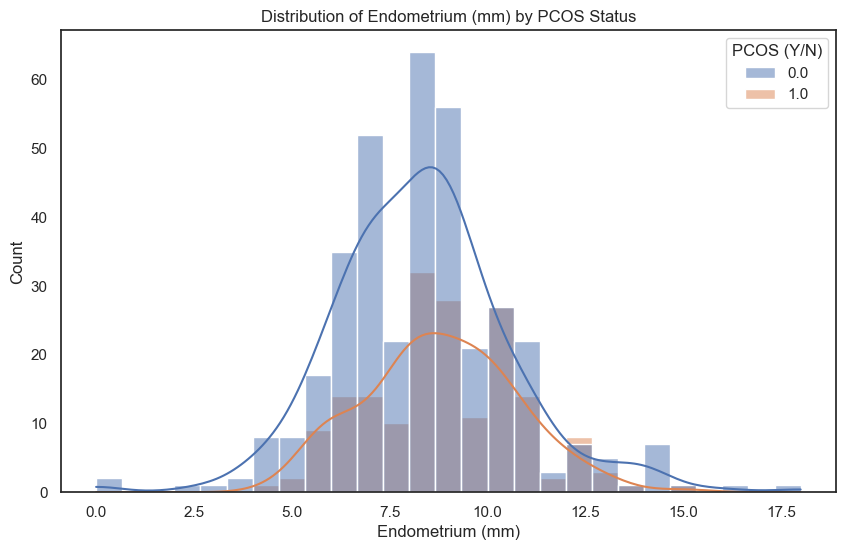

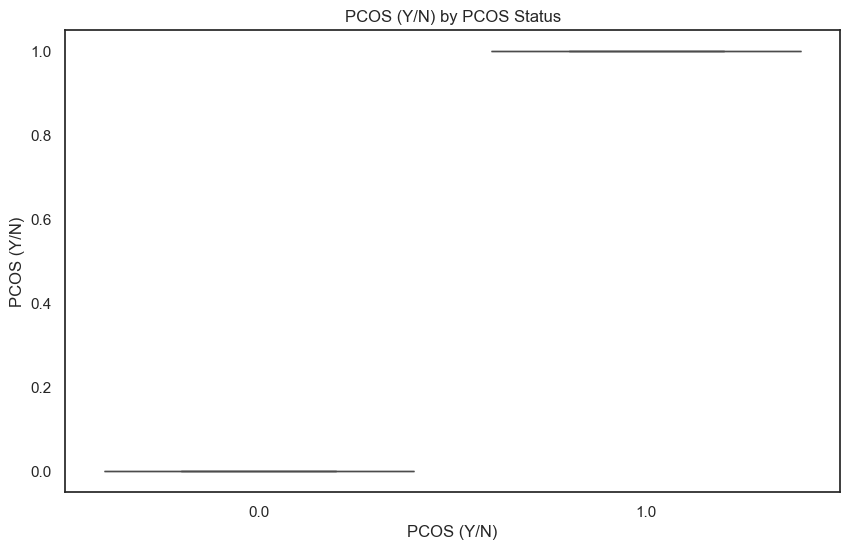

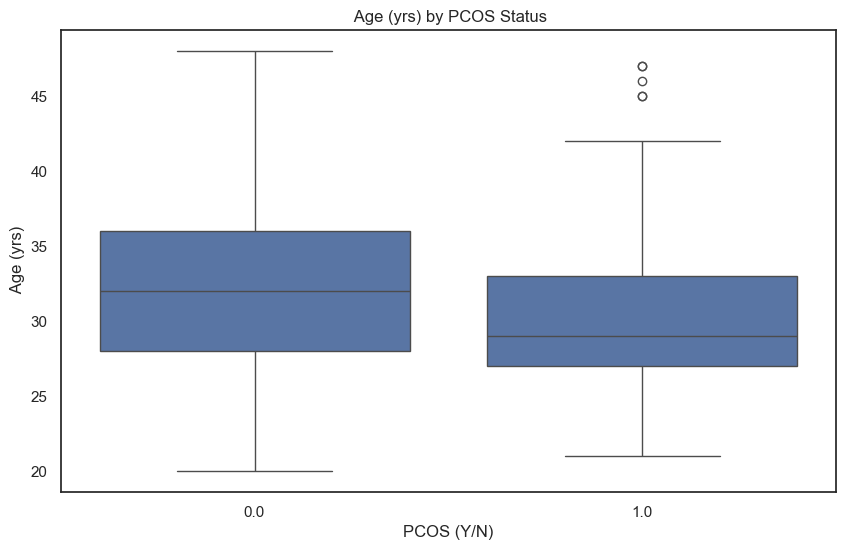

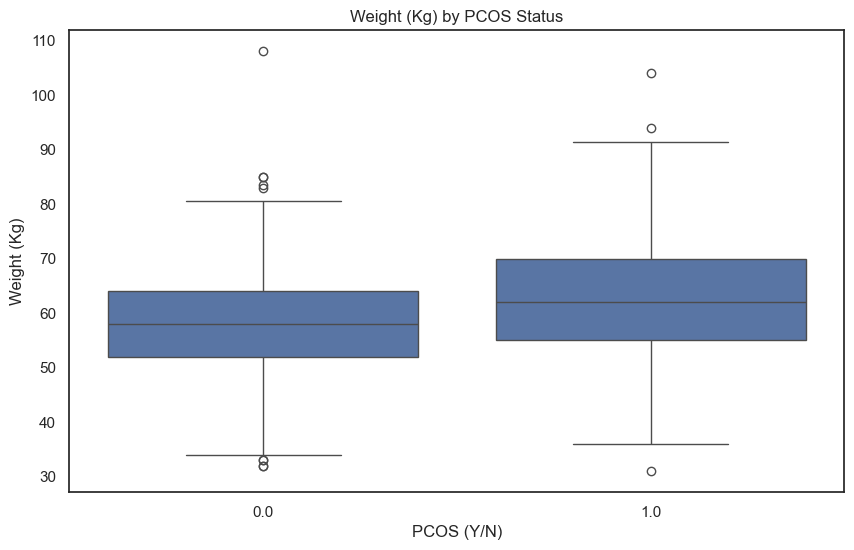

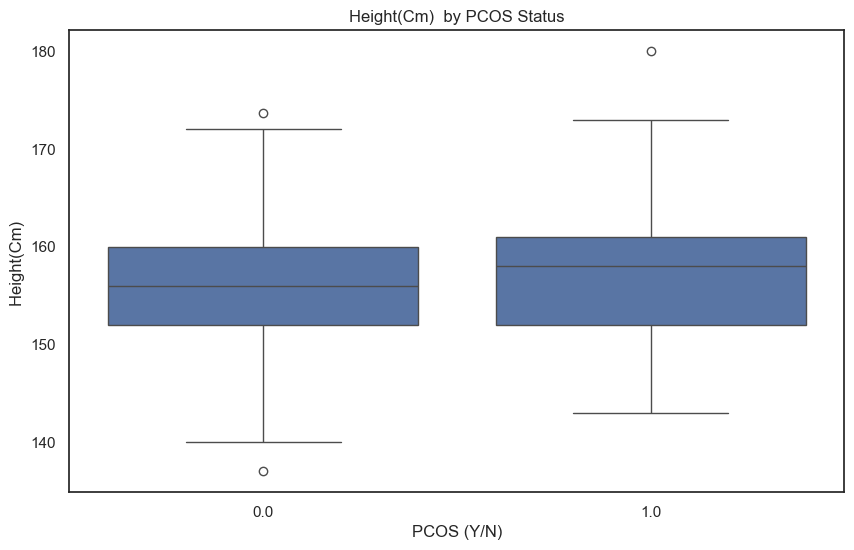

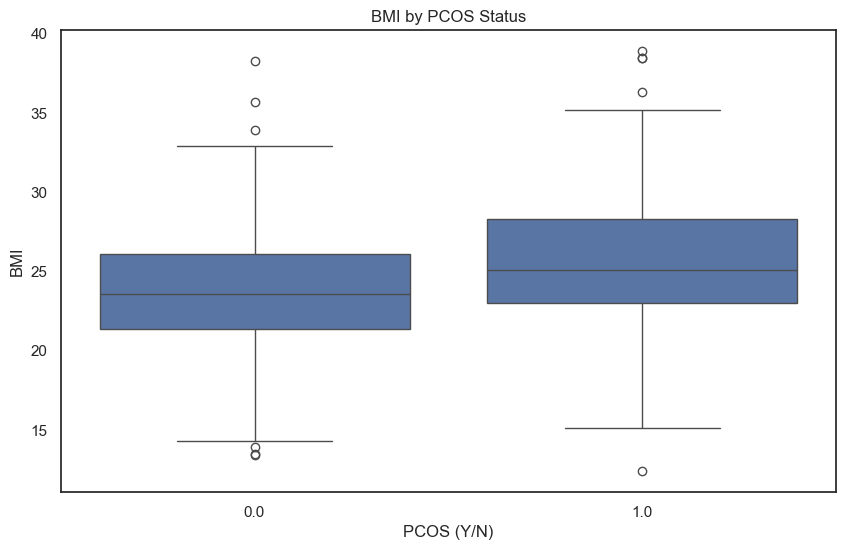

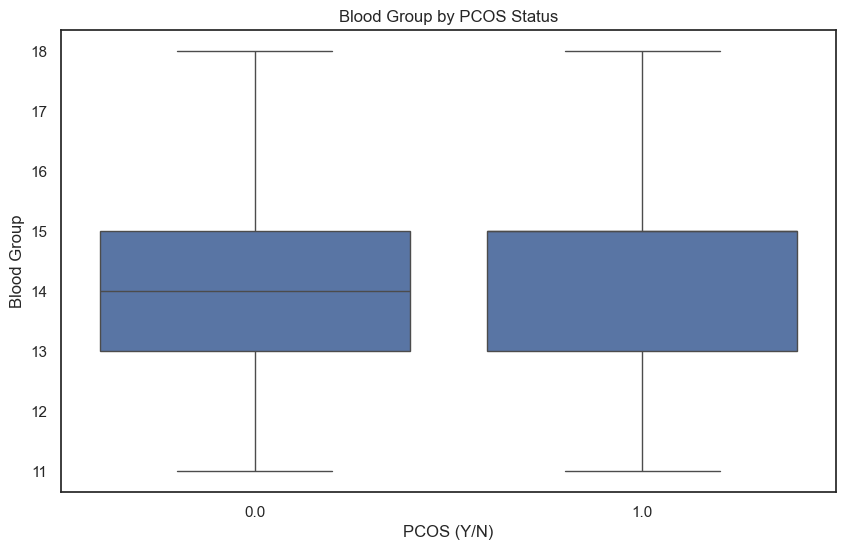

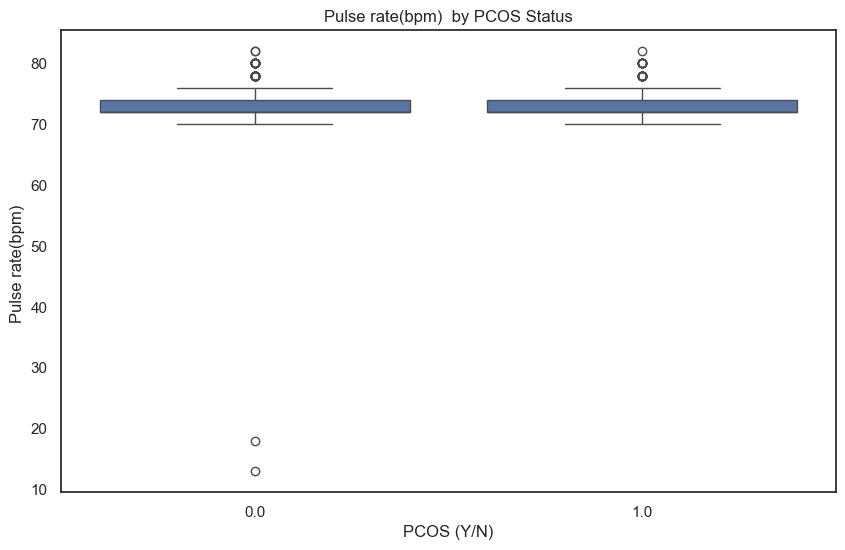

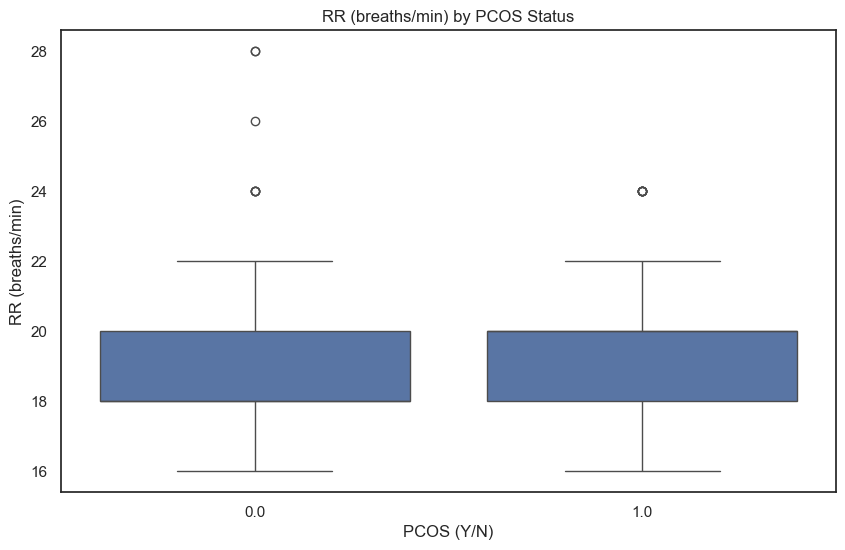

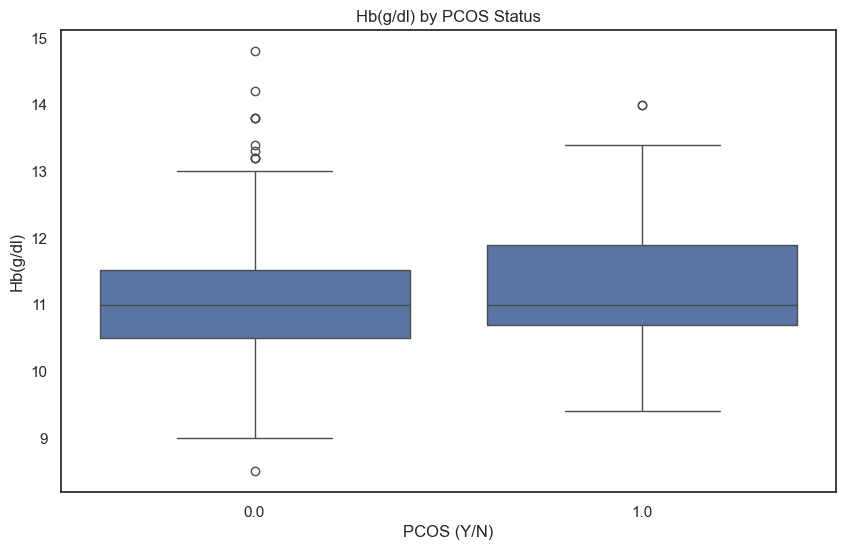

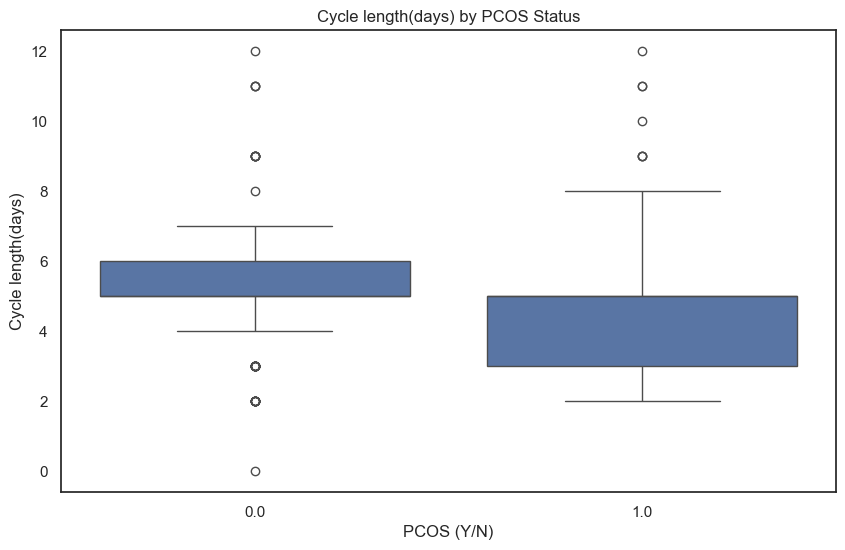

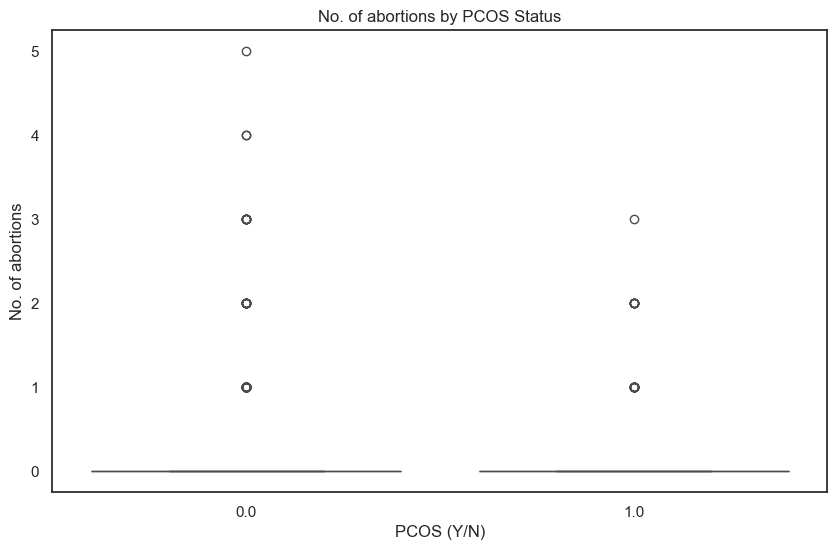

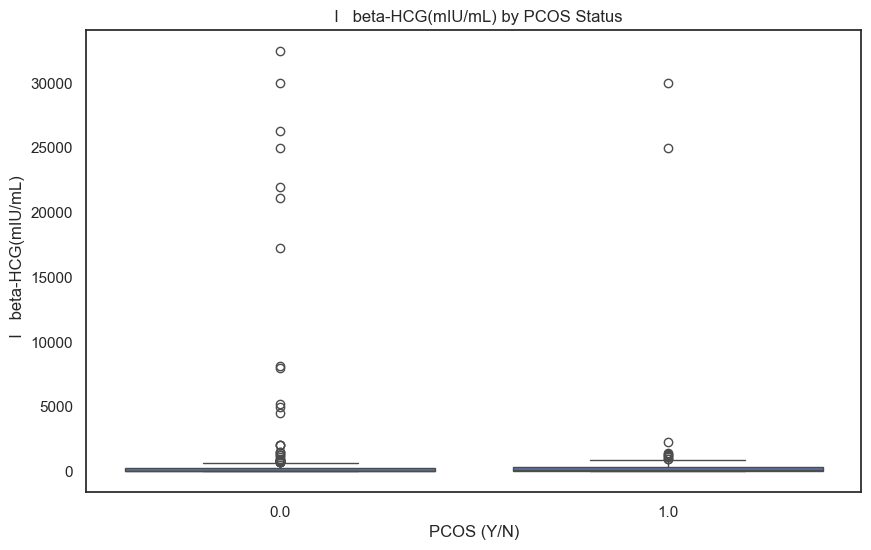

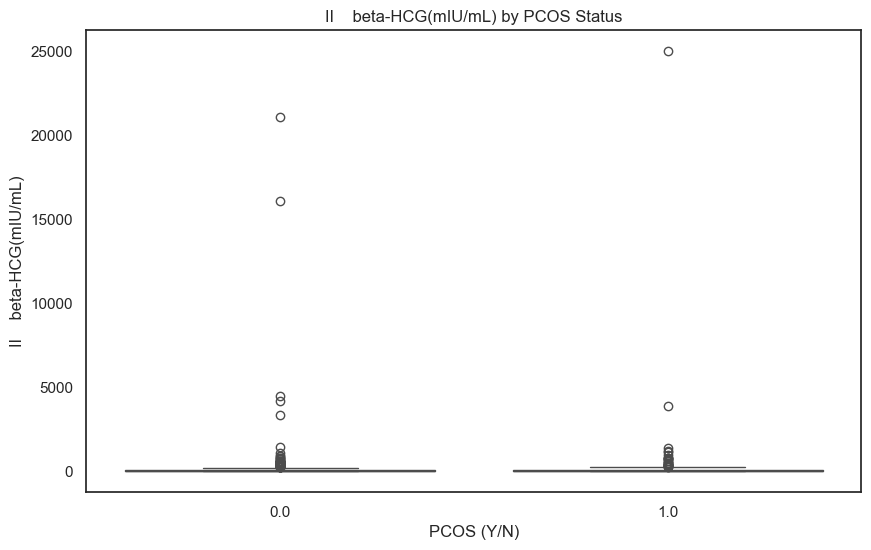

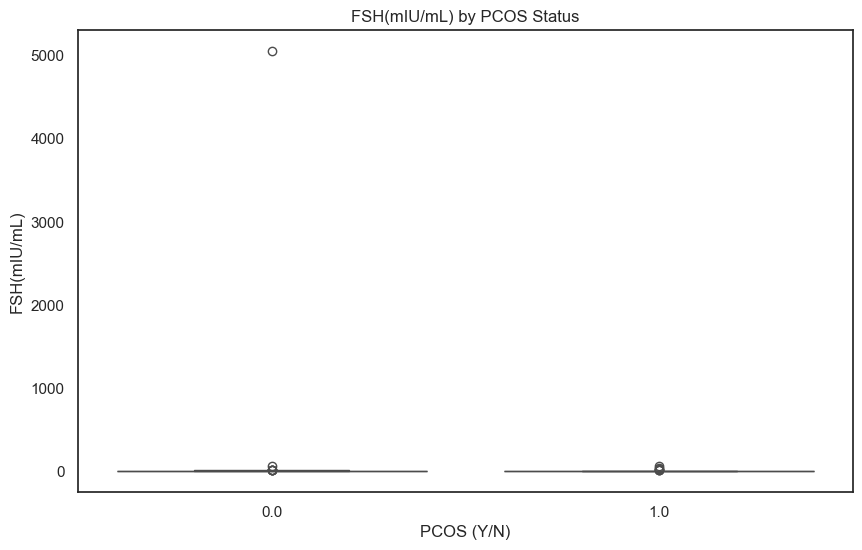

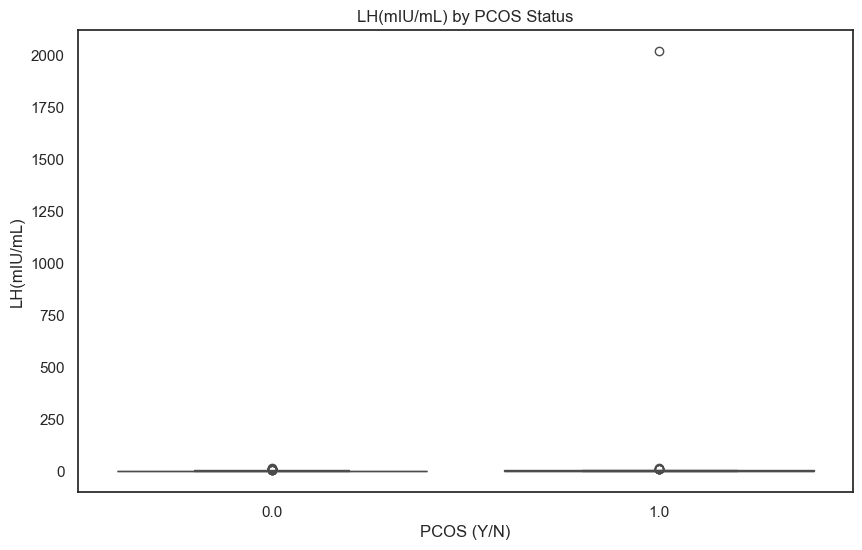

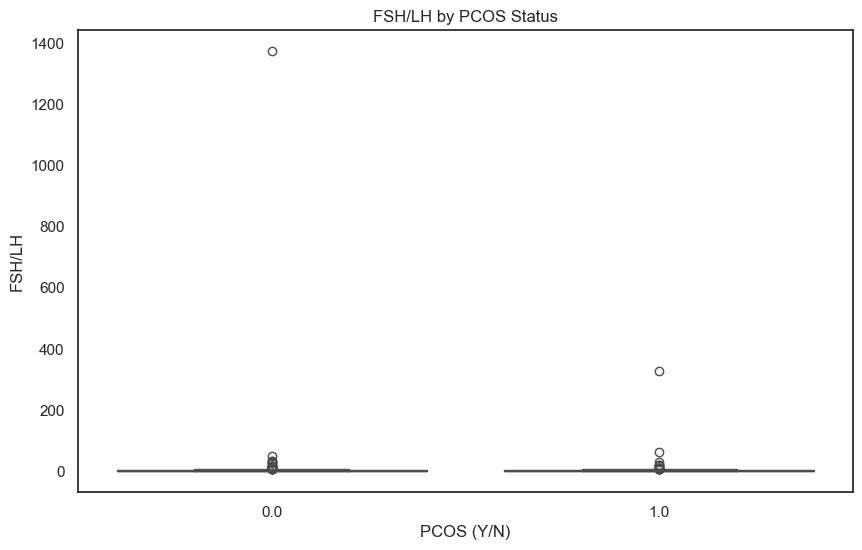

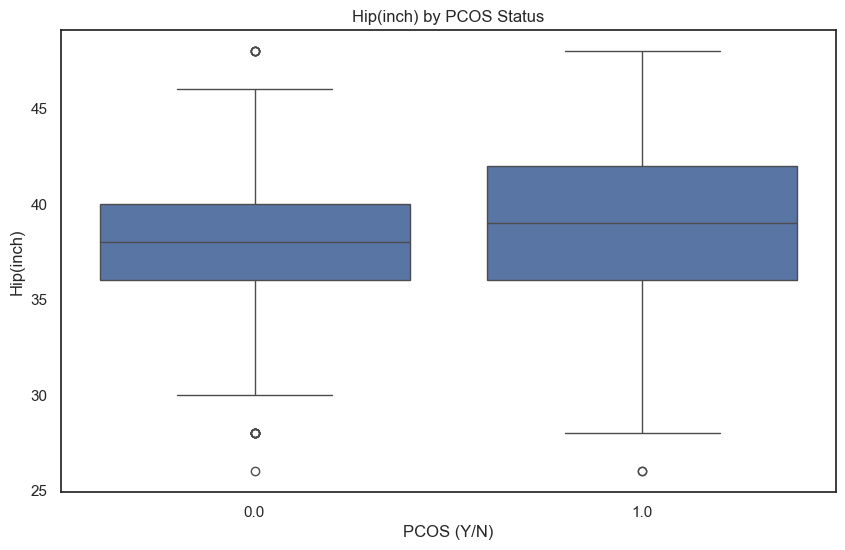

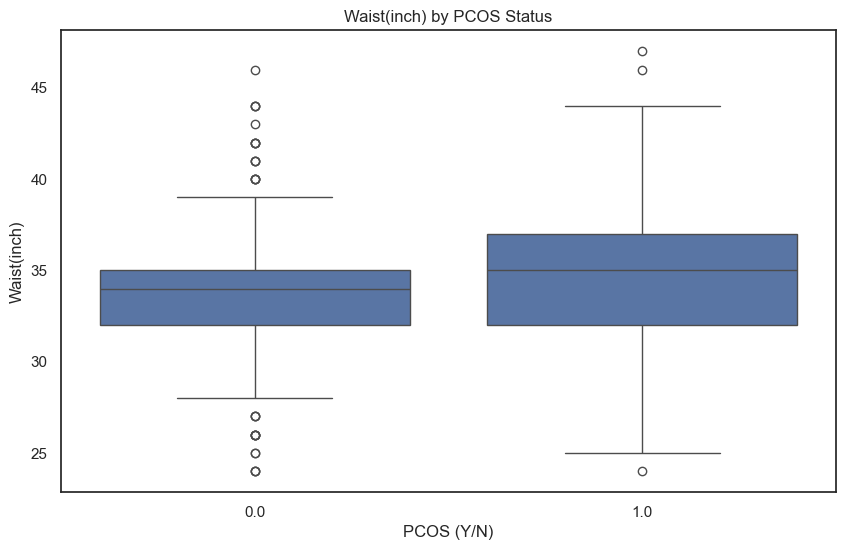

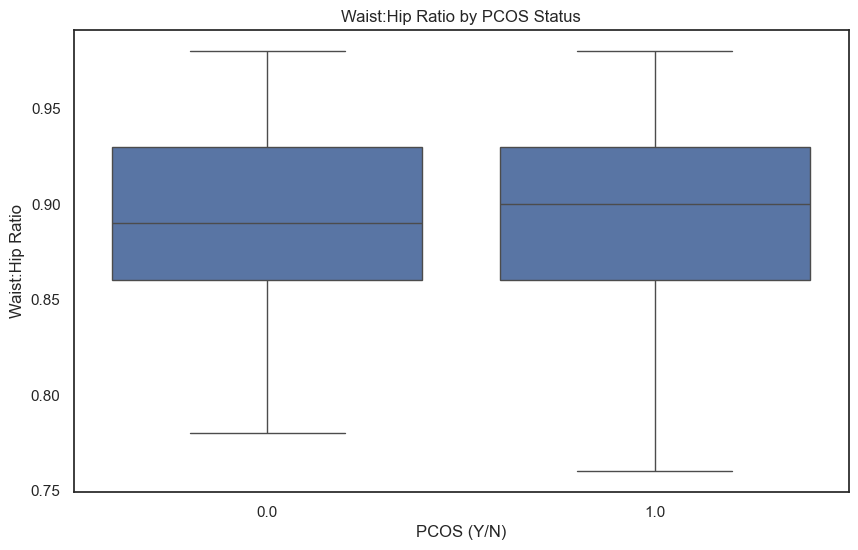

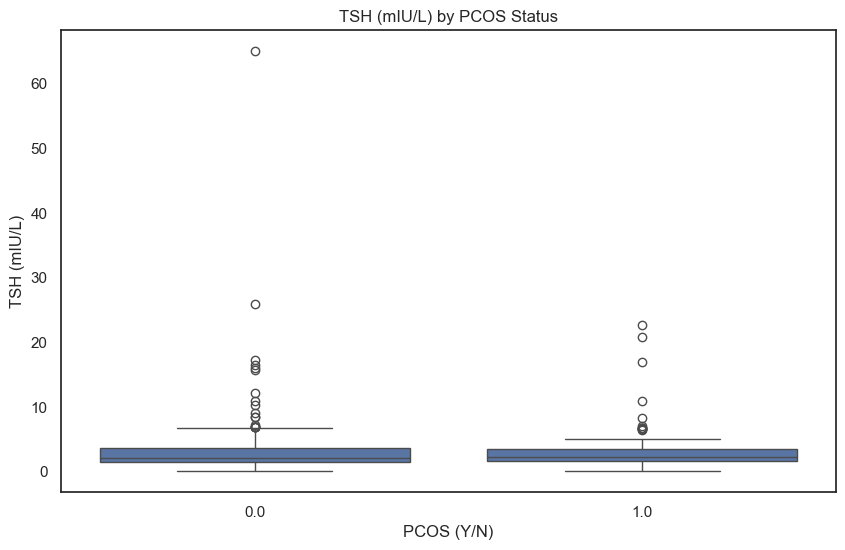

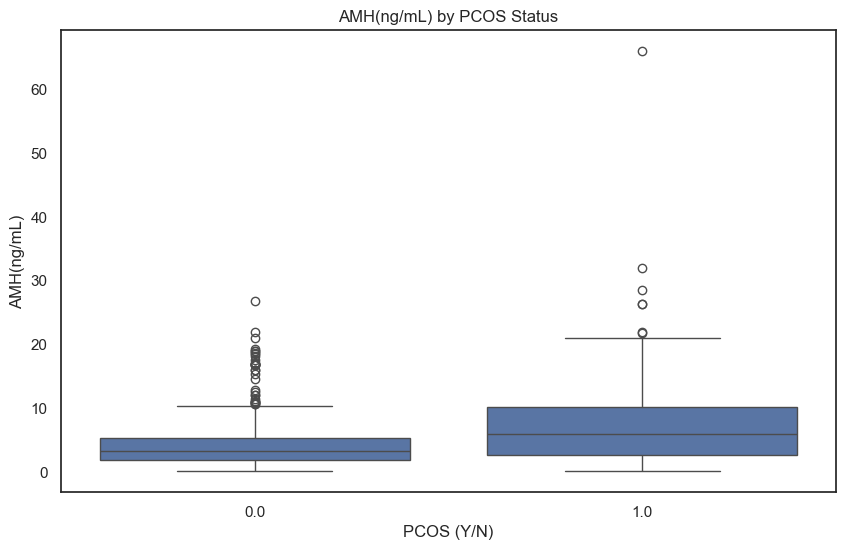

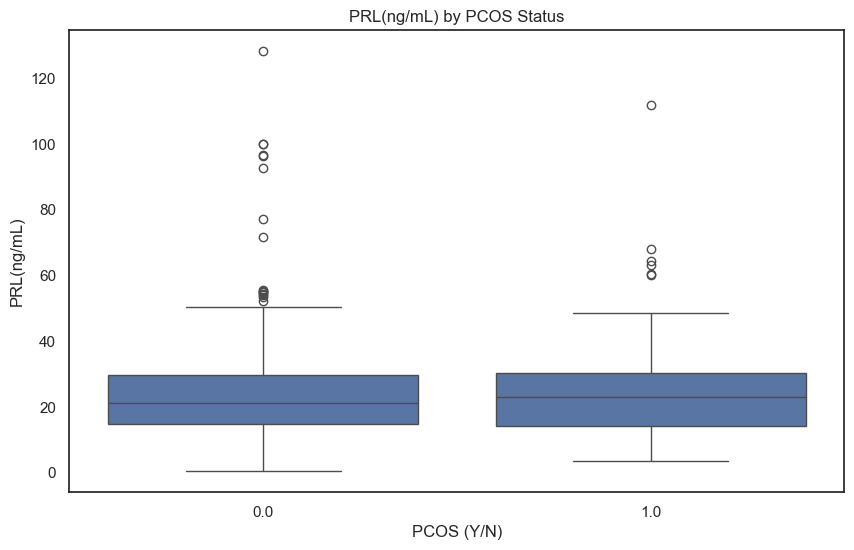

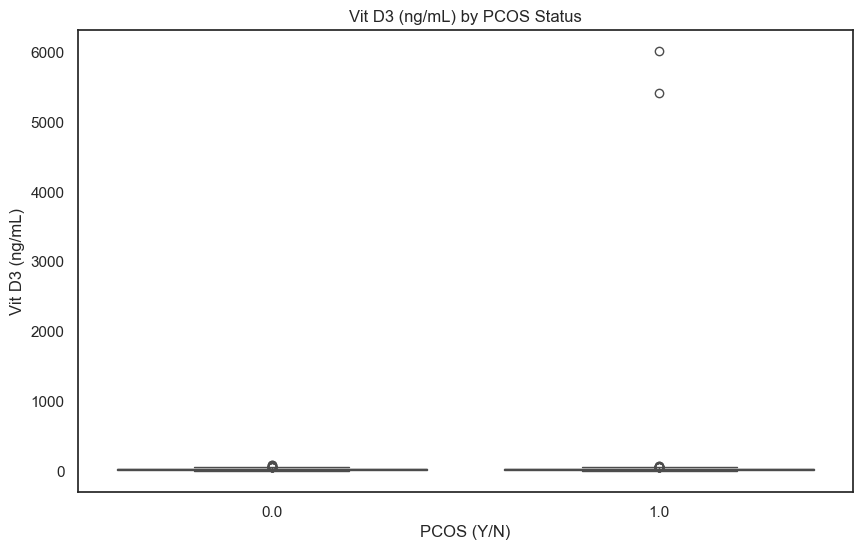

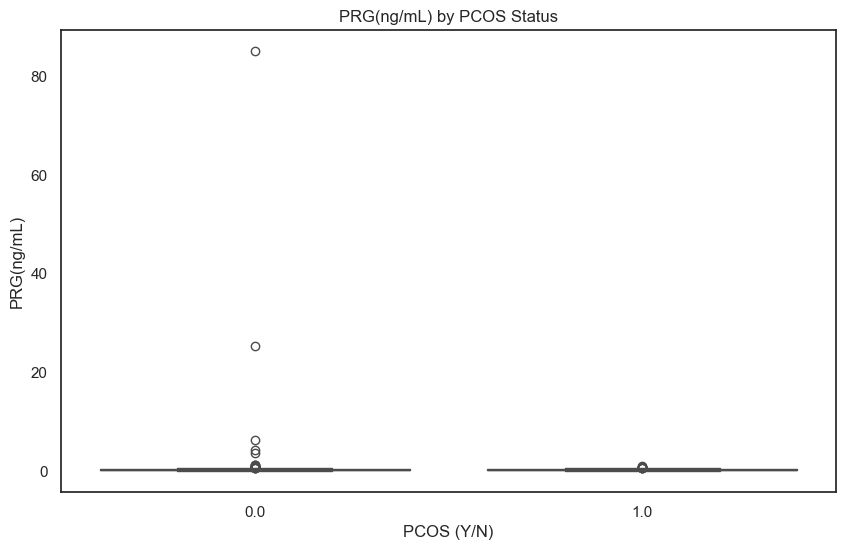

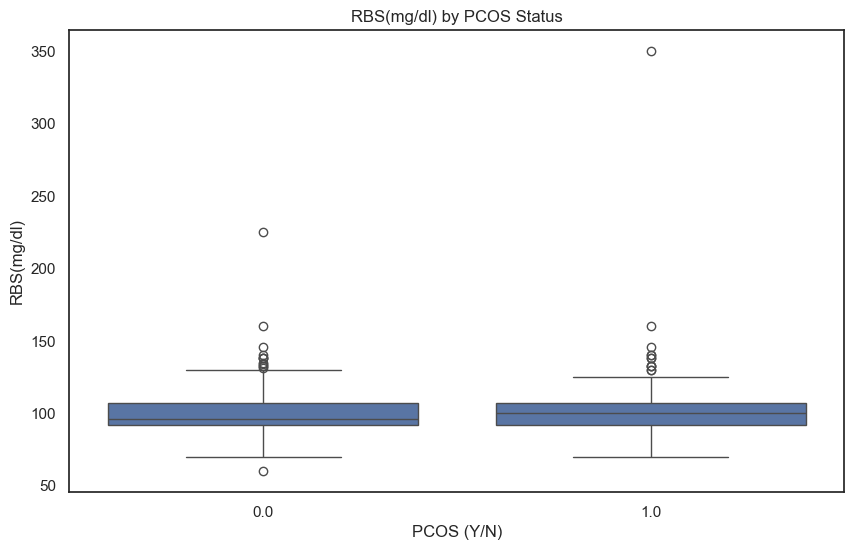

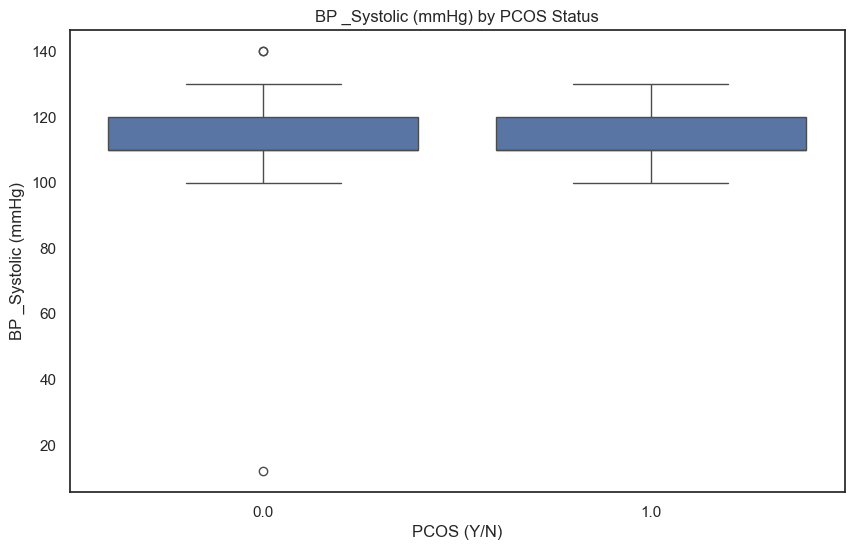

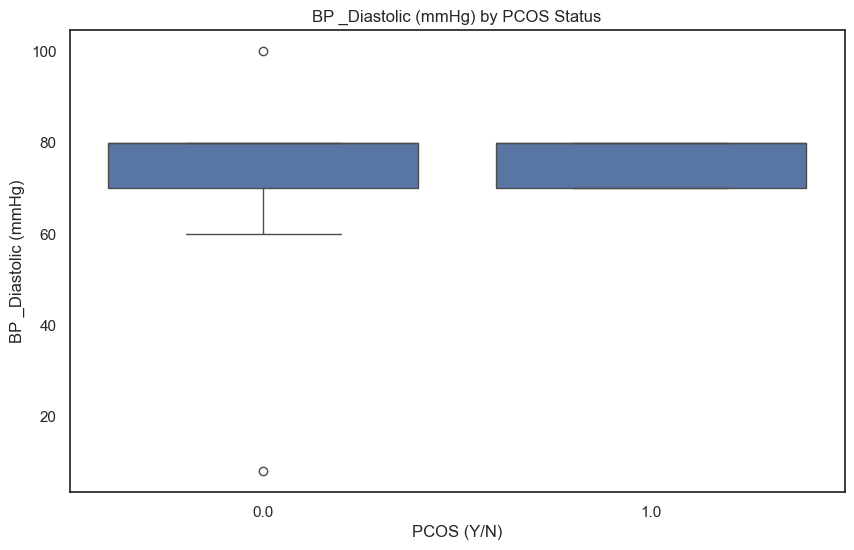

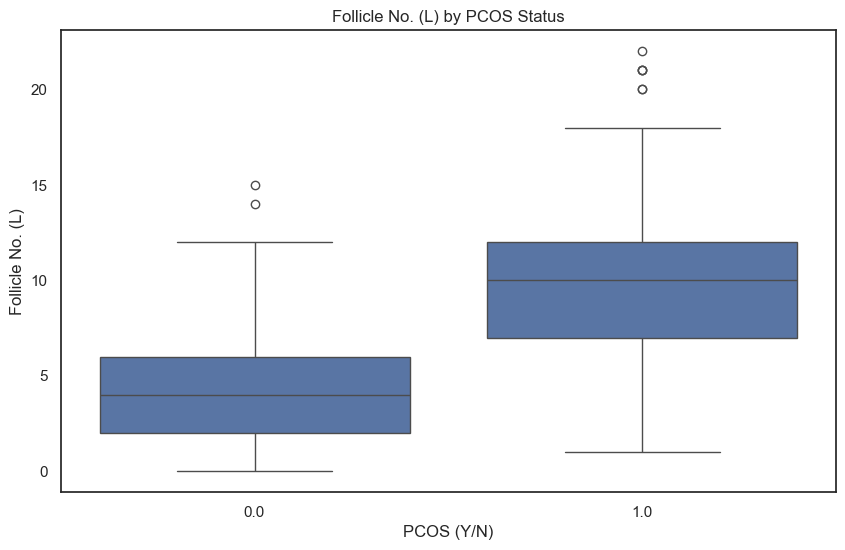

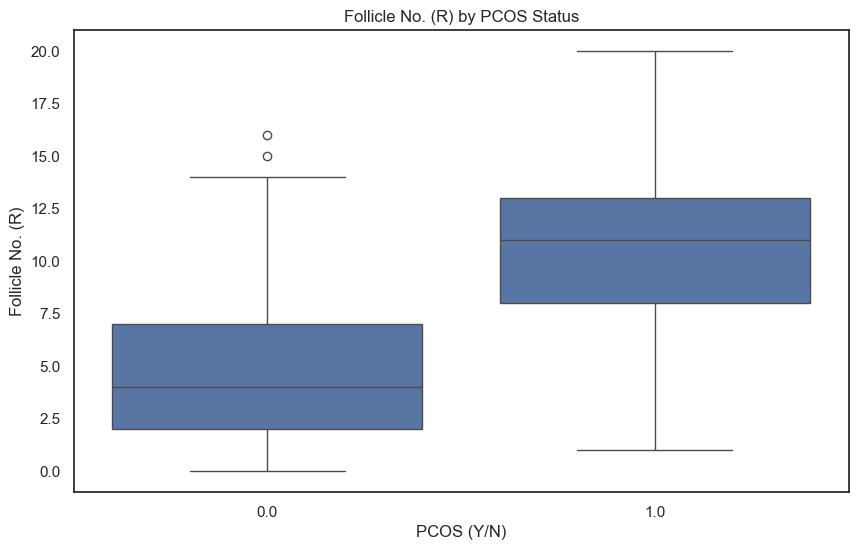

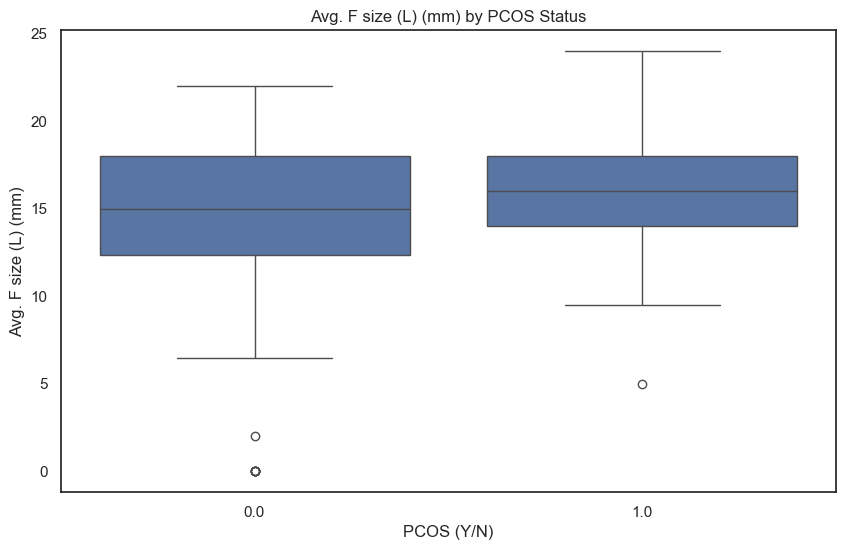

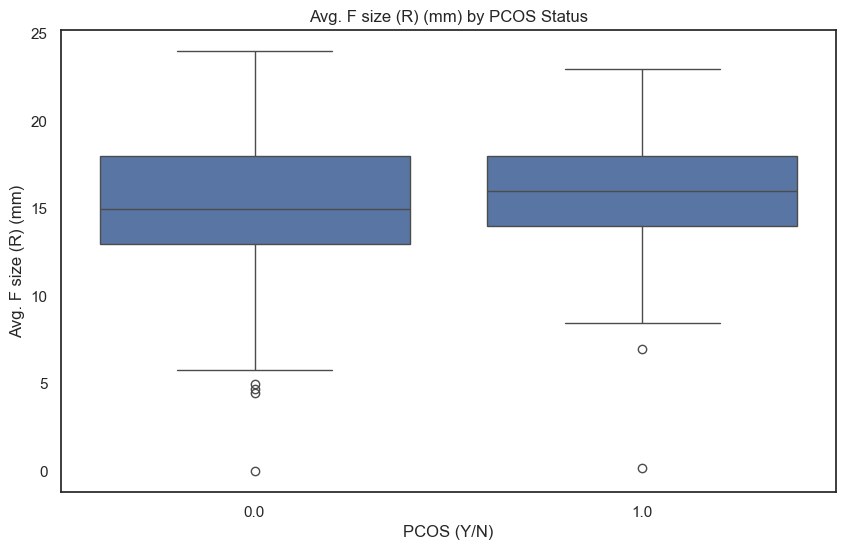

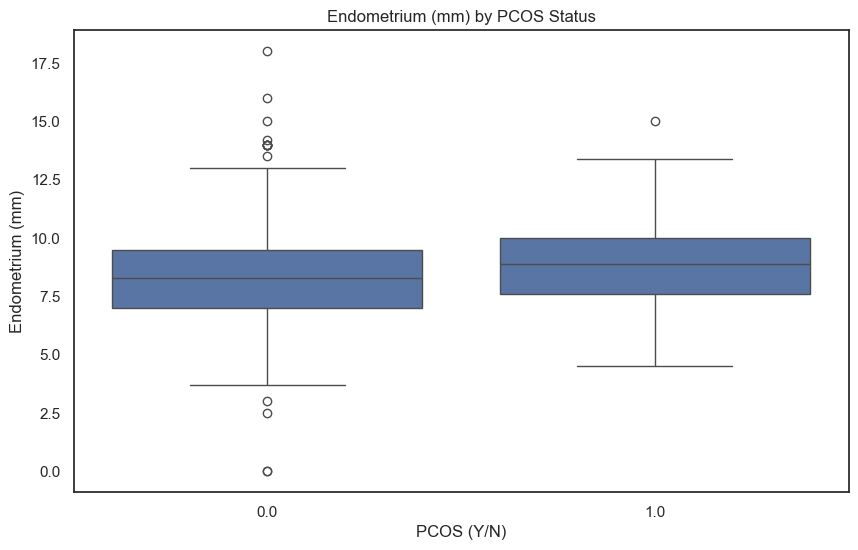

In [837]:
# Histogram for numerical variables
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue='PCOS (Y/N)', kde=True)
    plt.title(f'Distribution of {col} by PCOS Status')
    plt.show()

# Box plots for numerical variables
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='PCOS (Y/N)', y=col)
    plt.title(f'{col} by PCOS Status')
    plt.show()


In [854]:
 #Feature Engineering
df.columns = df.columns.str.strip()

# Feature Engineering
def fix_outliers(df):
    df['Vit D3 (ng/mL)'] = df['Vit D3 (ng/mL)'].clip(upper=100)
    df['FSH(mIU/mL)'] = df['FSH(mIU/mL)'].clip(upper=20)
    df['LH(mIU/mL)'] = df['LH(mIU/mL)'].clip(upper=20)
    return df

df = fix_outliers(df.copy())

# Create clinical ratios and temporal features
df['LH/FSH_ratio'] = df['LH(mIU/mL)'] / (df['FSH(mIU/mL)'] + 1e-6)
df['Androgen_Index'] = (df['PRL(ng/mL)'] + df['AMH(ng/mL)']) / df['BMI']
df['Years_Since_Menarche'] = df['Age (yrs)'] - 13

# Symptom score
pcos_symptoms = ['Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)']
df['Symptom_Score'] = df[pcos_symptoms].sum(axis=1)


In [856]:
# Preprocess data for modeling
X = df.drop('PCOS (Y/N)', axis=1)
y = df['PCOS (Y/N)']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42))
])

X_res, y_res = pipeline.fit_resample(X, y)


In [858]:
#Model Training and Evaluation

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Model Training
model = CatBoostClassifier(
    auto_class_weights='Balanced',
    loss_function='Logloss',
    verbose=0,
    early_stopping_rounds=20
)

model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Hyperparameter Tuning
param_grid = {
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'iterations': [100, 200, 300, 500]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Retrain with best parameters
best_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    loss_function='Logloss',
    verbose=0,
    early_stopping_rounds=20,
    **best_params
)

best_model.fit(X_train, y_train)

# Final Model Evaluation
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))
print("Best Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Accuracy: 0.9365079365079365
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.92        28
         1.0       0.90      1.00      0.95        35

    accuracy                           0.94        63
   macro avg       0.95      0.93      0.93        63
weighted avg       0.94      0.94      0.94        63

Confusion Matrix:
 [[24  4]
 [ 0 35]]
Best Parameters: {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}
Best Model Accuracy: 0.9365079365079365
Best Model Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.92        28
         1.0       0.90      1.00      0.95        35

    accuracy                           0.94        63
   macro avg       0.95      0.93      0.93        63
weighted avg       0.94      0.94      0.94        63

Best Model Confusion Matrix:
 [[24  4]
 [ 0 35]]


In [867]:
df.columns = df.columns.str.strip()

# Ensure protected attributes are preserved before transformation
protected_attributes = df[['Age (yrs)', 'BMI']].copy()

# Preprocess data for fairness analysis
X = df.drop('PCOS (Y/N)', axis=1)
y = df['PCOS (Y/N)']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

df_transformed = preprocessor.fit_transform(X)
df_transformed = pd.DataFrame(df_transformed, index=df.index)
df_transformed['PCOS (Y/N)'] = y
df_transformed[['Age (yrs)', 'BMI']] = protected_attributes

# Ensure no NaN values in the protected attributes
df_transformed = df_transformed.dropna(subset=['Age (yrs)', 'BMI'])

# Convert Age and BMI to binary attributes for fairness analysis
df_transformed['Age (yrs)'] = (df_transformed['Age (yrs)'] >= 30).astype(int)
df_transformed['BMI'] = (df_transformed['BMI'] < 25).astype(int)

aif_dataset = BinaryLabelDataset(
    df=df_transformed,
    label_names=['PCOS (Y/N)'],
    protected_attribute_names=['Age (yrs)', 'BMI']
)

# Define privileged and unprivileged groups
privileged_groups = [{'Age (yrs)': 1, 'BMI': 1}]
unprivileged_groups = [{'Age (yrs)': 0, 'BMI': 0}]

metric = ClassificationMetric(
    aif_dataset,
    aif_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Print bias metrics
print("Disparate Impact:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
print("Average Odds Difference:", metric.average_odds_difference())

Disparate Impact: 2.4611973392461195
Statistical Parity Difference: 0.3238329238329238
Equal Opportunity Difference: 0.0
Average Odds Difference: 0.0


**Results**

## Results

### Correlation Matrix

The correlation matrix showed strong correlations between certain features such as BMI and Weight, Waist and Waist:Hip Ratio, and Follicle numbers on both sides. Moderate correlations were observed between PCOS (Y/N) and features like AMH(ng/mL), Follicle No. (L), and Follicle No. (R).

### Model Performance

- **Accuracy:** 0.937
- **Classification Report:**
  ```
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92        28
         1.0       0.90      1.00      0.95        35

    accuracy                           0.94        63
   macro avg       0.95      0.93      0.93        63
weighted avg       0.94      0.94      0.94        63
  ```
- **Confusion Matrix:**
  ```
      [[24  4]
       [ 0 35]]
  ```

## Fairness Analysis

To ensure fairness, we performed a bias check using the AIF360 library:

- **Disparate Impact:** 2.4611973392461195
- **Statistical Parity Difference:** 0.3238329238329238
- **Equal Opportunity Difference:** 0.0
- **Average Odds Difference:** 0.0

## Conclusion

The model demonstrates high accuracy and effectively predicts PCOS based on the provided features. The fairness analysis indicates some disparity in the impact, which should be monitored and addressed in future iterations of the model. Future steps include further validation with external datasets and continuous monitoring to ensure model fairness and performance.
